### Downloading and extracting dataset

In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.32G/1.33G [00:14<00:00, 129MB/s]
100% 1.33G/1.33G [00:15<00:00, 95.2MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/celeba-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Files in dataset:

- list_eval_partition.csv: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing

- list_bbox_celeba.csv: Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box

- list_landmarks_align_celeba.csv: Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth

- list_attr_celeba.csv: Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative

## Importing libraries

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import tqdm
from tqdm import tqdm
import cv2
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, BatchNormalization

import torch
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights
import torch.optim as optim


import sklearn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import multilabel_confusion_matrix

In [6]:
ds_folder_path = "/content/img_align_celeba/img_align_celeba"

## Functions

In [47]:
def plotCorrelationMatrix(df, graphWidth):
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.show()

In [48]:
def show_images(images):
    num_rows = 4
    num_cols = 16
    plt.figure(figsize=(40, 10))
    plt.subplots_adjust(wspace=0, hspace=0)
    for i in range(len(images)):
        plt.subplot(num_rows, num_cols, i + 1)
        if images[i].dtype == 'uint8':
             plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        else:
             plt.imshow(images[i])
        plt.axis('off')
    plt.show()

def draw_landmark(df, id, img):
    id = int(id)
    result = df[df['ID'] == id]
    for i in range(1, len(result.columns), 2):
        point_x = int(result.iloc[0, i])
        point_y = int(result.iloc[0, i + 1])
        img = cv2.circle(img, (point_x, point_y), radius=4, color=(51, 255, 51), thickness=-1)
    return img

The Hamming score calculates the ratio of the number of correctly predicted labels to the total number of labels, without considering the differences between the prediction and the ground truth for each data sample

In [49]:
def hamming_score(y_true, y_pred):
    num_samples = len(y_true)
    total_correct = 0

    for true_labels, pred_labels in zip(y_true, y_pred):
        correct_labels = (true_labels == pred_labels).sum()
        total_correct += correct_labels
    hamming_score = total_correct / (num_samples * len(y_true[0]))
    return hamming_score

def get_multilabel_evaluation(model, test_loader):
    all_predictions = []
    all_targets = []
    model.eval()
    with torch.no_grad():
        for dir_ in test_loader:
            inputs, targets = dir_.values()
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            predictions = (outputs > 0.01).float()
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    return all_predictions, all_targets

In [50]:
def plot_evaluation(train_losses, train_hamming_scores, val_losses, val_hamming_scores, precision, recall, f_score):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot Losses
    axes[0].plot(train_losses, label='Train Losses', marker='o')
    axes[0].plot(val_losses, label='Validation Losses', marker='o')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Train and Validation Losses vs. Epochs')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Hamming Scores
    axes[1].plot(train_hamming_scores, label='Train Hamming Scores', marker='o')
    axes[1].plot(val_hamming_scores, label='Validation Hamming Scores', marker='o')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Hamming Score')
    axes[1].set_title('Train and Validation Hamming Scores')
    axes[1].legend()
    axes[1].grid(True)

    # Plot Precision, Recall, F-Score
    metrics = ['Precision', 'Recall', 'F-Score']
    values = [precision, recall, f_score]
    axes[2].bar(metrics, values, color=['blue', 'green', 'red'])
    axes[2].set_title('Score')
    axes[2].set_ylabel('Score')
    axes[2].grid(axis='y')
    axes[2].set_ylim(0, 1)

    plt.tight_layout()
    plt.show()

In [51]:
def define_model(train_loader, val_loader, learning_rate, num_features, dropout_prob, device):
    Model = resnet50(weights=ResNet50_Weights.DEFAULT)
    Model.fc = nn.Sequential(
        nn.Linear(Model.fc.in_features, num_features),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_prob),
        nn.Linear(num_features, len(train_dataset.classes))
    )
    Model = Model.to(device)
    weight_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float).to(device)
    criterion = nn.BCEWithLogitsLoss(weight=weight_tensor)
    optimizer = optim.Adam(Model.parameters(), lr=learning_rate)
    Metric = []
    Metric.append(train_model(Model, device, train_loader, val_loader, criterion, optimizer, num_epochs=4))

    true, pred = get_multilabel_evaluation(Model, test_loader)
    predictions_np = np.concatenate(pred)
    targets_np = np.concatenate(true)
    precision, recall, f_score, _ = precision_recall_fscore_support(targets_np, predictions_np, average='weighted')
    Metric.append([precision, recall, f_score])
    return Model, Metric

In [52]:
def train_model(model, device, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_losses = []
    train_hamming_scores = []
    val_losses = []
    val_hamming_scores = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_train_loss = 0

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch')
        for dict_ in train_bar:
            inputs, labels = dict_.values()
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            print(outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            predicted_labels = (outputs > 0.5).float()
            hamming_score_value = hamming_score(labels.cpu().numpy(), predicted_labels.cpu().numpy())
            train_bar.set_postfix(loss=loss.item(), hamming_score=hamming_score_value)

            os.chdir("/content")
            name = "ImgCapt_Model"
            torch.save(model.state_dict(), name_)

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)
        train_hamming_scores.append(hamming_score_value)

        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for dict_ in val_loader:
                inputs, labels = dict_.values()
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item() * inputs.size(0)

                predicted_labels = (outputs > 0.5).float()
                val_hamming_score = hamming_score(labels.cpu().numpy(), predicted_labels.cpu().numpy())

        val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_hamming_scores.append(val_hamming_score)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Hamming Score: {hamming_score_value:.4f}, Val Loss: {val_loss:.4f}, Val Hamming Score: {val_hamming_score:.4f}")

    return [train_losses, train_hamming_scores, val_losses, val_hamming_scores]

## EDA

In [13]:
image_folder_path = "/content/img_align_celeba/img_align_celeba"
label_path = "/content/list_attr_celeba.csv"
eval_path = "/content/list_eval_partition.csv"

In [14]:
df_eval = pd.read_csv(eval_path)
df_landmarks = pd.read_csv("/content/list_landmarks_align_celeba.csv")
df_attr = pd.read_csv(label_path)

In [15]:
df_attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [16]:
df_landmarks.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


drop image_id and replace -1 with 0

In [17]:
attr = df_attr.drop(columns = ["image_id"])
attr = attr.replace(-1,0)
attr.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [18]:
landmarks = df_landmarks.drop(columns = ["image_id"])
landmarks.head()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,69,109,106,113,77,142,73,152,108,154
1,69,110,107,112,81,135,70,151,108,153
2,76,112,104,106,108,128,74,156,98,158
3,72,113,108,108,101,138,71,155,101,151
4,66,114,112,112,86,119,71,147,104,150


In [19]:
landmark_id = landmarks.copy(deep = True)
landmark_id.insert(0, 'ID', range(0, len(landmark_id)))
landmark_id.head()

,ID,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,0,69,109,106,113,77,142,73,152,108,154
1,1,69,110,107,112,81,135,70,151,108,153
2,2,76,112,104,106,108,128,74,156,98,158
3,3,72,113,108,108,101,138,71,155,101,151
4,4,66,114,112,112,86,119,71,147,104,150


Some images with landmarks indicated(left eye, right eye, nose, left mouth, right mouth)

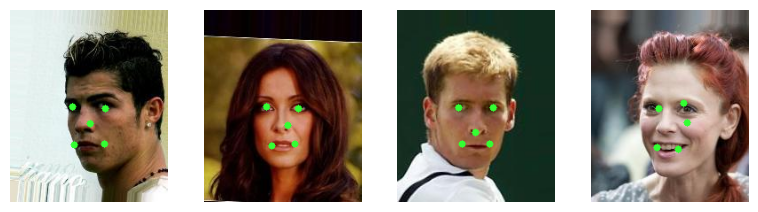

In [20]:
images=[]
os.chdir(ds_folder_path)
for image in ['128338.jpg', '100120.jpg', '000090.jpg', '000002.jpg']:
    file = os.path.join(ds_folder_path, image)
    image_ = cv2.imread(file)
    # print(int(image.replace('.jpg', '')))
    image_ = draw_landmark(landmark_id, int(image.replace('.jpg', '')), image_)
    images.append(image_)
show_images(images)

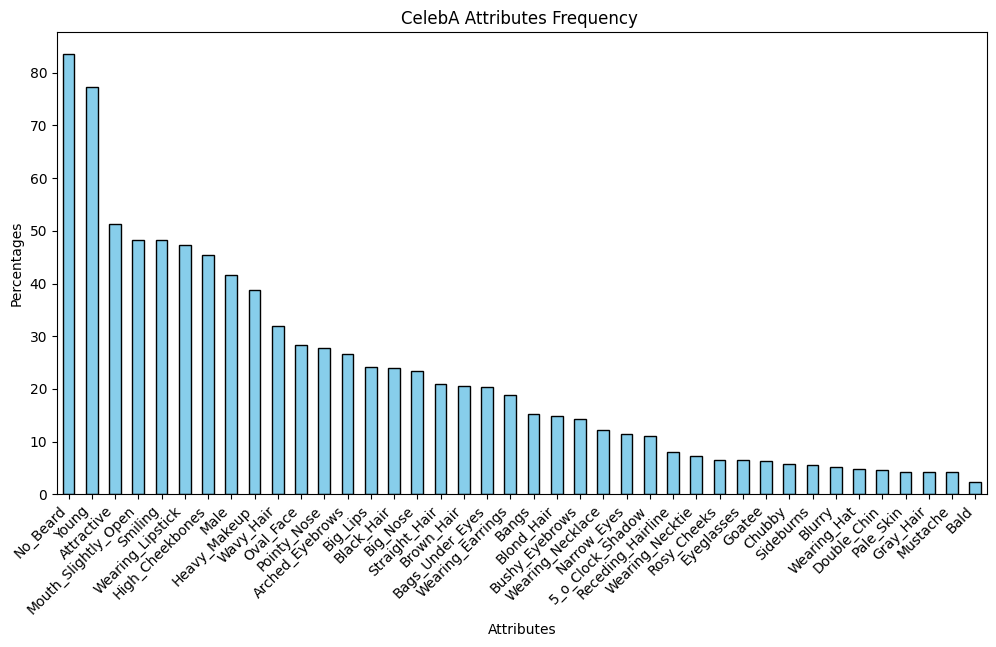

In [21]:
counts = attr.sum()
# print(counts)
percs = (counts/len(attr))*100
percs_sorted = percs.sort_values(ascending = False)

plt.figure(figsize=(12, 6))
percs_sorted.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('CelebA Attributes Frequency ')
plt.xlabel('Attributes')
plt.ylabel('Percentages')
plt.xticks(rotation=45, ha='right')
plt.show()

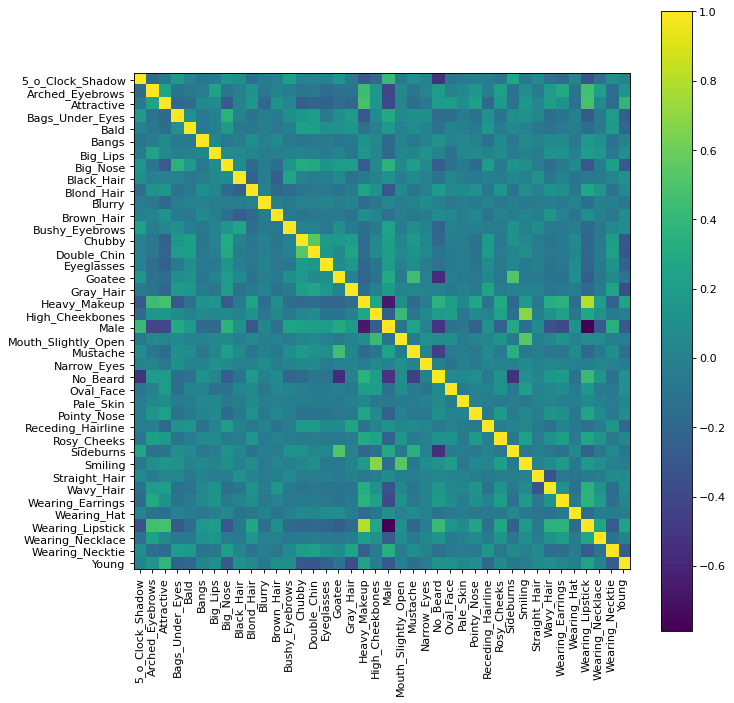

In [22]:
plotCorrelationMatrix(attr, 10)

In [23]:
classes = attr.columns
classes

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

In [24]:
os.getcwd()

'/content/img_align_celeba/img_align_celeba'

In [25]:
os.chdir("/content")

In [26]:
df = pd.DataFrame(attr, columns=classes)
df.to_csv('attribute.csv', index=False)

## Modeling and Training

attr, landmarks are df_attr, df_landmarks w/o image_id column

### Preprocessing

#### Class weights for imbalanced classes:

In [27]:
def generate_class_weights(class_series, class_labels):
    mlb = None
    n_samples = len(class_series)
    n_classes = len(class_series[0])

    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1

    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

#### CelebA dataset in PyTorch:

In [28]:
class CelebADataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
        self.classes = list(pd.read_csv(label_path).columns)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = Image.open(self.data[idx]).convert('RGB')
        label = torch.Tensor(self.labels[idx])
        if self.transform:
            img = self.transform(img)
        sample = {'image': img, 'label': label}
        return sample

In [29]:
def CelebA_DataLoader(batch_size, device):
    num_workers = 0 if device.type == 'cuda' else 2
    pin_memory = True if device.type == 'cuda' else False
    classes = train_dataset.classes
    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory,shuffle=True)
    val_loader = DataLoader(val_dataset, num_workers=num_workers, pin_memory=pin_memory, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, num_workers=num_workers, pin_memory=pin_memory, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

#### Directory:

In [30]:
image_folder_path = "/content/img_align_celeba/img_align_celeba"
label_path = "/content/attribute.csv"
eval_path = "/content/list_eval_partition.csv"

In [31]:
df_eval = pd.read_csv(eval_path)
df_attr = pd.read_csv(label_path)

In [32]:
eval_list = df_eval['partition'].values
eval_name = df_eval['image_id'].values
labels = attr.values

In [33]:
eval_name[:5]

array(['000001.jpg', '000002.jpg', '000003.jpg', '000004.jpg',
       '000005.jpg'], dtype=object)

In [34]:
print(labels.shape)
# labels = labels[:,1:]

(202599, 40)


In [35]:
type(labels)

numpy.ndarray

indices of eval file:

In [36]:
indx, indy, recall = [0]*3, [0]*3, 0
for i in eval_list:
    if recall == i - 1:
        recall = i
        indy[recall] += indy[recall - 1] + 1
        indx[recall] = indy[recall]
    else:
        indy[recall] += 1
print(indx,'\n',indy)

[0, 162771, 182638] 
 [162770, 182637, 202599]


Only considering 50,000 images for training

In [37]:
train_list = [os.path.join(image_folder_path, name) for name in eval_name[indx[0]:50000]]
train_label_list = labels[indx[0]:50000]

val_list = [os.path.join(image_folder_path, name) for name in eval_name[indx[1]:indx[1] + 5000]]
val_label_list = labels[indx[1]:(indx[1] + 5000)]

test_list = [os.path.join(image_folder_path, name) for name in eval_name[indx[2]:indx[2] + 5000]]
test_label_list = labels[indx[2]:(indx[2] + 5000)]

In [38]:
train_label_list[0]

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1])

In [39]:
train_list[-5:]

['/content/img_align_celeba/img_align_celeba/049996.jpg',
 '/content/img_align_celeba/img_align_celeba/049997.jpg',
 '/content/img_align_celeba/img_align_celeba/049998.jpg',
 '/content/img_align_celeba/img_align_celeba/049999.jpg',
 '/content/img_align_celeba/img_align_celeba/050000.jpg']

Data Transforms:

In [40]:
image_size = (64, 64)
data_transform=transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                          std=[0.5, 0.5, 0.5])
])

In [41]:
train_dataset = CelebADataset(train_list, train_label_list, data_transform)
val_dataset = CelebADataset(val_list, val_label_list, data_transform)
test_dataset = CelebADataset(test_list, test_label_list, data_transform)

In [42]:
for dict_ in train_dataset:
    print(dict_.keys())
    print(dict_['image'][0].shape, dict_['label'])
    break

dict_keys(['image', 'label'])
torch.Size([64, 64]) tensor([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0.,
        1., 0., 0., 1.])


Calculating class weights:

In [43]:
class_weights = generate_class_weights(train_label_list, train_dataset.classes)
class_weights

{0: 0.2255096518130976,
 1: 0.09460379928857943,
 2: 0.04858142246404975,
 3: 0.12315270935960591,
 4: 1.1130899376669634,
 5: 0.16240093542938808,
 6: 0.1044451871657754,
 7: 0.10559216083797938,
 8: 0.1041493084485919,
 9: 0.1696755802904846,
 10: 0.4767353165522502,
 11: 0.1227656648988411,
 12: 0.17470300489168414,
 13: 0.4334257975034674,
 14: 0.5441880713974749,
 15: 0.38461538461538464,
 16: 0.3950695322376738,
 17: 0.6024096385542169,
 18: 0.06502965352200603,
 19: 0.05559508984166518,
 20: 0.05968011458582,
 21: 0.05205080158234437,
 22: 0.6151574803149606,
 23: 0.2132741852926122,
 24: 0.02997961386257345,
 25: 0.08831425745372333,
 26: 0.5781683626271971,
 27: 0.09078364441862154,
 28: 0.31985670419651996,
 29: 0.39123630672926446,
 30: 0.4407616361071932,
 31: 0.05243728500713147,
 32: 0.11974327042820193,
 33: 0.0779982528391364,
 34: 0.13427865506499087,
 35: 0.5087505087505088,
 36: 0.05327309921581998,
 37: 0.20685090186993216,
 38: 0.3404139433551198,
 39: 0.0320159823

### Modeling:

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

To train the model, we will utilize the ResNet50 architecture with default weights.

Additionally, we'll apply precomputed class weights to handle any class imbalances. We'll then establish evaluation metrics to assess the training process and determine which parameters perform the best.

This process will span 10 epochs, iterating through both the training loader and validation loader.

batch size = 128, learning rate = 0.001, num_features = 1024, dropout = 0.2

In [54]:
batch_size = 128
learning_rate = 0.001
num_features = 1024
drop_out = 0.2
name_ = "ImgCapt_Model"
train_loader, val_loader, test_loader = CelebA_DataLoader(batch_size, device)
Metric = {}
# print(train_loader[0])
print(f'Model: | batch_size = {batch_size} learning_rate = {learning_rate}, num_features = {num_features}, drop_out = {drop_out} |')
# print(type(val_loader))
Model, Metric = define_model(train_loader, val_loader, learning_rate, num_features, drop_out, device)
# torch.save(Model.state_dict(), name_)
print(Metric)
#, Metric

Model: | batch_size = 128 learning_rate = 0.001, num_features = 1024, drop_out = 0.2 |


Epoch 1/4:   0%|          | 0/391 [00:00<?, ?batch/s, hamming_score=0.774, loss=0.172]

torch.Size([128, 40])


Epoch 1/4:   0%|          | 1/391 [00:01<05:42,  1.14batch/s, hamming_score=0.763, loss=0.141]

torch.Size([128, 40])


Epoch 1/4:   1%|          | 2/391 [00:02<05:42,  1.14batch/s, hamming_score=0.799, loss=0.0847]

torch.Size([128, 40])


Epoch 1/4:   1%|          | 3/391 [00:03<05:38,  1.15batch/s, hamming_score=0.805, loss=0.0826]

torch.Size([128, 40])


Epoch 1/4:   1%|          | 4/391 [00:03<05:14,  1.23batch/s, hamming_score=0.814, loss=0.0783]

torch.Size([128, 40])


Epoch 1/4:   1%|▏         | 5/391 [00:04<04:56,  1.30batch/s, hamming_score=0.818, loss=0.0706]

torch.Size([128, 40])


Epoch 1/4:   2%|▏         | 6/391 [00:05<05:23,  1.19batch/s, hamming_score=0.81, loss=0.0695] 

torch.Size([128, 40])


Epoch 1/4:   2%|▏         | 7/391 [00:08<09:05,  1.42s/batch, hamming_score=0.798, loss=0.0735]

torch.Size([128, 40])


Epoch 1/4:   2%|▏         | 8/391 [00:08<07:37,  1.19s/batch, hamming_score=0.81, loss=0.0704] 

torch.Size([128, 40])


Epoch 1/4:   2%|▏         | 9/391 [00:09<06:39,  1.05s/batch, hamming_score=0.811, loss=0.0709]

torch.Size([128, 40])


Epoch 1/4:   3%|▎         | 10/391 [00:10<05:50,  1.09batch/s, hamming_score=0.817, loss=0.0656]

torch.Size([128, 40])


Epoch 1/4:   3%|▎         | 11/391 [00:10<05:22,  1.18batch/s, hamming_score=0.816, loss=0.0649]

torch.Size([128, 40])


Epoch 1/4:   3%|▎         | 12/391 [00:14<09:29,  1.50s/batch, hamming_score=0.811, loss=0.0664]

torch.Size([128, 40])


Epoch 1/4:   3%|▎         | 13/391 [00:14<08:28,  1.34s/batch, hamming_score=0.823, loss=0.0653]

torch.Size([128, 40])


Epoch 1/4:   4%|▎         | 14/391 [00:15<07:32,  1.20s/batch, hamming_score=0.821, loss=0.0634]

torch.Size([128, 40])


Epoch 1/4:   4%|▍         | 15/391 [00:16<07:06,  1.13s/batch, hamming_score=0.828, loss=0.0604]

torch.Size([128, 40])


Epoch 1/4:   4%|▍         | 16/391 [00:17<06:27,  1.03s/batch, hamming_score=0.821, loss=0.0626]

torch.Size([128, 40])


Epoch 1/4:   4%|▍         | 17/391 [00:18<06:33,  1.05s/batch, hamming_score=0.829, loss=0.0627]

torch.Size([128, 40])


Epoch 1/4:   5%|▍         | 18/391 [00:19<05:50,  1.07batch/s, hamming_score=0.829, loss=0.0577]

torch.Size([128, 40])


Epoch 1/4:   5%|▍         | 19/391 [00:19<05:19,  1.16batch/s, hamming_score=0.832, loss=0.0601]

torch.Size([128, 40])


Epoch 1/4:   5%|▌         | 20/391 [00:20<04:51,  1.27batch/s, hamming_score=0.835, loss=0.0568]

torch.Size([128, 40])


Epoch 1/4:   5%|▌         | 21/391 [00:24<11:23,  1.85s/batch, hamming_score=0.835, loss=0.0537]

torch.Size([128, 40])


Epoch 1/4:   6%|▌         | 22/391 [00:25<09:12,  1.50s/batch, hamming_score=0.841, loss=0.0581]

torch.Size([128, 40])


Epoch 1/4:   6%|▌         | 23/391 [00:26<07:46,  1.27s/batch, hamming_score=0.842, loss=0.052] 

torch.Size([128, 40])


Epoch 1/4:   6%|▌         | 24/391 [00:26<06:51,  1.12s/batch, hamming_score=0.843, loss=0.0542]

torch.Size([128, 40])


Epoch 1/4:   6%|▋         | 25/391 [00:29<08:57,  1.47s/batch, hamming_score=0.844, loss=0.0499]

torch.Size([128, 40])


Epoch 1/4:   7%|▋         | 26/391 [00:30<08:02,  1.32s/batch, hamming_score=0.832, loss=0.0565]

torch.Size([128, 40])


Epoch 1/4:   7%|▋         | 27/391 [00:31<06:58,  1.15s/batch, hamming_score=0.839, loss=0.0563]

torch.Size([128, 40])


Epoch 1/4:   7%|▋         | 28/391 [00:31<06:14,  1.03s/batch, hamming_score=0.844, loss=0.0577]

torch.Size([128, 40])


Epoch 1/4:   7%|▋         | 29/391 [00:35<09:51,  1.63s/batch, hamming_score=0.843, loss=0.0561]

torch.Size([128, 40])


Epoch 1/4:   8%|▊         | 30/391 [00:35<08:28,  1.41s/batch, hamming_score=0.837, loss=0.0512]

torch.Size([128, 40])


Epoch 1/4:   8%|▊         | 31/391 [00:36<07:11,  1.20s/batch, hamming_score=0.846, loss=0.0533]

torch.Size([128, 40])


Epoch 1/4:   8%|▊         | 32/391 [00:37<06:06,  1.02s/batch, hamming_score=0.838, loss=0.0529]

torch.Size([128, 40])


Epoch 1/4:   8%|▊         | 33/391 [00:37<05:34,  1.07batch/s, hamming_score=0.837, loss=0.0503]

torch.Size([128, 40])


Epoch 1/4:   9%|▊         | 34/391 [00:39<07:16,  1.22s/batch, hamming_score=0.839, loss=0.052] 

torch.Size([128, 40])


Epoch 1/4:   9%|▉         | 35/391 [00:40<06:14,  1.05s/batch, hamming_score=0.844, loss=0.0508]

torch.Size([128, 40])


Epoch 1/4:   9%|▉         | 36/391 [00:41<05:51,  1.01batch/s, hamming_score=0.846, loss=0.0524]

torch.Size([128, 40])


Epoch 1/4:   9%|▉         | 37/391 [00:42<05:38,  1.05batch/s, hamming_score=0.856, loss=0.0532]

torch.Size([128, 40])


Epoch 1/4:  10%|▉         | 38/391 [00:42<05:18,  1.11batch/s, hamming_score=0.847, loss=0.0596]

torch.Size([128, 40])


Epoch 1/4:  10%|▉         | 39/391 [00:44<06:57,  1.19s/batch, hamming_score=0.852, loss=0.0502]

torch.Size([128, 40])


Epoch 1/4:  10%|█         | 40/391 [00:45<06:30,  1.11s/batch, hamming_score=0.849, loss=0.0513]

torch.Size([128, 40])


Epoch 1/4:  10%|█         | 41/391 [00:46<05:47,  1.01batch/s, hamming_score=0.854, loss=0.0494]

torch.Size([128, 40])


Epoch 1/4:  11%|█         | 42/391 [00:46<05:07,  1.14batch/s, hamming_score=0.846, loss=0.0493]

torch.Size([128, 40])


Epoch 1/4:  11%|█         | 43/391 [00:47<04:40,  1.24batch/s, hamming_score=0.854, loss=0.0489]

torch.Size([128, 40])


Epoch 1/4:  11%|█▏        | 44/391 [00:48<04:29,  1.29batch/s, hamming_score=0.857, loss=0.0472]

torch.Size([128, 40])


Epoch 1/4:  12%|█▏        | 45/391 [00:49<04:28,  1.29batch/s, hamming_score=0.852, loss=0.0526]

torch.Size([128, 40])


Epoch 1/4:  12%|█▏        | 46/391 [00:49<04:27,  1.29batch/s, hamming_score=0.854, loss=0.0462]

torch.Size([128, 40])


Epoch 1/4:  12%|█▏        | 47/391 [00:50<04:20,  1.32batch/s, hamming_score=0.864, loss=0.046] 

torch.Size([128, 40])


Epoch 1/4:  12%|█▏        | 48/391 [00:51<04:16,  1.34batch/s, hamming_score=0.861, loss=0.0435]

torch.Size([128, 40])


Epoch 1/4:  13%|█▎        | 49/391 [00:51<04:18,  1.32batch/s, hamming_score=0.859, loss=0.0477]

torch.Size([128, 40])


Epoch 1/4:  13%|█▎        | 50/391 [00:57<12:08,  2.14s/batch, hamming_score=0.853, loss=0.0509]

torch.Size([128, 40])


Epoch 1/4:  13%|█▎        | 51/391 [00:58<09:58,  1.76s/batch, hamming_score=0.865, loss=0.0472]

torch.Size([128, 40])


Epoch 1/4:  13%|█▎        | 52/391 [00:58<08:06,  1.43s/batch, hamming_score=0.846, loss=0.0452]

torch.Size([128, 40])


Epoch 1/4:  14%|█▎        | 53/391 [00:59<06:55,  1.23s/batch, hamming_score=0.849, loss=0.0506]

torch.Size([128, 40])


Epoch 1/4:  14%|█▍        | 54/391 [01:03<10:16,  1.83s/batch, hamming_score=0.865, loss=0.0459]

torch.Size([128, 40])


Epoch 1/4:  14%|█▍        | 55/391 [01:03<08:35,  1.53s/batch, hamming_score=0.859, loss=0.0461]

torch.Size([128, 40])


Epoch 1/4:  14%|█▍        | 56/391 [01:04<07:14,  1.30s/batch, hamming_score=0.862, loss=0.0471]

torch.Size([128, 40])


Epoch 1/4:  15%|█▍        | 57/391 [01:05<06:15,  1.13s/batch, hamming_score=0.861, loss=0.0469]

torch.Size([128, 40])


Epoch 1/4:  15%|█▍        | 58/391 [01:11<14:13,  2.56s/batch, hamming_score=0.869, loss=0.0421]

torch.Size([128, 40])


Epoch 1/4:  15%|█▌        | 59/391 [01:11<11:14,  2.03s/batch, hamming_score=0.863, loss=0.0438]

torch.Size([128, 40])


Epoch 1/4:  15%|█▌        | 60/391 [01:12<08:55,  1.62s/batch, hamming_score=0.86, loss=0.0453] 

torch.Size([128, 40])


Epoch 1/4:  16%|█▌        | 61/391 [01:13<07:22,  1.34s/batch, hamming_score=0.853, loss=0.0458]

torch.Size([128, 40])


Epoch 1/4:  16%|█▌        | 62/391 [01:13<06:25,  1.17s/batch, hamming_score=0.858, loss=0.0462]

torch.Size([128, 40])


Epoch 1/4:  16%|█▌        | 63/391 [01:15<06:48,  1.24s/batch, hamming_score=0.864, loss=0.0458]

torch.Size([128, 40])


Epoch 1/4:  16%|█▋        | 64/391 [01:16<06:00,  1.10s/batch, hamming_score=0.862, loss=0.0516]

torch.Size([128, 40])


Epoch 1/4:  17%|█▋        | 65/391 [01:17<05:21,  1.01batch/s, hamming_score=0.867, loss=0.0457]

torch.Size([128, 40])


Epoch 1/4:  17%|█▋        | 66/391 [01:17<04:57,  1.09batch/s, hamming_score=0.863, loss=0.0471]

torch.Size([128, 40])


Epoch 1/4:  17%|█▋        | 67/391 [01:18<04:39,  1.16batch/s, hamming_score=0.863, loss=0.0484]

torch.Size([128, 40])


Epoch 1/4:  17%|█▋        | 68/391 [01:20<07:12,  1.34s/batch, hamming_score=0.866, loss=0.0455]

torch.Size([128, 40])


Epoch 1/4:  18%|█▊        | 69/391 [01:21<06:07,  1.14s/batch, hamming_score=0.874, loss=0.0413]

torch.Size([128, 40])


Epoch 1/4:  18%|█▊        | 70/391 [01:22<05:29,  1.03s/batch, hamming_score=0.87, loss=0.0425] 

torch.Size([128, 40])


Epoch 1/4:  18%|█▊        | 71/391 [01:23<05:19,  1.00batch/s, hamming_score=0.874, loss=0.044]

torch.Size([128, 40])


Epoch 1/4:  18%|█▊        | 72/391 [01:28<12:09,  2.29s/batch, hamming_score=0.875, loss=0.04] 

torch.Size([128, 40])


Epoch 1/4:  19%|█▊        | 73/391 [01:29<09:49,  1.85s/batch, hamming_score=0.879, loss=0.0442]

torch.Size([128, 40])


Epoch 1/4:  19%|█▉        | 74/391 [01:30<07:56,  1.50s/batch, hamming_score=0.878, loss=0.0459]

torch.Size([128, 40])


Epoch 1/4:  19%|█▉        | 75/391 [01:30<06:54,  1.31s/batch, hamming_score=0.87, loss=0.0458] 

torch.Size([128, 40])


Epoch 1/4:  19%|█▉        | 76/391 [01:31<05:54,  1.13s/batch, hamming_score=0.871, loss=0.0456]

torch.Size([128, 40])


Epoch 1/4:  20%|█▉        | 77/391 [01:32<05:47,  1.11s/batch, hamming_score=0.869, loss=0.0464]

torch.Size([128, 40])


Epoch 1/4:  20%|█▉        | 78/391 [01:37<11:22,  2.18s/batch, hamming_score=0.874, loss=0.0427]

torch.Size([128, 40])


Epoch 1/4:  20%|██        | 79/391 [01:38<09:00,  1.73s/batch, hamming_score=0.863, loss=0.0441]

torch.Size([128, 40])


Epoch 1/4:  20%|██        | 80/391 [01:38<07:30,  1.45s/batch, hamming_score=0.87, loss=0.0463] 

torch.Size([128, 40])


Epoch 1/4:  21%|██        | 81/391 [01:41<06:34,  1.27s/batch, hamming_score=0.866, loss=0.0454]

torch.Size([128, 40])


Epoch 1/4:  21%|██        | 82/391 [01:42<08:38,  1.68s/batch, hamming_score=0.866, loss=0.0488]

torch.Size([128, 40])


Epoch 1/4:  21%|██        | 83/391 [01:43<07:12,  1.40s/batch, hamming_score=0.874, loss=0.0427]

torch.Size([128, 40])


Epoch 1/4:  21%|██▏       | 84/391 [01:43<06:07,  1.20s/batch, hamming_score=0.868, loss=0.0426]

torch.Size([128, 40])


Epoch 1/4:  22%|██▏       | 85/391 [01:45<05:19,  1.04s/batch, hamming_score=0.87, loss=0.0418] 

torch.Size([128, 40])


Epoch 1/4:  22%|██▏       | 86/391 [01:50<12:07,  2.39s/batch, hamming_score=0.876, loss=0.0447]

torch.Size([128, 40])


Epoch 1/4:  22%|██▏       | 87/391 [01:50<09:28,  1.87s/batch, hamming_score=0.868, loss=0.044] 

torch.Size([128, 40])


Epoch 1/4:  23%|██▎       | 88/391 [01:51<07:44,  1.53s/batch, hamming_score=0.869, loss=0.0436]

torch.Size([128, 40])


Epoch 1/4:  23%|██▎       | 89/391 [01:56<13:26,  2.67s/batch, hamming_score=0.871, loss=0.0414]

torch.Size([128, 40])


Epoch 1/4:  23%|██▎       | 90/391 [01:57<10:39,  2.12s/batch, hamming_score=0.873, loss=0.0404]

torch.Size([128, 40])


Epoch 1/4:  23%|██▎       | 91/391 [01:58<08:28,  1.70s/batch, hamming_score=0.882, loss=0.0392]

torch.Size([128, 40])


Epoch 1/4:  24%|██▎       | 92/391 [01:59<06:57,  1.40s/batch, hamming_score=0.874, loss=0.0412]

torch.Size([128, 40])


Epoch 1/4:  24%|██▍       | 93/391 [02:02<09:19,  1.88s/batch, hamming_score=0.873, loss=0.042] 

torch.Size([128, 40])


Epoch 1/4:  24%|██▍       | 94/391 [02:02<07:28,  1.51s/batch, hamming_score=0.886, loss=0.038]

torch.Size([128, 40])


Epoch 1/4:  24%|██▍       | 95/391 [02:03<06:17,  1.28s/batch, hamming_score=0.873, loss=0.0467]

torch.Size([128, 40])


Epoch 1/4:  25%|██▍       | 96/391 [02:09<13:18,  2.71s/batch, hamming_score=0.872, loss=0.0444]

torch.Size([128, 40])


Epoch 1/4:  25%|██▍       | 97/391 [02:10<10:29,  2.14s/batch, hamming_score=0.877, loss=0.0435]

torch.Size([128, 40])


Epoch 1/4:  25%|██▌       | 98/391 [02:10<08:22,  1.71s/batch, hamming_score=0.879, loss=0.0401]

torch.Size([128, 40])


Epoch 1/4:  25%|██▌       | 99/391 [02:11<06:41,  1.37s/batch, hamming_score=0.879, loss=0.0411]

torch.Size([128, 40])


Epoch 1/4:  26%|██▌       | 100/391 [02:12<05:44,  1.18s/batch, hamming_score=0.878, loss=0.0434]

torch.Size([128, 40])


Epoch 1/4:  26%|██▌       | 101/391 [02:12<04:57,  1.03s/batch, hamming_score=0.877, loss=0.042] 

torch.Size([128, 40])


Epoch 1/4:  26%|██▌       | 102/391 [02:18<11:01,  2.29s/batch, hamming_score=0.875, loss=0.041]

torch.Size([128, 40])


Epoch 1/4:  26%|██▋       | 103/391 [02:18<08:40,  1.81s/batch, hamming_score=0.877, loss=0.0419]

torch.Size([128, 40])


Epoch 1/4:  27%|██▋       | 104/391 [02:19<07:07,  1.49s/batch, hamming_score=0.879, loss=0.0409]

torch.Size([128, 40])


Epoch 1/4:  27%|██▋       | 105/391 [02:25<12:26,  2.61s/batch, hamming_score=0.886, loss=0.0371]

torch.Size([128, 40])


Epoch 1/4:  27%|██▋       | 106/391 [02:25<09:57,  2.10s/batch, hamming_score=0.874, loss=0.0427]

torch.Size([128, 40])


Epoch 1/4:  27%|██▋       | 107/391 [02:26<07:53,  1.67s/batch, hamming_score=0.882, loss=0.0371]

torch.Size([128, 40])


Epoch 1/4:  28%|██▊       | 108/391 [02:27<06:30,  1.38s/batch, hamming_score=0.888, loss=0.0402]

torch.Size([128, 40])


Epoch 1/4:  28%|██▊       | 109/391 [02:31<11:15,  2.39s/batch, hamming_score=0.884, loss=0.04]  

torch.Size([128, 40])


Epoch 1/4:  28%|██▊       | 110/391 [02:32<08:42,  1.86s/batch, hamming_score=0.875, loss=0.0423]

torch.Size([128, 40])


Epoch 1/4:  28%|██▊       | 111/391 [02:33<07:04,  1.51s/batch, hamming_score=0.873, loss=0.0408]

torch.Size([128, 40])


Epoch 1/4:  29%|██▊       | 112/391 [02:34<06:30,  1.40s/batch, hamming_score=0.887, loss=0.0394]

torch.Size([128, 40])


Epoch 1/4:  29%|██▉       | 113/391 [02:39<11:08,  2.40s/batch, hamming_score=0.88, loss=0.042]  

torch.Size([128, 40])


Epoch 1/4:  29%|██▉       | 114/391 [02:39<08:56,  1.94s/batch, hamming_score=0.88, loss=0.0408]

torch.Size([128, 40])


Epoch 1/4:  29%|██▉       | 115/391 [02:40<07:14,  1.58s/batch, hamming_score=0.874, loss=0.0441]

torch.Size([128, 40])


Epoch 1/4:  30%|██▉       | 116/391 [02:46<12:38,  2.76s/batch, hamming_score=0.877, loss=0.0434]

torch.Size([128, 40])


Epoch 1/4:  30%|██▉       | 117/391 [02:46<09:59,  2.19s/batch, hamming_score=0.872, loss=0.0405]

torch.Size([128, 40])


Epoch 1/4:  30%|███       | 118/391 [02:47<07:46,  1.71s/batch, hamming_score=0.881, loss=0.0439]

torch.Size([128, 40])


Epoch 1/4:  30%|███       | 119/391 [02:48<06:19,  1.40s/batch, hamming_score=0.88, loss=0.0391] 

torch.Size([128, 40])


Epoch 1/4:  31%|███       | 120/391 [02:49<05:23,  1.20s/batch, hamming_score=0.876, loss=0.042]

torch.Size([128, 40])


Epoch 1/4:  31%|███       | 121/391 [02:49<04:45,  1.06s/batch, hamming_score=0.884, loss=0.0403]

torch.Size([128, 40])


Epoch 1/4:  31%|███       | 122/391 [02:55<10:31,  2.35s/batch, hamming_score=0.886, loss=0.0393]

torch.Size([128, 40])


Epoch 1/4:  31%|███▏      | 123/391 [02:56<08:31,  1.91s/batch, hamming_score=0.878, loss=0.0432]

torch.Size([128, 40])


Epoch 1/4:  32%|███▏      | 124/391 [02:56<06:50,  1.54s/batch, hamming_score=0.878, loss=0.0409]

torch.Size([128, 40])


Epoch 1/4:  32%|███▏      | 125/391 [02:57<05:41,  1.28s/batch, hamming_score=0.878, loss=0.0439]

torch.Size([128, 40])


Epoch 1/4:  32%|███▏      | 126/391 [02:58<05:05,  1.15s/batch, hamming_score=0.88, loss=0.0401] 

torch.Size([128, 40])


Epoch 1/4:  32%|███▏      | 127/391 [03:02<08:51,  2.01s/batch, hamming_score=0.88, loss=0.0412]

torch.Size([128, 40])


Epoch 1/4:  33%|███▎      | 128/391 [03:02<07:04,  1.61s/batch, hamming_score=0.879, loss=0.0422]

torch.Size([128, 40])


Epoch 1/4:  33%|███▎      | 129/391 [03:03<05:53,  1.35s/batch, hamming_score=0.885, loss=0.04]  

torch.Size([128, 40])


Epoch 1/4:  33%|███▎      | 130/391 [03:09<11:36,  2.67s/batch, hamming_score=0.875, loss=0.043]

torch.Size([128, 40])


Epoch 1/4:  34%|███▎      | 131/391 [03:10<09:02,  2.09s/batch, hamming_score=0.879, loss=0.0419]

torch.Size([128, 40])


Epoch 1/4:  34%|███▍      | 132/391 [03:10<07:11,  1.67s/batch, hamming_score=0.875, loss=0.0399]

torch.Size([128, 40])


Epoch 1/4:  34%|███▍      | 133/391 [03:15<05:52,  1.37s/batch, hamming_score=0.878, loss=0.043] 

torch.Size([128, 40])


Epoch 1/4:  34%|███▍      | 134/391 [03:15<09:52,  2.30s/batch, hamming_score=0.887, loss=0.038]

torch.Size([128, 40])


Epoch 1/4:  35%|███▍      | 135/391 [03:16<07:40,  1.80s/batch, hamming_score=0.877, loss=0.0432]

torch.Size([128, 40])


Epoch 1/4:  35%|███▍      | 136/391 [03:17<06:13,  1.47s/batch, hamming_score=0.885, loss=0.0383]

torch.Size([128, 40])


Epoch 1/4:  35%|███▌      | 137/391 [03:18<05:30,  1.30s/batch, hamming_score=0.887, loss=0.0402]

torch.Size([128, 40])


Epoch 1/4:  35%|███▌      | 138/391 [03:20<07:17,  1.73s/batch, hamming_score=0.879, loss=0.0344]

torch.Size([128, 40])


Epoch 1/4:  36%|███▌      | 139/391 [03:21<06:03,  1.44s/batch, hamming_score=0.888, loss=0.0407]

torch.Size([128, 40])


Epoch 1/4:  36%|███▌      | 140/391 [03:22<05:12,  1.25s/batch, hamming_score=0.883, loss=0.0368]

torch.Size([128, 40])


Epoch 1/4:  36%|███▌      | 141/391 [03:23<04:44,  1.14s/batch, hamming_score=0.871, loss=0.0451]

torch.Size([128, 40])


Epoch 1/4:  36%|███▋      | 142/391 [03:29<10:47,  2.60s/batch, hamming_score=0.881, loss=0.0399]

torch.Size([128, 40])


Epoch 1/4:  37%|███▋      | 143/391 [03:29<08:17,  2.00s/batch, hamming_score=0.883, loss=0.0397]

torch.Size([128, 40])


Epoch 1/4:  37%|███▋      | 144/391 [03:30<06:34,  1.60s/batch, hamming_score=0.876, loss=0.0392]

torch.Size([128, 40])


Epoch 1/4:  37%|███▋      | 145/391 [03:33<05:47,  1.41s/batch, hamming_score=0.888, loss=0.0387]

torch.Size([128, 40])


Epoch 1/4:  37%|███▋      | 146/391 [03:34<07:48,  1.91s/batch, hamming_score=0.886, loss=0.0378]

torch.Size([128, 40])


Epoch 1/4:  38%|███▊      | 147/391 [03:35<06:16,  1.54s/batch, hamming_score=0.881, loss=0.0405]

torch.Size([128, 40])


Epoch 1/4:  38%|███▊      | 148/391 [03:36<05:21,  1.33s/batch, hamming_score=0.882, loss=0.0413]

torch.Size([128, 40])


Epoch 1/4:  38%|███▊      | 149/391 [03:37<04:42,  1.17s/batch, hamming_score=0.874, loss=0.0377]

torch.Size([128, 40])


Epoch 1/4:  38%|███▊      | 150/391 [03:37<04:31,  1.13s/batch, hamming_score=0.884, loss=0.0382]

torch.Size([128, 40])


Epoch 1/4:  39%|███▊      | 151/391 [03:39<04:52,  1.22s/batch, hamming_score=0.894, loss=0.0371]

torch.Size([128, 40])


Epoch 1/4:  39%|███▉      | 152/391 [03:40<04:13,  1.06s/batch, hamming_score=0.874, loss=0.0432]

torch.Size([128, 40])


Epoch 1/4:  39%|███▉      | 153/391 [03:40<03:41,  1.07batch/s, hamming_score=0.882, loss=0.0381]

torch.Size([128, 40])


Epoch 1/4:  39%|███▉      | 154/391 [03:41<03:19,  1.19batch/s, hamming_score=0.892, loss=0.038] 

torch.Size([128, 40])


Epoch 1/4:  40%|███▉      | 155/391 [03:45<06:50,  1.74s/batch, hamming_score=0.876, loss=0.0406]

torch.Size([128, 40])


Epoch 1/4:  40%|███▉      | 156/391 [03:45<05:32,  1.42s/batch, hamming_score=0.88, loss=0.0395] 

torch.Size([128, 40])


Epoch 1/4:  40%|████      | 157/391 [03:46<04:31,  1.16s/batch, hamming_score=0.883, loss=0.0409]

torch.Size([128, 40])


Epoch 1/4:  40%|████      | 158/391 [03:47<03:57,  1.02s/batch, hamming_score=0.879, loss=0.0403]

torch.Size([128, 40])


Epoch 1/4:  41%|████      | 159/391 [03:47<03:39,  1.06batch/s, hamming_score=0.882, loss=0.0433]

torch.Size([128, 40])


Epoch 1/4:  41%|████      | 160/391 [03:48<03:31,  1.09batch/s, hamming_score=0.885, loss=0.0421]

torch.Size([128, 40])


Epoch 1/4:  41%|████      | 161/391 [03:49<03:21,  1.14batch/s, hamming_score=0.881, loss=0.043] 

torch.Size([128, 40])


Epoch 1/4:  41%|████▏     | 162/391 [03:50<03:15,  1.17batch/s, hamming_score=0.875, loss=0.0426]

torch.Size([128, 40])


Epoch 1/4:  42%|████▏     | 163/391 [03:51<03:08,  1.21batch/s, hamming_score=0.878, loss=0.0382]

torch.Size([128, 40])


Epoch 1/4:  42%|████▏     | 164/391 [03:51<03:03,  1.23batch/s, hamming_score=0.884, loss=0.0399]

torch.Size([128, 40])


Epoch 1/4:  42%|████▏     | 165/391 [03:55<06:08,  1.63s/batch, hamming_score=0.879, loss=0.0392]

torch.Size([128, 40])


Epoch 1/4:  42%|████▏     | 166/391 [03:56<05:11,  1.39s/batch, hamming_score=0.882, loss=0.0382]

torch.Size([128, 40])


Epoch 1/4:  43%|████▎     | 167/391 [03:56<04:21,  1.17s/batch, hamming_score=0.886, loss=0.0421]

torch.Size([128, 40])


Epoch 1/4:  43%|████▎     | 168/391 [03:57<03:48,  1.03s/batch, hamming_score=0.884, loss=0.0408]

torch.Size([128, 40])


Epoch 1/4:  43%|████▎     | 169/391 [04:03<08:49,  2.38s/batch, hamming_score=0.88, loss=0.0399] 

torch.Size([128, 40])


Epoch 1/4:  43%|████▎     | 170/391 [04:04<07:10,  1.95s/batch, hamming_score=0.876, loss=0.0407]

torch.Size([128, 40])


Epoch 1/4:  44%|████▎     | 171/391 [04:04<05:50,  1.59s/batch, hamming_score=0.884, loss=0.0398]

torch.Size([128, 40])


Epoch 1/4:  44%|████▍     | 172/391 [04:05<04:48,  1.32s/batch, hamming_score=0.888, loss=0.0374]

torch.Size([128, 40])


Epoch 1/4:  44%|████▍     | 173/391 [04:10<09:06,  2.51s/batch, hamming_score=0.883, loss=0.0393]

torch.Size([128, 40])


Epoch 1/4:  45%|████▍     | 174/391 [04:11<07:04,  1.96s/batch, hamming_score=0.894, loss=0.0376]

torch.Size([128, 40])


Epoch 1/4:  45%|████▍     | 175/391 [04:12<05:45,  1.60s/batch, hamming_score=0.889, loss=0.0397]

torch.Size([128, 40])


Epoch 1/4:  45%|████▌     | 176/391 [04:16<08:35,  2.40s/batch, hamming_score=0.883, loss=0.0406]

torch.Size([128, 40])


Epoch 1/4:  45%|████▌     | 177/391 [04:17<07:00,  1.96s/batch, hamming_score=0.887, loss=0.042] 

torch.Size([128, 40])


Epoch 1/4:  46%|████▌     | 178/391 [04:18<05:37,  1.59s/batch, hamming_score=0.888, loss=0.0372]

torch.Size([128, 40])


Epoch 1/4:  46%|████▌     | 179/391 [04:18<04:37,  1.31s/batch, hamming_score=0.877, loss=0.038] 

torch.Size([128, 40])


Epoch 1/4:  46%|████▌     | 180/391 [04:19<03:56,  1.12s/batch, hamming_score=0.871, loss=0.039]

torch.Size([128, 40])


Epoch 1/4:  46%|████▋     | 181/391 [04:23<06:29,  1.86s/batch, hamming_score=0.882, loss=0.0405]

torch.Size([128, 40])


Epoch 1/4:  47%|████▋     | 182/391 [04:23<05:07,  1.47s/batch, hamming_score=0.872, loss=0.0448]

torch.Size([128, 40])


Epoch 1/4:  47%|████▋     | 183/391 [04:24<04:18,  1.24s/batch, hamming_score=0.883, loss=0.0398]

torch.Size([128, 40])


Epoch 1/4:  47%|████▋     | 184/391 [04:24<03:42,  1.07s/batch, hamming_score=0.874, loss=0.0415]

torch.Size([128, 40])


Epoch 1/4:  47%|████▋     | 185/391 [04:30<08:03,  2.35s/batch, hamming_score=0.883, loss=0.0377]

torch.Size([128, 40])


Epoch 1/4:  48%|████▊     | 186/391 [04:31<06:24,  1.87s/batch, hamming_score=0.885, loss=0.0404]

torch.Size([128, 40])


Epoch 1/4:  48%|████▊     | 187/391 [04:31<05:09,  1.52s/batch, hamming_score=0.883, loss=0.0408]

torch.Size([128, 40])


Epoch 1/4:  48%|████▊     | 188/391 [04:33<04:16,  1.26s/batch, hamming_score=0.887, loss=0.0396]

torch.Size([128, 40])


Epoch 1/4:  48%|████▊     | 189/391 [04:37<08:28,  2.52s/batch, hamming_score=0.886, loss=0.0384]

torch.Size([128, 40])


Epoch 1/4:  49%|████▊     | 190/391 [04:38<06:31,  1.95s/batch, hamming_score=0.89, loss=0.0367] 

torch.Size([128, 40])


Epoch 1/4:  49%|████▉     | 191/391 [04:39<05:12,  1.56s/batch, hamming_score=0.888, loss=0.0375]

torch.Size([128, 40])


Epoch 1/4:  49%|████▉     | 192/391 [04:44<09:00,  2.72s/batch, hamming_score=0.889, loss=0.0364]

torch.Size([128, 40])


Epoch 1/4:  49%|████▉     | 193/391 [04:45<07:02,  2.13s/batch, hamming_score=0.879, loss=0.0373]

torch.Size([128, 40])


Epoch 1/4:  50%|████▉     | 194/391 [04:46<05:35,  1.70s/batch, hamming_score=0.889, loss=0.0367]

torch.Size([128, 40])


Epoch 1/4:  50%|████▉     | 195/391 [04:46<04:34,  1.40s/batch, hamming_score=0.882, loss=0.0411]

torch.Size([128, 40])


Epoch 1/4:  50%|█████     | 196/391 [04:47<03:50,  1.18s/batch, hamming_score=0.893, loss=0.0371]

torch.Size([128, 40])


Epoch 1/4:  50%|█████     | 197/391 [04:48<03:20,  1.03s/batch, hamming_score=0.884, loss=0.0359]

torch.Size([128, 40])


Epoch 1/4:  51%|█████     | 198/391 [04:49<03:34,  1.11s/batch, hamming_score=0.878, loss=0.0443]

torch.Size([128, 40])


Epoch 1/4:  51%|█████     | 199/391 [04:50<03:26,  1.07s/batch, hamming_score=0.879, loss=0.0419]

torch.Size([128, 40])


Epoch 1/4:  51%|█████     | 200/391 [04:51<03:08,  1.01batch/s, hamming_score=0.882, loss=0.037] 

torch.Size([128, 40])


Epoch 1/4:  51%|█████▏    | 201/391 [04:51<02:49,  1.12batch/s, hamming_score=0.891, loss=0.0385]

torch.Size([128, 40])


Epoch 1/4:  52%|█████▏    | 202/391 [04:53<02:35,  1.21batch/s, hamming_score=0.89, loss=0.0384] 

torch.Size([128, 40])


Epoch 1/4:  52%|█████▏    | 203/391 [04:57<06:32,  2.09s/batch, hamming_score=0.89, loss=0.0384]

torch.Size([128, 40])


Epoch 1/4:  52%|█████▏    | 204/391 [04:58<05:17,  1.70s/batch, hamming_score=0.88, loss=0.043] 

torch.Size([128, 40])


Epoch 1/4:  52%|█████▏    | 205/391 [04:59<04:18,  1.39s/batch, hamming_score=0.89, loss=0.0378]

torch.Size([128, 40])


Epoch 1/4:  53%|█████▎    | 206/391 [05:04<07:57,  2.58s/batch, hamming_score=0.885, loss=0.0387]

torch.Size([128, 40])


Epoch 1/4:  53%|█████▎    | 207/391 [05:05<06:16,  2.05s/batch, hamming_score=0.894, loss=0.0384]

torch.Size([128, 40])


Epoch 1/4:  53%|█████▎    | 208/391 [05:05<04:58,  1.63s/batch, hamming_score=0.888, loss=0.0384]

torch.Size([128, 40])


Epoch 1/4:  53%|█████▎    | 209/391 [05:06<04:06,  1.35s/batch, hamming_score=0.886, loss=0.0382]

torch.Size([128, 40])


Epoch 1/4:  54%|█████▎    | 210/391 [05:07<03:30,  1.17s/batch, hamming_score=0.891, loss=0.0334]

torch.Size([128, 40])


Epoch 1/4:  54%|█████▍    | 211/391 [05:11<06:05,  2.03s/batch, hamming_score=0.885, loss=0.0393]

torch.Size([128, 40])


Epoch 1/4:  54%|█████▍    | 212/391 [05:12<05:02,  1.69s/batch, hamming_score=0.897, loss=0.0325]

torch.Size([128, 40])


Epoch 1/4:  54%|█████▍    | 213/391 [05:12<04:02,  1.36s/batch, hamming_score=0.887, loss=0.0371]

torch.Size([128, 40])


Epoch 1/4:  55%|█████▍    | 214/391 [05:13<03:28,  1.18s/batch, hamming_score=0.888, loss=0.0386]

torch.Size([128, 40])


Epoch 1/4:  55%|█████▍    | 215/391 [05:16<04:52,  1.66s/batch, hamming_score=0.887, loss=0.0343]

torch.Size([128, 40])


Epoch 1/4:  55%|█████▌    | 216/391 [05:17<04:04,  1.40s/batch, hamming_score=0.883, loss=0.041] 

torch.Size([128, 40])


Epoch 1/4:  55%|█████▌    | 217/391 [05:17<03:26,  1.18s/batch, hamming_score=0.898, loss=0.0358]

torch.Size([128, 40])


Epoch 1/4:  56%|█████▌    | 218/391 [05:18<02:56,  1.02s/batch, hamming_score=0.885, loss=0.0411]

torch.Size([128, 40])


Epoch 1/4:  56%|█████▌    | 219/391 [05:19<02:49,  1.01batch/s, hamming_score=0.883, loss=0.04]  

torch.Size([128, 40])


Epoch 1/4:  56%|█████▋    | 220/391 [05:22<04:37,  1.62s/batch, hamming_score=0.886, loss=0.0388]

torch.Size([128, 40])


Epoch 1/4:  57%|█████▋    | 221/391 [05:23<04:03,  1.43s/batch, hamming_score=0.888, loss=0.0396]

torch.Size([128, 40])


Epoch 1/4:  57%|█████▋    | 222/391 [05:24<03:33,  1.27s/batch, hamming_score=0.883, loss=0.0378]

torch.Size([128, 40])


Epoch 1/4:  57%|█████▋    | 223/391 [05:25<03:13,  1.15s/batch, hamming_score=0.889, loss=0.0333]

torch.Size([128, 40])


Epoch 1/4:  57%|█████▋    | 224/391 [05:30<06:49,  2.45s/batch, hamming_score=0.889, loss=0.0369]

torch.Size([128, 40])


Epoch 1/4:  58%|█████▊    | 225/391 [05:31<05:24,  1.95s/batch, hamming_score=0.883, loss=0.039] 

torch.Size([128, 40])


Epoch 1/4:  58%|█████▊    | 226/391 [05:32<04:21,  1.58s/batch, hamming_score=0.887, loss=0.0405]

torch.Size([128, 40])


Epoch 1/4:  58%|█████▊    | 227/391 [05:32<03:34,  1.31s/batch, hamming_score=0.884, loss=0.0339]

torch.Size([128, 40])


Epoch 1/4:  58%|█████▊    | 228/391 [05:33<03:06,  1.15s/batch, hamming_score=0.881, loss=0.0376]

torch.Size([128, 40])


Epoch 1/4:  59%|█████▊    | 229/391 [05:34<02:43,  1.01s/batch, hamming_score=0.887, loss=0.04]  

torch.Size([128, 40])


Epoch 1/4:  59%|█████▉    | 230/391 [05:35<02:27,  1.09batch/s, hamming_score=0.885, loss=0.043]

torch.Size([128, 40])


Epoch 1/4:  59%|█████▉    | 231/391 [05:37<03:39,  1.37s/batch, hamming_score=0.889, loss=0.0399]

torch.Size([128, 40])


Epoch 1/4:  59%|█████▉    | 232/391 [05:38<03:19,  1.26s/batch, hamming_score=0.888, loss=0.0389]

torch.Size([128, 40])


Epoch 1/4:  60%|█████▉    | 233/391 [05:39<02:57,  1.13s/batch, hamming_score=0.887, loss=0.0363]

torch.Size([128, 40])


Epoch 1/4:  60%|█████▉    | 234/391 [05:40<02:37,  1.00s/batch, hamming_score=0.887, loss=0.0383]

torch.Size([128, 40])


Epoch 1/4:  60%|██████    | 235/391 [05:43<04:10,  1.61s/batch, hamming_score=0.891, loss=0.039] 

torch.Size([128, 40])


Epoch 1/4:  60%|██████    | 236/391 [05:43<03:34,  1.38s/batch, hamming_score=0.889, loss=0.0373]

torch.Size([128, 40])


Epoch 1/4:  61%|██████    | 237/391 [05:44<03:00,  1.17s/batch, hamming_score=0.895, loss=0.0323]

torch.Size([128, 40])


Epoch 1/4:  61%|██████    | 238/391 [05:45<02:39,  1.05s/batch, hamming_score=0.878, loss=0.0447]

torch.Size([128, 40])


Epoch 1/4:  61%|██████    | 239/391 [05:48<03:52,  1.53s/batch, hamming_score=0.883, loss=0.0403]

torch.Size([128, 40])


Epoch 1/4:  61%|██████▏   | 240/391 [05:48<03:24,  1.36s/batch, hamming_score=0.889, loss=0.0401]

torch.Size([128, 40])


Epoch 1/4:  62%|██████▏   | 241/391 [05:49<02:55,  1.17s/batch, hamming_score=0.884, loss=0.0436]

torch.Size([128, 40])


Epoch 1/4:  62%|██████▏   | 242/391 [05:50<02:40,  1.07s/batch, hamming_score=0.896, loss=0.0375]

torch.Size([128, 40])


Epoch 1/4:  62%|██████▏   | 243/391 [05:51<02:31,  1.02s/batch, hamming_score=0.877, loss=0.0393]

torch.Size([128, 40])


Epoch 1/4:  62%|██████▏   | 244/391 [05:54<02:25,  1.01batch/s, hamming_score=0.88, loss=0.0411] 

torch.Size([128, 40])


Epoch 1/4:  63%|██████▎   | 245/391 [05:55<03:48,  1.56s/batch, hamming_score=0.888, loss=0.0384]

torch.Size([128, 40])


Epoch 1/4:  63%|██████▎   | 246/391 [05:55<03:08,  1.30s/batch, hamming_score=0.876, loss=0.0396]

torch.Size([128, 40])


Epoch 1/4:  63%|██████▎   | 247/391 [05:56<02:42,  1.13s/batch, hamming_score=0.875, loss=0.0393]

torch.Size([128, 40])


Epoch 1/4:  63%|██████▎   | 248/391 [06:02<05:53,  2.47s/batch, hamming_score=0.89, loss=0.0386] 

torch.Size([128, 40])


Epoch 1/4:  64%|██████▎   | 249/391 [06:03<04:40,  1.98s/batch, hamming_score=0.889, loss=0.0366]

torch.Size([128, 40])


Epoch 1/4:  64%|██████▍   | 250/391 [06:03<03:51,  1.64s/batch, hamming_score=0.889, loss=0.0379]

torch.Size([128, 40])


Epoch 1/4:  64%|██████▍   | 251/391 [06:04<03:16,  1.40s/batch, hamming_score=0.898, loss=0.0325]

torch.Size([128, 40])


Epoch 1/4:  64%|██████▍   | 252/391 [06:10<06:23,  2.76s/batch, hamming_score=0.89, loss=0.0339] 

torch.Size([128, 40])


Epoch 1/4:  65%|██████▍   | 253/391 [06:11<05:00,  2.18s/batch, hamming_score=0.886, loss=0.0398]

torch.Size([128, 40])


Epoch 1/4:  65%|██████▍   | 254/391 [06:12<03:59,  1.75s/batch, hamming_score=0.891, loss=0.0401]

torch.Size([128, 40])


Epoch 1/4:  65%|██████▌   | 255/391 [06:13<03:18,  1.46s/batch, hamming_score=0.894, loss=0.0368]

torch.Size([128, 40])


Epoch 1/4:  65%|██████▌   | 256/391 [06:18<06:07,  2.72s/batch, hamming_score=0.886, loss=0.0413]

torch.Size([128, 40])


Epoch 1/4:  66%|██████▌   | 257/391 [06:19<04:41,  2.10s/batch, hamming_score=0.881, loss=0.0424]

torch.Size([128, 40])


Epoch 1/4:  66%|██████▌   | 258/391 [06:20<03:45,  1.70s/batch, hamming_score=0.883, loss=0.0386]

torch.Size([128, 40])


Epoch 1/4:  66%|██████▌   | 259/391 [06:26<06:21,  2.89s/batch, hamming_score=0.89, loss=0.0371] 

torch.Size([128, 40])


Epoch 1/4:  66%|██████▋   | 260/391 [06:26<05:01,  2.30s/batch, hamming_score=0.882, loss=0.0369]

torch.Size([128, 40])


Epoch 1/4:  67%|██████▋   | 261/391 [06:27<03:57,  1.83s/batch, hamming_score=0.882, loss=0.0377]

torch.Size([128, 40])


Epoch 1/4:  67%|██████▋   | 262/391 [06:28<03:13,  1.50s/batch, hamming_score=0.877, loss=0.0385]

torch.Size([128, 40])


Epoch 1/4:  67%|██████▋   | 263/391 [06:28<02:39,  1.25s/batch, hamming_score=0.886, loss=0.0342]

torch.Size([128, 40])


Epoch 1/4:  68%|██████▊   | 264/391 [06:29<02:20,  1.11s/batch, hamming_score=0.892, loss=0.0334]

torch.Size([128, 40])


Epoch 1/4:  68%|██████▊   | 265/391 [06:30<02:04,  1.01batch/s, hamming_score=0.887, loss=0.0339]

torch.Size([128, 40])


Epoch 1/4:  68%|██████▊   | 266/391 [06:31<01:54,  1.09batch/s, hamming_score=0.892, loss=0.0362]

torch.Size([128, 40])


Epoch 1/4:  68%|██████▊   | 267/391 [06:35<03:52,  1.88s/batch, hamming_score=0.89, loss=0.0366] 

torch.Size([128, 40])


Epoch 1/4:  69%|██████▊   | 268/391 [06:35<03:06,  1.52s/batch, hamming_score=0.89, loss=0.0344]

torch.Size([128, 40])


Epoch 1/4:  69%|██████▉   | 269/391 [06:36<02:37,  1.29s/batch, hamming_score=0.893, loss=0.0368]

torch.Size([128, 40])


Epoch 1/4:  69%|██████▉   | 270/391 [06:37<02:27,  1.22s/batch, hamming_score=0.888, loss=0.0377]

torch.Size([128, 40])


Epoch 1/4:  69%|██████▉   | 271/391 [06:40<03:17,  1.65s/batch, hamming_score=0.895, loss=0.0364]

torch.Size([128, 40])


Epoch 1/4:  70%|██████▉   | 272/391 [06:41<02:44,  1.38s/batch, hamming_score=0.896, loss=0.0349]

torch.Size([128, 40])


Epoch 1/4:  70%|██████▉   | 273/391 [06:41<02:19,  1.18s/batch, hamming_score=0.897, loss=0.0412]

torch.Size([128, 40])


Epoch 1/4:  70%|███████   | 274/391 [06:42<02:04,  1.07s/batch, hamming_score=0.892, loss=0.0358]

torch.Size([128, 40])


Epoch 1/4:  70%|███████   | 275/391 [06:46<03:41,  1.91s/batch, hamming_score=0.89, loss=0.037]  

torch.Size([128, 40])


Epoch 1/4:  71%|███████   | 276/391 [06:47<03:01,  1.58s/batch, hamming_score=0.887, loss=0.0338]

torch.Size([128, 40])


Epoch 1/4:  71%|███████   | 277/391 [06:48<02:30,  1.32s/batch, hamming_score=0.884, loss=0.035] 

torch.Size([128, 40])


Epoch 1/4:  71%|███████   | 278/391 [06:48<02:10,  1.16s/batch, hamming_score=0.886, loss=0.0374]

torch.Size([128, 40])


Epoch 1/4:  71%|███████▏  | 279/391 [06:49<01:57,  1.04s/batch, hamming_score=0.896, loss=0.037] 

torch.Size([128, 40])


Epoch 1/4:  72%|███████▏  | 280/391 [06:52<02:46,  1.50s/batch, hamming_score=0.883, loss=0.0381]

torch.Size([128, 40])


Epoch 1/4:  72%|███████▏  | 281/391 [06:53<02:26,  1.33s/batch, hamming_score=0.893, loss=0.0358]

torch.Size([128, 40])


Epoch 1/4:  72%|███████▏  | 282/391 [06:53<02:01,  1.12s/batch, hamming_score=0.887, loss=0.0358]

torch.Size([128, 40])


Epoch 1/4:  72%|███████▏  | 283/391 [06:54<01:49,  1.01s/batch, hamming_score=0.895, loss=0.0337]

torch.Size([128, 40])


Epoch 1/4:  73%|███████▎  | 284/391 [06:55<01:42,  1.04batch/s, hamming_score=0.89, loss=0.0362] 

torch.Size([128, 40])


Epoch 1/4:  73%|███████▎  | 285/391 [06:57<02:21,  1.33s/batch, hamming_score=0.892, loss=0.0355]

torch.Size([128, 40])


Epoch 1/4:  73%|███████▎  | 286/391 [06:58<02:05,  1.19s/batch, hamming_score=0.889, loss=0.0353]

torch.Size([128, 40])


Epoch 1/4:  73%|███████▎  | 287/391 [06:59<01:50,  1.06s/batch, hamming_score=0.888, loss=0.0362]

torch.Size([128, 40])


Epoch 1/4:  74%|███████▎  | 288/391 [07:00<01:39,  1.04batch/s, hamming_score=0.892, loss=0.0388]

torch.Size([128, 40])


Epoch 1/4:  74%|███████▍  | 289/391 [07:05<03:48,  2.24s/batch, hamming_score=0.893, loss=0.0352]

torch.Size([128, 40])


Epoch 1/4:  74%|███████▍  | 290/391 [07:05<03:04,  1.83s/batch, hamming_score=0.882, loss=0.0387]

torch.Size([128, 40])


Epoch 1/4:  74%|███████▍  | 291/391 [07:06<02:30,  1.51s/batch, hamming_score=0.891, loss=0.0363]

torch.Size([128, 40])


Epoch 1/4:  75%|███████▍  | 292/391 [07:07<02:06,  1.28s/batch, hamming_score=0.889, loss=0.0369]

torch.Size([128, 40])


Epoch 1/4:  75%|███████▍  | 293/391 [07:10<02:58,  1.82s/batch, hamming_score=0.89, loss=0.0372] 

torch.Size([128, 40])


Epoch 1/4:  75%|███████▌  | 294/391 [07:11<02:25,  1.50s/batch, hamming_score=0.893, loss=0.035]

torch.Size([128, 40])


Epoch 1/4:  75%|███████▌  | 295/391 [07:11<01:58,  1.24s/batch, hamming_score=0.887, loss=0.0358]

torch.Size([128, 40])


Epoch 1/4:  76%|███████▌  | 296/391 [07:12<01:43,  1.09s/batch, hamming_score=0.891, loss=0.0354]

torch.Size([128, 40])


Epoch 1/4:  76%|███████▌  | 297/391 [07:13<01:31,  1.02batch/s, hamming_score=0.896, loss=0.0339]

torch.Size([128, 40])


Epoch 1/4:  76%|███████▌  | 298/391 [07:16<02:34,  1.66s/batch, hamming_score=0.893, loss=0.0379]

torch.Size([128, 40])


Epoch 1/4:  76%|███████▋  | 299/391 [07:17<02:11,  1.43s/batch, hamming_score=0.898, loss=0.0414]

torch.Size([128, 40])


Epoch 1/4:  77%|███████▋  | 300/391 [07:18<01:56,  1.28s/batch, hamming_score=0.894, loss=0.0371]

torch.Size([128, 40])


Epoch 1/4:  77%|███████▋  | 301/391 [07:19<01:43,  1.15s/batch, hamming_score=0.894, loss=0.037] 

torch.Size([128, 40])


Epoch 1/4:  77%|███████▋  | 302/391 [07:21<02:02,  1.38s/batch, hamming_score=0.89, loss=0.0366]

torch.Size([128, 40])


Epoch 1/4:  77%|███████▋  | 303/391 [07:22<01:43,  1.18s/batch, hamming_score=0.881, loss=0.0378]

torch.Size([128, 40])


Epoch 1/4:  78%|███████▊  | 304/391 [07:22<01:31,  1.05s/batch, hamming_score=0.882, loss=0.0396]

torch.Size([128, 40])


Epoch 1/4:  78%|███████▊  | 305/391 [07:23<01:22,  1.05batch/s, hamming_score=0.893, loss=0.0393]

torch.Size([128, 40])


Epoch 1/4:  78%|███████▊  | 306/391 [07:27<01:53,  1.33s/batch, hamming_score=0.897, loss=0.0383]

torch.Size([128, 40])


Epoch 1/4:  79%|███████▊  | 307/391 [07:28<02:25,  1.73s/batch, hamming_score=0.895, loss=0.0359]

torch.Size([128, 40])


Epoch 1/4:  79%|███████▉  | 308/391 [07:28<01:57,  1.41s/batch, hamming_score=0.89, loss=0.0385] 

torch.Size([128, 40])


Epoch 1/4:  79%|███████▉  | 309/391 [07:29<01:39,  1.21s/batch, hamming_score=0.887, loss=0.0383]

torch.Size([128, 40])


Epoch 1/4:  79%|███████▉  | 310/391 [07:31<01:31,  1.13s/batch, hamming_score=0.889, loss=0.036] 

torch.Size([128, 40])


Epoch 1/4:  80%|███████▉  | 311/391 [07:35<03:05,  2.32s/batch, hamming_score=0.894, loss=0.0358]

torch.Size([128, 40])


Epoch 1/4:  80%|███████▉  | 312/391 [07:36<02:29,  1.90s/batch, hamming_score=0.893, loss=0.0404]

torch.Size([128, 40])


Epoch 1/4:  80%|████████  | 313/391 [07:37<02:02,  1.57s/batch, hamming_score=0.892, loss=0.0377]

torch.Size([128, 40])


Epoch 1/4:  80%|████████  | 314/391 [07:42<03:16,  2.55s/batch, hamming_score=0.893, loss=0.0364]

torch.Size([128, 40])


Epoch 1/4:  81%|████████  | 315/391 [07:42<02:31,  1.99s/batch, hamming_score=0.899, loss=0.033] 

torch.Size([128, 40])


Epoch 1/4:  81%|████████  | 316/391 [07:43<01:58,  1.58s/batch, hamming_score=0.889, loss=0.0381]

torch.Size([128, 40])


Epoch 1/4:  81%|████████  | 317/391 [07:44<01:38,  1.33s/batch, hamming_score=0.896, loss=0.0332]

torch.Size([128, 40])


Epoch 1/4:  81%|████████▏ | 318/391 [07:45<01:25,  1.17s/batch, hamming_score=0.887, loss=0.0357]

torch.Size([128, 40])


Epoch 1/4:  82%|████████▏ | 319/391 [07:48<02:05,  1.74s/batch, hamming_score=0.893, loss=0.0362]

torch.Size([128, 40])


Epoch 1/4:  82%|████████▏ | 320/391 [07:49<01:44,  1.48s/batch, hamming_score=0.89, loss=0.0389] 

torch.Size([128, 40])


Epoch 1/4:  82%|████████▏ | 321/391 [07:49<01:27,  1.26s/batch, hamming_score=0.894, loss=0.0351]

torch.Size([128, 40])


Epoch 1/4:  82%|████████▏ | 322/391 [07:50<01:15,  1.10s/batch, hamming_score=0.891, loss=0.0349]

torch.Size([128, 40])


Epoch 1/4:  83%|████████▎ | 323/391 [07:52<01:32,  1.36s/batch, hamming_score=0.896, loss=0.0376]

torch.Size([128, 40])


Epoch 1/4:  83%|████████▎ | 324/391 [07:53<01:20,  1.21s/batch, hamming_score=0.897, loss=0.0355]

torch.Size([128, 40])


Epoch 1/4:  83%|████████▎ | 325/391 [07:54<01:09,  1.05s/batch, hamming_score=0.892, loss=0.0348]

torch.Size([128, 40])


Epoch 1/4:  83%|████████▎ | 326/391 [07:54<01:03,  1.02batch/s, hamming_score=0.884, loss=0.036] 

torch.Size([128, 40])


Epoch 1/4:  84%|████████▎ | 327/391 [07:59<02:13,  2.08s/batch, hamming_score=0.889, loss=0.0368]

torch.Size([128, 40])


Epoch 1/4:  84%|████████▍ | 328/391 [08:00<01:51,  1.76s/batch, hamming_score=0.888, loss=0.0353]

torch.Size([128, 40])


Epoch 1/4:  84%|████████▍ | 329/391 [08:01<01:31,  1.48s/batch, hamming_score=0.885, loss=0.0395]

torch.Size([128, 40])


Epoch 1/4:  84%|████████▍ | 330/391 [08:02<01:20,  1.31s/batch, hamming_score=0.899, loss=0.0343]

torch.Size([128, 40])


Epoch 1/4:  85%|████████▍ | 331/391 [08:03<01:10,  1.18s/batch, hamming_score=0.893, loss=0.0363]

torch.Size([128, 40])


Epoch 1/4:  85%|████████▍ | 332/391 [08:03<01:01,  1.04s/batch, hamming_score=0.893, loss=0.0354]

torch.Size([128, 40])


Epoch 1/4:  85%|████████▌ | 333/391 [08:07<01:51,  1.93s/batch, hamming_score=0.887, loss=0.0357]

torch.Size([128, 40])


Epoch 1/4:  85%|████████▌ | 334/391 [08:08<01:28,  1.56s/batch, hamming_score=0.893, loss=0.0394]

torch.Size([128, 40])


Epoch 1/4:  86%|████████▌ | 335/391 [08:09<01:13,  1.32s/batch, hamming_score=0.894, loss=0.0354]

torch.Size([128, 40])


Epoch 1/4:  86%|████████▌ | 336/391 [08:13<02:00,  2.19s/batch, hamming_score=0.898, loss=0.0347]

torch.Size([128, 40])


Epoch 1/4:  86%|████████▌ | 337/391 [08:14<01:37,  1.81s/batch, hamming_score=0.895, loss=0.035] 

torch.Size([128, 40])


Epoch 1/4:  86%|████████▋ | 338/391 [08:15<01:22,  1.55s/batch, hamming_score=0.898, loss=0.0339]

torch.Size([128, 40])


Epoch 1/4:  87%|████████▋ | 339/391 [08:20<01:09,  1.34s/batch, hamming_score=0.891, loss=0.0358]

torch.Size([128, 40])


Epoch 1/4:  87%|████████▋ | 340/391 [08:21<02:02,  2.40s/batch, hamming_score=0.883, loss=0.0416]

torch.Size([128, 40])


Epoch 1/4:  87%|████████▋ | 341/391 [08:21<01:35,  1.90s/batch, hamming_score=0.892, loss=0.0388]

torch.Size([128, 40])


Epoch 1/4:  87%|████████▋ | 342/391 [08:27<02:30,  3.07s/batch, hamming_score=0.879, loss=0.0371]

torch.Size([128, 40])


Epoch 1/4:  88%|████████▊ | 343/391 [08:28<01:56,  2.43s/batch, hamming_score=0.889, loss=0.0349]

torch.Size([128, 40])


Epoch 1/4:  88%|████████▊ | 344/391 [08:29<01:31,  1.96s/batch, hamming_score=0.895, loss=0.0343]

torch.Size([128, 40])


Epoch 1/4:  88%|████████▊ | 345/391 [08:30<01:15,  1.65s/batch, hamming_score=0.884, loss=0.0405]

torch.Size([128, 40])


Epoch 1/4:  88%|████████▊ | 346/391 [08:35<02:00,  2.69s/batch, hamming_score=0.884, loss=0.0393]

torch.Size([128, 40])


Epoch 1/4:  89%|████████▊ | 347/391 [08:36<01:32,  2.09s/batch, hamming_score=0.885, loss=0.0414]

torch.Size([128, 40])


Epoch 1/4:  89%|████████▉ | 348/391 [08:36<01:13,  1.70s/batch, hamming_score=0.895, loss=0.0356]

torch.Size([128, 40])


Epoch 1/4:  89%|████████▉ | 349/391 [08:37<00:57,  1.37s/batch, hamming_score=0.895, loss=0.0344]

torch.Size([128, 40])


Epoch 1/4:  90%|████████▉ | 350/391 [08:40<01:16,  1.88s/batch, hamming_score=0.892, loss=0.035] 

torch.Size([128, 40])


Epoch 1/4:  90%|████████▉ | 351/391 [08:41<01:02,  1.57s/batch, hamming_score=0.888, loss=0.0411]

torch.Size([128, 40])


Epoch 1/4:  90%|█████████ | 352/391 [08:42<00:52,  1.35s/batch, hamming_score=0.892, loss=0.0314]

torch.Size([128, 40])


Epoch 1/4:  90%|█████████ | 353/391 [08:43<00:46,  1.23s/batch, hamming_score=0.89, loss=0.0419] 

torch.Size([128, 40])


Epoch 1/4:  91%|█████████ | 354/391 [08:48<01:33,  2.52s/batch, hamming_score=0.896, loss=0.0332]

torch.Size([128, 40])


Epoch 1/4:  91%|█████████ | 355/391 [08:49<01:10,  1.96s/batch, hamming_score=0.895, loss=0.0358]

torch.Size([128, 40])


Epoch 1/4:  91%|█████████ | 356/391 [08:50<00:55,  1.60s/batch, hamming_score=0.896, loss=0.034] 

torch.Size([128, 40])


Epoch 1/4:  91%|█████████▏| 357/391 [08:51<00:45,  1.34s/batch, hamming_score=0.889, loss=0.0405]

torch.Size([128, 40])


Epoch 1/4:  92%|█████████▏| 358/391 [08:52<00:46,  1.41s/batch, hamming_score=0.883, loss=0.0344]

torch.Size([128, 40])


Epoch 1/4:  92%|█████████▏| 359/391 [08:53<00:38,  1.19s/batch, hamming_score=0.889, loss=0.0344]

torch.Size([128, 40])


Epoch 1/4:  92%|█████████▏| 360/391 [08:53<00:33,  1.07s/batch, hamming_score=0.89, loss=0.0376] 

torch.Size([128, 40])


Epoch 1/4:  92%|█████████▏| 361/391 [08:57<00:50,  1.67s/batch, hamming_score=0.887, loss=0.0363]

torch.Size([128, 40])


Epoch 1/4:  93%|█████████▎| 362/391 [08:57<00:40,  1.41s/batch, hamming_score=0.892, loss=0.0323]

torch.Size([128, 40])


Epoch 1/4:  93%|█████████▎| 363/391 [08:58<00:33,  1.20s/batch, hamming_score=0.89, loss=0.0351] 

torch.Size([128, 40])


Epoch 1/4:  93%|█████████▎| 364/391 [08:59<00:28,  1.06s/batch, hamming_score=0.899, loss=0.0338]

torch.Size([128, 40])


Epoch 1/4:  93%|█████████▎| 365/391 [09:03<00:48,  1.88s/batch, hamming_score=0.887, loss=0.0403]

torch.Size([128, 40])


Epoch 1/4:  94%|█████████▎| 366/391 [09:03<00:38,  1.52s/batch, hamming_score=0.89, loss=0.0362] 

torch.Size([128, 40])


Epoch 1/4:  94%|█████████▍| 367/391 [09:04<00:30,  1.29s/batch, hamming_score=0.896, loss=0.0341]

torch.Size([128, 40])


Epoch 1/4:  94%|█████████▍| 368/391 [09:05<00:26,  1.13s/batch, hamming_score=0.892, loss=0.0336]

torch.Size([128, 40])


Epoch 1/4:  94%|█████████▍| 369/391 [09:07<00:31,  1.43s/batch, hamming_score=0.895, loss=0.0352]

torch.Size([128, 40])


Epoch 1/4:  95%|█████████▍| 370/391 [09:08<00:28,  1.34s/batch, hamming_score=0.885, loss=0.0375]

torch.Size([128, 40])


Epoch 1/4:  95%|█████████▍| 371/391 [09:09<00:24,  1.21s/batch, hamming_score=0.898, loss=0.034] 

torch.Size([128, 40])


Epoch 1/4:  95%|█████████▌| 372/391 [09:10<00:20,  1.09s/batch, hamming_score=0.89, loss=0.035] 

torch.Size([128, 40])


Epoch 1/4:  95%|█████████▌| 373/391 [09:11<00:18,  1.04s/batch, hamming_score=0.898, loss=0.0328]

torch.Size([128, 40])


Epoch 1/4:  96%|█████████▌| 374/391 [09:13<00:22,  1.33s/batch, hamming_score=0.896, loss=0.0354]

torch.Size([128, 40])


Epoch 1/4:  96%|█████████▌| 375/391 [09:13<00:18,  1.16s/batch, hamming_score=0.892, loss=0.0365]

torch.Size([128, 40])


Epoch 1/4:  96%|█████████▌| 376/391 [09:14<00:15,  1.03s/batch, hamming_score=0.894, loss=0.0379]

torch.Size([128, 40])


Epoch 1/4:  96%|█████████▋| 377/391 [09:20<00:35,  2.55s/batch, hamming_score=0.892, loss=0.0331]

torch.Size([128, 40])


Epoch 1/4:  97%|█████████▋| 378/391 [09:21<00:25,  1.99s/batch, hamming_score=0.888, loss=0.0389]

torch.Size([128, 40])


Epoch 1/4:  97%|█████████▋| 379/391 [09:22<00:19,  1.66s/batch, hamming_score=0.889, loss=0.0367]

torch.Size([128, 40])


Epoch 1/4:  97%|█████████▋| 380/391 [09:26<00:15,  1.44s/batch, hamming_score=0.897, loss=0.0344]

torch.Size([128, 40])


Epoch 1/4:  97%|█████████▋| 381/391 [09:26<00:20,  2.09s/batch, hamming_score=0.889, loss=0.0346]

torch.Size([128, 40])


Epoch 1/4:  98%|█████████▊| 382/391 [09:27<00:15,  1.68s/batch, hamming_score=0.89, loss=0.0375] 

torch.Size([128, 40])


Epoch 1/4:  98%|█████████▊| 383/391 [09:33<00:22,  2.85s/batch, hamming_score=0.895, loss=0.0403]

torch.Size([128, 40])


Epoch 1/4:  98%|█████████▊| 384/391 [09:33<00:15,  2.20s/batch, hamming_score=0.892, loss=0.0388]

torch.Size([128, 40])


Epoch 1/4:  98%|█████████▊| 385/391 [09:34<00:10,  1.76s/batch, hamming_score=0.893, loss=0.036] 

torch.Size([128, 40])


Epoch 1/4:  99%|█████████▊| 386/391 [09:40<00:07,  1.51s/batch, hamming_score=0.894, loss=0.0363]

torch.Size([128, 40])


Epoch 1/4:  99%|█████████▉| 387/391 [09:41<00:11,  2.83s/batch, hamming_score=0.894, loss=0.0366]

torch.Size([128, 40])


Epoch 1/4:  99%|█████████▉| 388/391 [09:42<00:06,  2.20s/batch, hamming_score=0.896, loss=0.0337]

torch.Size([128, 40])


Epoch 1/4:  99%|█████████▉| 389/391 [09:43<00:03,  1.77s/batch, hamming_score=0.896, loss=0.0354]

torch.Size([128, 40])


Epoch 1/4: 100%|█████████▉| 390/391 [09:47<00:02,  2.51s/batch, hamming_score=0.885, loss=0.0373]

torch.Size([80, 40])


Epoch 1/4: 100%|██████████| 391/391 [09:47<00:00,  1.50s/batch, hamming_score=0.885, loss=0.0373]


Epoch [1/4], Train Loss: 0.0420, Train Hamming Score: 0.8847, Val Loss: 0.0361, Val Hamming Score: 0.9062


Epoch 2/4:   0%|          | 0/391 [00:00<?, ?batch/s, hamming_score=0.896, loss=0.0348]

torch.Size([128, 40])


Epoch 2/4:   0%|          | 1/391 [00:01<04:41,  1.38batch/s, hamming_score=0.894, loss=0.0338]

torch.Size([128, 40])


Epoch 2/4:   1%|          | 2/391 [00:01<04:28,  1.45batch/s, hamming_score=0.9, loss=0.032]   

torch.Size([128, 40])


Epoch 2/4:   1%|          | 3/391 [00:02<04:16,  1.51batch/s, hamming_score=0.892, loss=0.0345]

torch.Size([128, 40])


Epoch 2/4:   1%|          | 4/391 [00:06<12:44,  1.98s/batch, hamming_score=0.893, loss=0.0328]

torch.Size([128, 40])


Epoch 2/4:   1%|▏         | 5/391 [00:07<10:03,  1.56s/batch, hamming_score=0.896, loss=0.0296]

torch.Size([128, 40])


Epoch 2/4:   2%|▏         | 6/391 [00:08<08:34,  1.34s/batch, hamming_score=0.893, loss=0.0305]

torch.Size([128, 40])


Epoch 2/4:   2%|▏         | 7/391 [00:08<07:15,  1.13s/batch, hamming_score=0.903, loss=0.0344]

torch.Size([128, 40])


Epoch 2/4:   2%|▏         | 8/391 [00:11<09:27,  1.48s/batch, hamming_score=0.894, loss=0.0357]

torch.Size([128, 40])


Epoch 2/4:   2%|▏         | 9/391 [00:11<07:53,  1.24s/batch, hamming_score=0.897, loss=0.0341]

torch.Size([128, 40])


Epoch 2/4:   3%|▎         | 10/391 [00:12<06:43,  1.06s/batch, hamming_score=0.898, loss=0.0355]

torch.Size([128, 40])


Epoch 2/4:   3%|▎         | 11/391 [00:13<05:53,  1.08batch/s, hamming_score=0.901, loss=0.031] 

torch.Size([128, 40])


Epoch 2/4:   3%|▎         | 12/391 [00:13<05:35,  1.13batch/s, hamming_score=0.9, loss=0.033]  

torch.Size([128, 40])


Epoch 2/4:   3%|▎         | 13/391 [00:14<05:07,  1.23batch/s, hamming_score=0.891, loss=0.0336]

torch.Size([128, 40])


Epoch 2/4:   4%|▎         | 14/391 [00:15<04:44,  1.32batch/s, hamming_score=0.899, loss=0.0342]

torch.Size([128, 40])


Epoch 2/4:   4%|▍         | 15/391 [00:16<05:45,  1.09batch/s, hamming_score=0.892, loss=0.0367]

torch.Size([128, 40])


Epoch 2/4:   4%|▍         | 16/391 [00:17<05:26,  1.15batch/s, hamming_score=0.895, loss=0.0322]

torch.Size([128, 40])


Epoch 2/4:   4%|▍         | 17/391 [00:17<05:02,  1.24batch/s, hamming_score=0.9, loss=0.0306]  

torch.Size([128, 40])


Epoch 2/4:   5%|▍         | 18/391 [00:18<04:36,  1.35batch/s, hamming_score=0.9, loss=0.0328]

torch.Size([128, 40])


Epoch 2/4:   5%|▍         | 19/391 [00:19<04:36,  1.34batch/s, hamming_score=0.896, loss=0.0325]

torch.Size([128, 40])


Epoch 2/4:   5%|▌         | 20/391 [00:20<06:07,  1.01batch/s, hamming_score=0.904, loss=0.0295]

torch.Size([128, 40])


Epoch 2/4:   5%|▌         | 21/391 [00:21<05:39,  1.09batch/s, hamming_score=0.893, loss=0.0347]

torch.Size([128, 40])


Epoch 2/4:   6%|▌         | 22/391 [00:22<05:33,  1.11batch/s, hamming_score=0.902, loss=0.0322]

torch.Size([128, 40])


Epoch 2/4:   6%|▌         | 23/391 [00:23<05:18,  1.16batch/s, hamming_score=0.895, loss=0.0346]

torch.Size([128, 40])


Epoch 2/4:   6%|▌         | 24/391 [00:26<09:28,  1.55s/batch, hamming_score=0.903, loss=0.0327]

torch.Size([128, 40])


Epoch 2/4:   6%|▋         | 25/391 [00:26<07:48,  1.28s/batch, hamming_score=0.892, loss=0.0365]

torch.Size([128, 40])


Epoch 2/4:   7%|▋         | 26/391 [00:27<06:32,  1.07s/batch, hamming_score=0.896, loss=0.036] 

torch.Size([128, 40])


Epoch 2/4:   7%|▋         | 27/391 [00:31<11:25,  1.88s/batch, hamming_score=0.897, loss=0.0337]

torch.Size([128, 40])


Epoch 2/4:   7%|▋         | 28/391 [00:31<09:09,  1.51s/batch, hamming_score=0.895, loss=0.0352]

torch.Size([128, 40])


Epoch 2/4:   7%|▋         | 29/391 [00:32<07:38,  1.27s/batch, hamming_score=0.899, loss=0.032] 

torch.Size([128, 40])


Epoch 2/4:   8%|▊         | 30/391 [00:33<06:42,  1.11s/batch, hamming_score=0.895, loss=0.0357]

torch.Size([128, 40])


Epoch 2/4:   8%|▊         | 31/391 [00:35<08:56,  1.49s/batch, hamming_score=0.898, loss=0.0359]

torch.Size([128, 40])


Epoch 2/4:   8%|▊         | 32/391 [00:36<07:26,  1.24s/batch, hamming_score=0.895, loss=0.0334]

torch.Size([128, 40])


Epoch 2/4:   8%|▊         | 33/391 [00:37<06:31,  1.09s/batch, hamming_score=0.898, loss=0.0328]

torch.Size([128, 40])


Epoch 2/4:   9%|▊         | 34/391 [00:37<05:37,  1.06batch/s, hamming_score=0.904, loss=0.0334]

torch.Size([128, 40])


Epoch 2/4:   9%|▉         | 35/391 [00:41<09:45,  1.65s/batch, hamming_score=0.901, loss=0.0305]

torch.Size([128, 40])


Epoch 2/4:   9%|▉         | 36/391 [00:41<08:03,  1.36s/batch, hamming_score=0.9, loss=0.0323]  

torch.Size([128, 40])


Epoch 2/4:   9%|▉         | 37/391 [00:42<06:44,  1.14s/batch, hamming_score=0.901, loss=0.0331]

torch.Size([128, 40])


Epoch 2/4:  10%|▉         | 38/391 [00:45<10:37,  1.81s/batch, hamming_score=0.895, loss=0.0361]

torch.Size([128, 40])


Epoch 2/4:  10%|▉         | 39/391 [00:46<08:57,  1.53s/batch, hamming_score=0.899, loss=0.0339]

torch.Size([128, 40])


Epoch 2/4:  10%|█         | 40/391 [00:47<07:47,  1.33s/batch, hamming_score=0.898, loss=0.035] 

torch.Size([128, 40])


Epoch 2/4:  10%|█         | 41/391 [00:48<06:52,  1.18s/batch, hamming_score=0.9, loss=0.0329] 

torch.Size([128, 40])


Epoch 2/4:  11%|█         | 42/391 [00:50<09:06,  1.56s/batch, hamming_score=0.901, loss=0.0304]

torch.Size([128, 40])


Epoch 2/4:  11%|█         | 43/391 [00:51<07:39,  1.32s/batch, hamming_score=0.896, loss=0.0337]

torch.Size([128, 40])


Epoch 2/4:  11%|█▏        | 44/391 [00:52<07:20,  1.27s/batch, hamming_score=0.896, loss=0.0337]

torch.Size([128, 40])


Epoch 2/4:  12%|█▏        | 45/391 [00:53<06:13,  1.08s/batch, hamming_score=0.901, loss=0.0329]

torch.Size([128, 40])


Epoch 2/4:  12%|█▏        | 46/391 [00:56<09:32,  1.66s/batch, hamming_score=0.897, loss=0.0356]

torch.Size([128, 40])


Epoch 2/4:  12%|█▏        | 47/391 [00:56<07:50,  1.37s/batch, hamming_score=0.887, loss=0.0335]

torch.Size([128, 40])


Epoch 2/4:  12%|█▏        | 48/391 [00:57<06:31,  1.14s/batch, hamming_score=0.894, loss=0.0342]

torch.Size([128, 40])


Epoch 2/4:  13%|█▎        | 49/391 [01:00<09:56,  1.74s/batch, hamming_score=0.897, loss=0.0342]

torch.Size([128, 40])


Epoch 2/4:  13%|█▎        | 50/391 [01:01<08:28,  1.49s/batch, hamming_score=0.893, loss=0.0336]

torch.Size([128, 40])


Epoch 2/4:  13%|█▎        | 51/391 [01:02<07:22,  1.30s/batch, hamming_score=0.895, loss=0.0318]

torch.Size([128, 40])


Epoch 2/4:  13%|█▎        | 52/391 [01:03<06:30,  1.15s/batch, hamming_score=0.897, loss=0.0342]

torch.Size([128, 40])


Epoch 2/4:  14%|█▎        | 53/391 [01:06<09:33,  1.70s/batch, hamming_score=0.895, loss=0.0337]

torch.Size([128, 40])


Epoch 2/4:  14%|█▍        | 54/391 [01:07<07:55,  1.41s/batch, hamming_score=0.902, loss=0.0321]

torch.Size([128, 40])


Epoch 2/4:  14%|█▍        | 55/391 [01:07<06:35,  1.18s/batch, hamming_score=0.9, loss=0.0331]  

torch.Size([128, 40])


Epoch 2/4:  14%|█▍        | 56/391 [01:11<10:13,  1.83s/batch, hamming_score=0.9, loss=0.0356]

torch.Size([128, 40])


Epoch 2/4:  15%|█▍        | 57/391 [01:11<08:19,  1.50s/batch, hamming_score=0.895, loss=0.0348]

torch.Size([128, 40])


Epoch 2/4:  15%|█▍        | 58/391 [01:12<06:53,  1.24s/batch, hamming_score=0.892, loss=0.0332]

torch.Size([128, 40])


Epoch 2/4:  15%|█▌        | 59/391 [01:12<05:51,  1.06s/batch, hamming_score=0.898, loss=0.034] 

torch.Size([128, 40])


Epoch 2/4:  15%|█▌        | 60/391 [01:16<09:14,  1.68s/batch, hamming_score=0.896, loss=0.0342]

torch.Size([128, 40])


Epoch 2/4:  16%|█▌        | 61/391 [01:16<07:40,  1.39s/batch, hamming_score=0.896, loss=0.0344]

torch.Size([128, 40])


Epoch 2/4:  16%|█▌        | 62/391 [01:17<06:25,  1.17s/batch, hamming_score=0.892, loss=0.034] 

torch.Size([128, 40])


Epoch 2/4:  16%|█▌        | 63/391 [01:18<05:29,  1.00s/batch, hamming_score=0.897, loss=0.0318]

torch.Size([128, 40])


Epoch 2/4:  16%|█▋        | 64/391 [01:18<04:51,  1.12batch/s, hamming_score=0.898, loss=0.0323]

torch.Size([128, 40])


Epoch 2/4:  17%|█▋        | 65/391 [01:21<07:48,  1.44s/batch, hamming_score=0.895, loss=0.0375]

torch.Size([128, 40])


Epoch 2/4:  17%|█▋        | 66/391 [01:22<06:35,  1.22s/batch, hamming_score=0.9, loss=0.0326]  

torch.Size([128, 40])


Epoch 2/4:  17%|█▋        | 67/391 [01:22<05:40,  1.05s/batch, hamming_score=0.904, loss=0.0316]

torch.Size([128, 40])


Epoch 2/4:  17%|█▋        | 68/391 [01:23<04:59,  1.08batch/s, hamming_score=0.903, loss=0.0321]

torch.Size([128, 40])


Epoch 2/4:  18%|█▊        | 69/391 [01:26<08:29,  1.58s/batch, hamming_score=0.901, loss=0.0337]

torch.Size([128, 40])


Epoch 2/4:  18%|█▊        | 70/391 [01:27<07:22,  1.38s/batch, hamming_score=0.898, loss=0.0329]

torch.Size([128, 40])


Epoch 2/4:  18%|█▊        | 71/391 [01:28<06:32,  1.23s/batch, hamming_score=0.901, loss=0.0312]

torch.Size([128, 40])


Epoch 2/4:  18%|█▊        | 72/391 [01:29<05:48,  1.09s/batch, hamming_score=0.904, loss=0.0336]

torch.Size([128, 40])


Epoch 2/4:  19%|█▊        | 73/391 [01:30<05:17,  1.00batch/s, hamming_score=0.893, loss=0.033] 

torch.Size([128, 40])


Epoch 2/4:  19%|█▉        | 74/391 [01:32<07:10,  1.36s/batch, hamming_score=0.9, loss=0.032]  

torch.Size([128, 40])


Epoch 2/4:  19%|█▉        | 75/391 [01:32<06:06,  1.16s/batch, hamming_score=0.893, loss=0.0345]

torch.Size([128, 40])


Epoch 2/4:  19%|█▉        | 76/391 [01:33<05:21,  1.02s/batch, hamming_score=0.896, loss=0.0319]

torch.Size([128, 40])


Epoch 2/4:  20%|█▉        | 77/391 [01:34<04:40,  1.12batch/s, hamming_score=0.898, loss=0.0321]

torch.Size([128, 40])


Epoch 2/4:  20%|█▉        | 78/391 [01:34<04:18,  1.21batch/s, hamming_score=0.892, loss=0.04]  

torch.Size([128, 40])


Epoch 2/4:  20%|██        | 79/391 [01:37<06:40,  1.28s/batch, hamming_score=0.902, loss=0.0347]

torch.Size([128, 40])


Epoch 2/4:  20%|██        | 80/391 [01:37<05:41,  1.10s/batch, hamming_score=0.899, loss=0.0352]

torch.Size([128, 40])


Epoch 2/4:  21%|██        | 81/391 [01:38<05:03,  1.02batch/s, hamming_score=0.893, loss=0.0344]

torch.Size([128, 40])


Epoch 2/4:  21%|██        | 82/391 [01:39<04:28,  1.15batch/s, hamming_score=0.899, loss=0.032] 

torch.Size([128, 40])


Epoch 2/4:  21%|██        | 83/391 [01:41<06:03,  1.18s/batch, hamming_score=0.89, loss=0.0364]

torch.Size([128, 40])


Epoch 2/4:  21%|██▏       | 84/391 [01:41<05:30,  1.08s/batch, hamming_score=0.894, loss=0.0344]

torch.Size([128, 40])


Epoch 2/4:  22%|██▏       | 85/391 [01:42<05:08,  1.01s/batch, hamming_score=0.9, loss=0.0295]  

torch.Size([128, 40])


Epoch 2/4:  22%|██▏       | 86/391 [01:43<04:51,  1.05batch/s, hamming_score=0.895, loss=0.034]

torch.Size([128, 40])


Epoch 2/4:  22%|██▏       | 87/391 [01:47<09:03,  1.79s/batch, hamming_score=0.887, loss=0.0322]

torch.Size([128, 40])


Epoch 2/4:  23%|██▎       | 88/391 [01:48<07:26,  1.47s/batch, hamming_score=0.896, loss=0.0359]

torch.Size([128, 40])


Epoch 2/4:  23%|██▎       | 89/391 [01:48<06:10,  1.23s/batch, hamming_score=0.89, loss=0.0346] 

torch.Size([128, 40])


Epoch 2/4:  23%|██▎       | 90/391 [01:51<08:33,  1.71s/batch, hamming_score=0.897, loss=0.0338]

torch.Size([128, 40])


Epoch 2/4:  23%|██▎       | 91/391 [01:52<07:02,  1.41s/batch, hamming_score=0.896, loss=0.036] 

torch.Size([128, 40])


Epoch 2/4:  24%|██▎       | 92/391 [01:52<05:57,  1.20s/batch, hamming_score=0.897, loss=0.0326]

torch.Size([128, 40])


Epoch 2/4:  24%|██▍       | 93/391 [01:53<05:03,  1.02s/batch, hamming_score=0.896, loss=0.0342]

torch.Size([128, 40])


Epoch 2/4:  24%|██▍       | 94/391 [01:57<08:48,  1.78s/batch, hamming_score=0.895, loss=0.0344]

torch.Size([128, 40])


Epoch 2/4:  24%|██▍       | 95/391 [01:57<07:19,  1.48s/batch, hamming_score=0.894, loss=0.0323]

torch.Size([128, 40])


Epoch 2/4:  25%|██▍       | 96/391 [01:58<06:03,  1.23s/batch, hamming_score=0.891, loss=0.0374]

torch.Size([128, 40])


Epoch 2/4:  25%|██▍       | 97/391 [01:59<05:08,  1.05s/batch, hamming_score=0.896, loss=0.0341]

torch.Size([128, 40])


Epoch 2/4:  25%|██▌       | 98/391 [02:02<08:40,  1.78s/batch, hamming_score=0.893, loss=0.0355]

torch.Size([128, 40])


Epoch 2/4:  25%|██▌       | 99/391 [02:03<07:03,  1.45s/batch, hamming_score=0.89, loss=0.0373] 

torch.Size([128, 40])


Epoch 2/4:  26%|██▌       | 100/391 [02:03<05:50,  1.21s/batch, hamming_score=0.894, loss=0.0333]

torch.Size([128, 40])


Epoch 2/4:  26%|██▌       | 101/391 [02:04<05:04,  1.05s/batch, hamming_score=0.89, loss=0.0327] 

torch.Size([128, 40])


Epoch 2/4:  26%|██▌       | 102/391 [02:05<04:28,  1.08batch/s, hamming_score=0.89, loss=0.0311]

torch.Size([128, 40])


Epoch 2/4:  26%|██▋       | 103/391 [02:07<05:38,  1.18s/batch, hamming_score=0.895, loss=0.0342]

torch.Size([128, 40])


Epoch 2/4:  27%|██▋       | 104/391 [02:07<05:08,  1.07s/batch, hamming_score=0.899, loss=0.0332]

torch.Size([128, 40])


Epoch 2/4:  27%|██▋       | 105/391 [02:08<04:49,  1.01s/batch, hamming_score=0.901, loss=0.0321]

torch.Size([128, 40])


Epoch 2/4:  27%|██▋       | 106/391 [02:09<04:28,  1.06batch/s, hamming_score=0.895, loss=0.0312]

torch.Size([128, 40])


Epoch 2/4:  27%|██▋       | 107/391 [02:10<04:46,  1.01s/batch, hamming_score=0.902, loss=0.0321]

torch.Size([128, 40])


Epoch 2/4:  28%|██▊       | 108/391 [02:11<04:22,  1.08batch/s, hamming_score=0.895, loss=0.036] 

torch.Size([128, 40])


Epoch 2/4:  28%|██▊       | 109/391 [02:12<04:52,  1.04s/batch, hamming_score=0.899, loss=0.0314]

torch.Size([128, 40])


Epoch 2/4:  28%|██▊       | 110/391 [02:13<04:20,  1.08batch/s, hamming_score=0.895, loss=0.0328]

torch.Size([128, 40])


Epoch 2/4:  28%|██▊       | 111/391 [02:14<04:04,  1.15batch/s, hamming_score=0.892, loss=0.0384]

torch.Size([128, 40])


Epoch 2/4:  29%|██▊       | 112/391 [02:17<07:45,  1.67s/batch, hamming_score=0.891, loss=0.0358]

torch.Size([128, 40])


Epoch 2/4:  29%|██▉       | 113/391 [02:18<06:22,  1.38s/batch, hamming_score=0.897, loss=0.0338]

torch.Size([128, 40])


Epoch 2/4:  29%|██▉       | 114/391 [02:18<05:18,  1.15s/batch, hamming_score=0.898, loss=0.0347]

torch.Size([128, 40])


Epoch 2/4:  29%|██▉       | 115/391 [02:21<07:13,  1.57s/batch, hamming_score=0.894, loss=0.0338]

torch.Size([128, 40])


Epoch 2/4:  30%|██▉       | 116/391 [02:22<06:13,  1.36s/batch, hamming_score=0.889, loss=0.0355]

torch.Size([128, 40])


Epoch 2/4:  30%|██▉       | 117/391 [02:23<05:33,  1.22s/batch, hamming_score=0.899, loss=0.0353]

torch.Size([128, 40])


Epoch 2/4:  30%|███       | 118/391 [02:24<04:58,  1.09s/batch, hamming_score=0.895, loss=0.0352]

torch.Size([128, 40])


Epoch 2/4:  30%|███       | 119/391 [02:27<08:26,  1.86s/batch, hamming_score=0.89, loss=0.0371] 

torch.Size([128, 40])


Epoch 2/4:  31%|███       | 120/391 [02:28<06:50,  1.51s/batch, hamming_score=0.894, loss=0.0341]

torch.Size([128, 40])


Epoch 2/4:  31%|███       | 121/391 [02:29<05:39,  1.26s/batch, hamming_score=0.89, loss=0.038]  

torch.Size([128, 40])


Epoch 2/4:  31%|███       | 122/391 [02:32<08:45,  1.95s/batch, hamming_score=0.899, loss=0.0325]

torch.Size([128, 40])


Epoch 2/4:  31%|███▏      | 123/391 [02:33<07:03,  1.58s/batch, hamming_score=0.895, loss=0.0378]

torch.Size([128, 40])


Epoch 2/4:  32%|███▏      | 124/391 [02:34<05:49,  1.31s/batch, hamming_score=0.887, loss=0.0353]

torch.Size([128, 40])


Epoch 2/4:  32%|███▏      | 125/391 [02:34<04:53,  1.10s/batch, hamming_score=0.905, loss=0.0334]

torch.Size([128, 40])


Epoch 2/4:  32%|███▏      | 126/391 [02:35<04:30,  1.02s/batch, hamming_score=0.899, loss=0.0327]

torch.Size([128, 40])


Epoch 2/4:  32%|███▏      | 127/391 [02:37<06:03,  1.38s/batch, hamming_score=0.9, loss=0.0339]  

torch.Size([128, 40])


Epoch 2/4:  33%|███▎      | 128/391 [02:38<05:20,  1.22s/batch, hamming_score=0.895, loss=0.0339]

torch.Size([128, 40])


Epoch 2/4:  33%|███▎      | 129/391 [02:39<04:35,  1.05s/batch, hamming_score=0.898, loss=0.0331]

torch.Size([128, 40])


Epoch 2/4:  33%|███▎      | 130/391 [02:39<04:02,  1.08batch/s, hamming_score=0.905, loss=0.0334]

torch.Size([128, 40])


Epoch 2/4:  34%|███▎      | 131/391 [02:40<04:17,  1.01batch/s, hamming_score=0.894, loss=0.0347]

torch.Size([128, 40])


Epoch 2/4:  34%|███▍      | 132/391 [02:41<03:47,  1.14batch/s, hamming_score=0.896, loss=0.0342]

torch.Size([128, 40])


Epoch 2/4:  34%|███▍      | 133/391 [02:42<04:04,  1.06batch/s, hamming_score=0.907, loss=0.0291]

torch.Size([128, 40])


Epoch 2/4:  34%|███▍      | 134/391 [02:43<03:39,  1.17batch/s, hamming_score=0.894, loss=0.0384]

torch.Size([128, 40])


Epoch 2/4:  35%|███▍      | 135/391 [02:44<03:35,  1.19batch/s, hamming_score=0.893, loss=0.0333]

torch.Size([128, 40])


Epoch 2/4:  35%|███▍      | 136/391 [02:47<06:59,  1.64s/batch, hamming_score=0.899, loss=0.032] 

torch.Size([128, 40])


Epoch 2/4:  35%|███▌      | 137/391 [02:48<05:41,  1.35s/batch, hamming_score=0.906, loss=0.0303]

torch.Size([128, 40])


Epoch 2/4:  35%|███▌      | 138/391 [02:49<05:05,  1.21s/batch, hamming_score=0.896, loss=0.0356]

torch.Size([128, 40])


Epoch 2/4:  36%|███▌      | 139/391 [02:50<04:32,  1.08s/batch, hamming_score=0.897, loss=0.0327]

torch.Size([128, 40])


Epoch 2/4:  36%|███▌      | 140/391 [02:51<05:11,  1.24s/batch, hamming_score=0.899, loss=0.0325]

torch.Size([128, 40])


Epoch 2/4:  36%|███▌      | 141/391 [02:52<04:35,  1.10s/batch, hamming_score=0.897, loss=0.031] 

torch.Size([128, 40])


Epoch 2/4:  36%|███▋      | 142/391 [02:52<03:59,  1.04batch/s, hamming_score=0.898, loss=0.0361]

torch.Size([128, 40])


Epoch 2/4:  37%|███▋      | 143/391 [02:53<03:34,  1.16batch/s, hamming_score=0.9, loss=0.0338]  

torch.Size([128, 40])


Epoch 2/4:  37%|███▋      | 144/391 [02:54<03:15,  1.26batch/s, hamming_score=0.897, loss=0.0321]

torch.Size([128, 40])


Epoch 2/4:  37%|███▋      | 145/391 [02:57<06:32,  1.60s/batch, hamming_score=0.896, loss=0.0331]

torch.Size([128, 40])


Epoch 2/4:  37%|███▋      | 146/391 [02:58<05:24,  1.32s/batch, hamming_score=0.893, loss=0.0358]

torch.Size([128, 40])


Epoch 2/4:  38%|███▊      | 147/391 [02:59<04:35,  1.13s/batch, hamming_score=0.906, loss=0.0315]

torch.Size([128, 40])


Epoch 2/4:  38%|███▊      | 148/391 [02:59<03:56,  1.03batch/s, hamming_score=0.898, loss=0.0352]

torch.Size([128, 40])


Epoch 2/4:  38%|███▊      | 149/391 [03:02<06:22,  1.58s/batch, hamming_score=0.894, loss=0.032] 

torch.Size([128, 40])


Epoch 2/4:  38%|███▊      | 150/391 [03:03<05:28,  1.36s/batch, hamming_score=0.9, loss=0.0346] 

torch.Size([128, 40])


Epoch 2/4:  39%|███▊      | 151/391 [03:04<04:51,  1.22s/batch, hamming_score=0.905, loss=0.0329]

torch.Size([128, 40])


Epoch 2/4:  39%|███▉      | 152/391 [03:05<04:21,  1.10s/batch, hamming_score=0.901, loss=0.0327]

torch.Size([128, 40])


Epoch 2/4:  39%|███▉      | 153/391 [03:07<05:18,  1.34s/batch, hamming_score=0.887, loss=0.0344]

torch.Size([128, 40])


Epoch 2/4:  39%|███▉      | 154/391 [03:07<04:40,  1.19s/batch, hamming_score=0.899, loss=0.0363]

torch.Size([128, 40])


Epoch 2/4:  40%|███▉      | 155/391 [03:08<04:02,  1.03s/batch, hamming_score=0.9, loss=0.0319]  

torch.Size([128, 40])


Epoch 2/4:  40%|███▉      | 156/391 [03:09<03:33,  1.10batch/s, hamming_score=0.899, loss=0.0352]

torch.Size([128, 40])


Epoch 2/4:  40%|████      | 157/391 [03:10<03:48,  1.02batch/s, hamming_score=0.901, loss=0.0317]

torch.Size([128, 40])


Epoch 2/4:  40%|████      | 158/391 [03:11<03:37,  1.07batch/s, hamming_score=0.903, loss=0.0342]

torch.Size([128, 40])


Epoch 2/4:  41%|████      | 159/391 [03:12<04:13,  1.09s/batch, hamming_score=0.899, loss=0.0352]

torch.Size([128, 40])


Epoch 2/4:  41%|████      | 160/391 [03:13<03:39,  1.05batch/s, hamming_score=0.896, loss=0.0344]

torch.Size([128, 40])


Epoch 2/4:  41%|████      | 161/391 [03:13<03:16,  1.17batch/s, hamming_score=0.887, loss=0.0356]

torch.Size([128, 40])


Epoch 2/4:  41%|████▏     | 162/391 [03:17<06:41,  1.75s/batch, hamming_score=0.889, loss=0.0343]

torch.Size([128, 40])


Epoch 2/4:  42%|████▏     | 163/391 [03:18<05:38,  1.48s/batch, hamming_score=0.897, loss=0.0331]

torch.Size([128, 40])


Epoch 2/4:  42%|████▏     | 164/391 [03:19<04:51,  1.29s/batch, hamming_score=0.894, loss=0.0346]

torch.Size([128, 40])


Epoch 2/4:  42%|████▏     | 165/391 [03:22<06:20,  1.68s/batch, hamming_score=0.903, loss=0.0321]

torch.Size([128, 40])


Epoch 2/4:  42%|████▏     | 166/391 [03:22<05:21,  1.43s/batch, hamming_score=0.898, loss=0.0339]

torch.Size([128, 40])


Epoch 2/4:  43%|████▎     | 167/391 [03:23<04:34,  1.23s/batch, hamming_score=0.899, loss=0.0308]

torch.Size([128, 40])


Epoch 2/4:  43%|████▎     | 168/391 [03:24<04:03,  1.09s/batch, hamming_score=0.894, loss=0.0359]

torch.Size([128, 40])


Epoch 2/4:  43%|████▎     | 169/391 [03:29<07:51,  2.12s/batch, hamming_score=0.896, loss=0.032] 

torch.Size([128, 40])


Epoch 2/4:  43%|████▎     | 170/391 [03:29<06:20,  1.72s/batch, hamming_score=0.907, loss=0.0332]

torch.Size([128, 40])


Epoch 2/4:  44%|████▎     | 171/391 [03:30<05:18,  1.45s/batch, hamming_score=0.901, loss=0.0358]

torch.Size([128, 40])


Epoch 2/4:  44%|████▍     | 172/391 [03:36<04:42,  1.29s/batch, hamming_score=0.903, loss=0.0325]

torch.Size([128, 40])


Epoch 2/4:  44%|████▍     | 173/391 [03:36<08:56,  2.46s/batch, hamming_score=0.902, loss=0.0328]

torch.Size([128, 40])


Epoch 2/4:  45%|████▍     | 174/391 [03:37<06:58,  1.93s/batch, hamming_score=0.894, loss=0.0343]

torch.Size([128, 40])


Epoch 2/4:  45%|████▍     | 175/391 [03:43<11:32,  3.20s/batch, hamming_score=0.898, loss=0.0338]

torch.Size([128, 40])


Epoch 2/4:  45%|████▌     | 176/391 [03:44<09:00,  2.51s/batch, hamming_score=0.896, loss=0.0328]

torch.Size([128, 40])


Epoch 2/4:  45%|████▌     | 177/391 [03:45<07:10,  2.01s/batch, hamming_score=0.902, loss=0.0312]

torch.Size([128, 40])


Epoch 2/4:  46%|████▌     | 178/391 [03:46<06:02,  1.70s/batch, hamming_score=0.903, loss=0.0325]

torch.Size([128, 40])


Epoch 2/4:  46%|████▌     | 179/391 [03:49<07:48,  2.21s/batch, hamming_score=0.902, loss=0.0328]

torch.Size([128, 40])


Epoch 2/4:  46%|████▌     | 180/391 [03:50<06:09,  1.75s/batch, hamming_score=0.896, loss=0.0335]

torch.Size([128, 40])


Epoch 2/4:  46%|████▋     | 181/391 [03:51<05:10,  1.48s/batch, hamming_score=0.904, loss=0.0326]

torch.Size([128, 40])


Epoch 2/4:  47%|████▋     | 182/391 [03:51<04:19,  1.24s/batch, hamming_score=0.892, loss=0.0389]

torch.Size([128, 40])


Epoch 2/4:  47%|████▋     | 183/391 [03:52<03:47,  1.09s/batch, hamming_score=0.903, loss=0.0329]

torch.Size([128, 40])


Epoch 2/4:  47%|████▋     | 184/391 [03:54<04:23,  1.27s/batch, hamming_score=0.903, loss=0.0306]

torch.Size([128, 40])


Epoch 2/4:  47%|████▋     | 185/391 [03:55<03:46,  1.10s/batch, hamming_score=0.9, loss=0.0316]  

torch.Size([128, 40])


Epoch 2/4:  48%|████▊     | 186/391 [03:55<03:19,  1.03batch/s, hamming_score=0.894, loss=0.0356]

torch.Size([128, 40])


Epoch 2/4:  48%|████▊     | 187/391 [04:01<07:46,  2.29s/batch, hamming_score=0.907, loss=0.0332]

torch.Size([128, 40])


Epoch 2/4:  48%|████▊     | 188/391 [04:01<06:22,  1.89s/batch, hamming_score=0.896, loss=0.0332]

torch.Size([128, 40])


Epoch 2/4:  48%|████▊     | 189/391 [04:02<05:07,  1.52s/batch, hamming_score=0.89, loss=0.0372] 

torch.Size([128, 40])


Epoch 2/4:  49%|████▊     | 190/391 [04:08<09:08,  2.73s/batch, hamming_score=0.904, loss=0.0304]

torch.Size([128, 40])


Epoch 2/4:  49%|████▉     | 191/391 [04:09<07:07,  2.14s/batch, hamming_score=0.896, loss=0.0337]

torch.Size([128, 40])


Epoch 2/4:  49%|████▉     | 192/391 [04:09<05:41,  1.72s/batch, hamming_score=0.893, loss=0.0355]

torch.Size([128, 40])


Epoch 2/4:  49%|████▉     | 193/391 [04:10<04:49,  1.46s/batch, hamming_score=0.897, loss=0.0363]

torch.Size([128, 40])


Epoch 2/4:  50%|████▉     | 194/391 [04:15<08:07,  2.48s/batch, hamming_score=0.9, loss=0.0329]  

torch.Size([128, 40])


Epoch 2/4:  50%|████▉     | 195/391 [04:16<06:34,  2.02s/batch, hamming_score=0.892, loss=0.0352]

torch.Size([128, 40])


Epoch 2/4:  50%|█████     | 196/391 [04:17<05:16,  1.62s/batch, hamming_score=0.897, loss=0.0356]

torch.Size([128, 40])


Epoch 2/4:  50%|█████     | 197/391 [04:17<04:24,  1.36s/batch, hamming_score=0.896, loss=0.0355]

torch.Size([128, 40])


Epoch 2/4:  51%|█████     | 198/391 [04:21<06:30,  2.02s/batch, hamming_score=0.904, loss=0.0313]

torch.Size([128, 40])


Epoch 2/4:  51%|█████     | 199/391 [04:22<05:12,  1.63s/batch, hamming_score=0.895, loss=0.0337]

torch.Size([128, 40])


Epoch 2/4:  51%|█████     | 200/391 [04:22<04:21,  1.37s/batch, hamming_score=0.897, loss=0.0327]

torch.Size([128, 40])


Epoch 2/4:  51%|█████▏    | 201/391 [04:23<03:36,  1.14s/batch, hamming_score=0.897, loss=0.0329]

torch.Size([128, 40])


Epoch 2/4:  52%|█████▏    | 202/391 [04:24<03:13,  1.03s/batch, hamming_score=0.894, loss=0.0361]

torch.Size([128, 40])


Epoch 2/4:  52%|█████▏    | 203/391 [04:29<07:12,  2.30s/batch, hamming_score=0.896, loss=0.0311]

torch.Size([128, 40])


Epoch 2/4:  52%|█████▏    | 204/391 [04:30<05:44,  1.84s/batch, hamming_score=0.889, loss=0.0328]

torch.Size([128, 40])


Epoch 2/4:  52%|█████▏    | 205/391 [04:31<04:41,  1.51s/batch, hamming_score=0.902, loss=0.0349]

torch.Size([128, 40])


Epoch 2/4:  53%|█████▎    | 206/391 [04:31<03:57,  1.29s/batch, hamming_score=0.889, loss=0.0339]

torch.Size([128, 40])


Epoch 2/4:  53%|█████▎    | 207/391 [04:35<05:48,  1.89s/batch, hamming_score=0.896, loss=0.0345]

torch.Size([128, 40])


Epoch 2/4:  53%|█████▎    | 208/391 [04:35<04:38,  1.52s/batch, hamming_score=0.897, loss=0.0336]

torch.Size([128, 40])


Epoch 2/4:  53%|█████▎    | 209/391 [04:36<03:54,  1.29s/batch, hamming_score=0.892, loss=0.0316]

torch.Size([128, 40])


Epoch 2/4:  54%|█████▎    | 210/391 [04:42<07:44,  2.57s/batch, hamming_score=0.904, loss=0.0371]

torch.Size([128, 40])


Epoch 2/4:  54%|█████▍    | 211/391 [04:42<06:12,  2.07s/batch, hamming_score=0.891, loss=0.0356]

torch.Size([128, 40])


Epoch 2/4:  54%|█████▍    | 212/391 [04:43<04:56,  1.66s/batch, hamming_score=0.889, loss=0.0329]

torch.Size([128, 40])


Epoch 2/4:  54%|█████▍    | 213/391 [04:44<04:06,  1.39s/batch, hamming_score=0.895, loss=0.0331]

torch.Size([128, 40])


Epoch 2/4:  55%|█████▍    | 214/391 [04:50<07:48,  2.65s/batch, hamming_score=0.898, loss=0.0299]

torch.Size([128, 40])


Epoch 2/4:  55%|█████▍    | 215/391 [04:50<06:02,  2.06s/batch, hamming_score=0.907, loss=0.0346]

torch.Size([128, 40])


Epoch 2/4:  55%|█████▌    | 216/391 [04:51<04:48,  1.65s/batch, hamming_score=0.902, loss=0.0335]

torch.Size([128, 40])


Epoch 2/4:  55%|█████▌    | 217/391 [04:52<04:00,  1.38s/batch, hamming_score=0.899, loss=0.0326]

torch.Size([128, 40])


Epoch 2/4:  56%|█████▌    | 218/391 [04:52<03:21,  1.16s/batch, hamming_score=0.9, loss=0.0341]  

torch.Size([128, 40])


Epoch 2/4:  56%|█████▌    | 219/391 [04:58<06:54,  2.41s/batch, hamming_score=0.897, loss=0.0348]

torch.Size([128, 40])


Epoch 2/4:  56%|█████▋    | 220/391 [04:58<05:35,  1.96s/batch, hamming_score=0.899, loss=0.0325]

torch.Size([128, 40])


Epoch 2/4:  57%|█████▋    | 221/391 [04:59<04:29,  1.58s/batch, hamming_score=0.895, loss=0.034] 

torch.Size([128, 40])


Epoch 2/4:  57%|█████▋    | 222/391 [05:00<03:46,  1.34s/batch, hamming_score=0.9, loss=0.0313] 

torch.Size([128, 40])


Epoch 2/4:  57%|█████▋    | 223/391 [05:01<03:11,  1.14s/batch, hamming_score=0.902, loss=0.0328]

torch.Size([128, 40])


Epoch 2/4:  57%|█████▋    | 224/391 [05:06<06:46,  2.43s/batch, hamming_score=0.9, loss=0.0323]  

torch.Size([128, 40])


Epoch 2/4:  58%|█████▊    | 225/391 [05:08<05:46,  2.09s/batch, hamming_score=0.892, loss=0.0332]

torch.Size([128, 40])


Epoch 2/4:  58%|█████▊    | 226/391 [05:09<05:11,  1.89s/batch, hamming_score=0.892, loss=0.0367]

torch.Size([128, 40])


Epoch 2/4:  58%|█████▊    | 227/391 [05:11<04:49,  1.77s/batch, hamming_score=0.903, loss=0.0325]

torch.Size([128, 40])


Epoch 2/4:  58%|█████▊    | 228/391 [05:12<04:35,  1.69s/batch, hamming_score=0.896, loss=0.0348]

torch.Size([128, 40])


Epoch 2/4:  59%|█████▊    | 229/391 [05:13<04:13,  1.57s/batch, hamming_score=0.897, loss=0.0309]

torch.Size([128, 40])


Epoch 2/4:  59%|█████▉    | 230/391 [05:14<03:27,  1.29s/batch, hamming_score=0.903, loss=0.0322]

torch.Size([128, 40])


Epoch 2/4:  59%|█████▉    | 231/391 [05:17<05:04,  1.90s/batch, hamming_score=0.898, loss=0.0322]

torch.Size([128, 40])


Epoch 2/4:  59%|█████▉    | 232/391 [05:18<04:09,  1.57s/batch, hamming_score=0.893, loss=0.0363]

torch.Size([128, 40])


Epoch 2/4:  60%|█████▉    | 233/391 [05:19<03:27,  1.32s/batch, hamming_score=0.895, loss=0.0345]

torch.Size([128, 40])


Epoch 2/4:  60%|█████▉    | 234/391 [05:19<03:00,  1.15s/batch, hamming_score=0.901, loss=0.032] 

torch.Size([128, 40])


Epoch 2/4:  60%|██████    | 235/391 [05:25<06:38,  2.55s/batch, hamming_score=0.895, loss=0.0321]

torch.Size([128, 40])


Epoch 2/4:  60%|██████    | 236/391 [05:26<05:20,  2.07s/batch, hamming_score=0.895, loss=0.0321]

torch.Size([128, 40])


Epoch 2/4:  61%|██████    | 237/391 [05:27<04:18,  1.68s/batch, hamming_score=0.893, loss=0.0331]

torch.Size([128, 40])


Epoch 2/4:  61%|██████    | 238/391 [05:28<03:33,  1.40s/batch, hamming_score=0.902, loss=0.0333]

torch.Size([128, 40])


Epoch 2/4:  61%|██████    | 239/391 [05:28<02:58,  1.17s/batch, hamming_score=0.903, loss=0.0321]

torch.Size([128, 40])


Epoch 2/4:  61%|██████▏   | 240/391 [05:29<02:39,  1.05s/batch, hamming_score=0.899, loss=0.0333]

torch.Size([128, 40])


Epoch 2/4:  62%|██████▏   | 241/391 [05:35<05:53,  2.36s/batch, hamming_score=0.888, loss=0.036] 

torch.Size([128, 40])


Epoch 2/4:  62%|██████▏   | 242/391 [05:35<04:37,  1.86s/batch, hamming_score=0.897, loss=0.0349]

torch.Size([128, 40])


Epoch 2/4:  62%|██████▏   | 243/391 [05:36<03:45,  1.52s/batch, hamming_score=0.904, loss=0.0324]

torch.Size([128, 40])


Epoch 2/4:  62%|██████▏   | 244/391 [05:37<03:09,  1.29s/batch, hamming_score=0.896, loss=0.0348]

torch.Size([128, 40])


Epoch 2/4:  63%|██████▎   | 245/391 [05:38<02:50,  1.17s/batch, hamming_score=0.898, loss=0.0344]

torch.Size([128, 40])


Epoch 2/4:  63%|██████▎   | 246/391 [05:38<02:34,  1.07s/batch, hamming_score=0.897, loss=0.0341]

torch.Size([128, 40])


Epoch 2/4:  63%|██████▎   | 247/391 [05:39<02:29,  1.04s/batch, hamming_score=0.9, loss=0.0324]  

torch.Size([128, 40])


Epoch 2/4:  63%|██████▎   | 248/391 [05:40<02:17,  1.04batch/s, hamming_score=0.897, loss=0.0352]

torch.Size([128, 40])


Epoch 2/4:  64%|██████▎   | 249/391 [05:46<05:35,  2.36s/batch, hamming_score=0.897, loss=0.0345]

torch.Size([128, 40])


Epoch 2/4:  64%|██████▍   | 250/391 [05:46<04:23,  1.87s/batch, hamming_score=0.905, loss=0.0286]

torch.Size([128, 40])


Epoch 2/4:  64%|██████▍   | 251/391 [05:47<03:31,  1.51s/batch, hamming_score=0.893, loss=0.0333]

torch.Size([128, 40])


Epoch 2/4:  64%|██████▍   | 252/391 [05:48<02:57,  1.28s/batch, hamming_score=0.895, loss=0.0343]

torch.Size([128, 40])


Epoch 2/4:  65%|██████▍   | 253/391 [05:48<02:30,  1.09s/batch, hamming_score=0.904, loss=0.0327]

torch.Size([128, 40])


Epoch 2/4:  65%|██████▍   | 254/391 [05:49<02:10,  1.05batch/s, hamming_score=0.899, loss=0.0338]

torch.Size([128, 40])


Epoch 2/4:  65%|██████▌   | 255/391 [05:51<02:49,  1.24s/batch, hamming_score=0.896, loss=0.033] 

torch.Size([128, 40])


Epoch 2/4:  65%|██████▌   | 256/391 [05:52<02:32,  1.13s/batch, hamming_score=0.897, loss=0.0345]

torch.Size([128, 40])


Epoch 2/4:  66%|██████▌   | 257/391 [05:54<02:43,  1.22s/batch, hamming_score=0.9, loss=0.0337]  

torch.Size([128, 40])


Epoch 2/4:  66%|██████▌   | 258/391 [05:56<03:41,  1.66s/batch, hamming_score=0.899, loss=0.0355]

torch.Size([128, 40])


Epoch 2/4:  66%|██████▌   | 259/391 [05:57<03:18,  1.50s/batch, hamming_score=0.896, loss=0.0339]

torch.Size([128, 40])


Epoch 2/4:  66%|██████▋   | 260/391 [05:58<02:52,  1.31s/batch, hamming_score=0.897, loss=0.0339]

torch.Size([128, 40])


Epoch 2/4:  67%|██████▋   | 261/391 [05:59<02:30,  1.16s/batch, hamming_score=0.898, loss=0.0334]

torch.Size([128, 40])


Epoch 2/4:  67%|██████▋   | 262/391 [05:59<02:08,  1.00batch/s, hamming_score=0.9, loss=0.0348]  

torch.Size([128, 40])


Epoch 2/4:  67%|██████▋   | 263/391 [06:03<03:46,  1.77s/batch, hamming_score=0.899, loss=0.0352]

torch.Size([128, 40])


Epoch 2/4:  68%|██████▊   | 264/391 [06:04<03:06,  1.47s/batch, hamming_score=0.893, loss=0.0352]

torch.Size([128, 40])


Epoch 2/4:  68%|██████▊   | 265/391 [06:05<02:35,  1.24s/batch, hamming_score=0.891, loss=0.0385]

torch.Size([128, 40])


Epoch 2/4:  68%|██████▊   | 266/391 [06:10<02:16,  1.09s/batch, hamming_score=0.898, loss=0.0339]

torch.Size([128, 40])


Epoch 2/4:  68%|██████▊   | 267/391 [06:11<05:03,  2.45s/batch, hamming_score=0.898, loss=0.0344]

torch.Size([128, 40])


Epoch 2/4:  69%|██████▊   | 268/391 [06:12<03:57,  1.93s/batch, hamming_score=0.901, loss=0.0361]

torch.Size([128, 40])


Epoch 2/4:  69%|██████▉   | 269/391 [06:17<06:13,  3.06s/batch, hamming_score=0.899, loss=0.0352]

torch.Size([128, 40])


Epoch 2/4:  69%|██████▉   | 270/391 [06:18<04:47,  2.38s/batch, hamming_score=0.9, loss=0.0337]  

torch.Size([128, 40])


Epoch 2/4:  69%|██████▉   | 271/391 [06:19<03:49,  1.91s/batch, hamming_score=0.893, loss=0.0341]

torch.Size([128, 40])


Epoch 2/4:  70%|██████▉   | 272/391 [06:20<03:10,  1.60s/batch, hamming_score=0.894, loss=0.035] 

torch.Size([128, 40])


Epoch 2/4:  70%|██████▉   | 273/391 [06:21<02:53,  1.47s/batch, hamming_score=0.895, loss=0.0346]

torch.Size([128, 40])


Epoch 2/4:  70%|███████   | 274/391 [06:25<04:11,  2.15s/batch, hamming_score=0.898, loss=0.0324]

torch.Size([128, 40])


Epoch 2/4:  70%|███████   | 275/391 [06:26<03:26,  1.78s/batch, hamming_score=0.905, loss=0.0334]

torch.Size([128, 40])


Epoch 2/4:  71%|███████   | 276/391 [06:26<02:46,  1.45s/batch, hamming_score=0.886, loss=0.0366]

torch.Size([128, 40])


Epoch 2/4:  71%|███████   | 277/391 [06:30<02:20,  1.23s/batch, hamming_score=0.899, loss=0.0333]

torch.Size([128, 40])


Epoch 2/4:  71%|███████   | 278/391 [06:31<03:43,  1.98s/batch, hamming_score=0.901, loss=0.0314]

torch.Size([128, 40])


Epoch 2/4:  71%|███████▏  | 279/391 [06:31<03:00,  1.61s/batch, hamming_score=0.901, loss=0.0341]

torch.Size([128, 40])


Epoch 2/4:  72%|███████▏  | 280/391 [06:32<02:29,  1.34s/batch, hamming_score=0.894, loss=0.0355]

torch.Size([128, 40])


Epoch 2/4:  72%|███████▏  | 281/391 [06:35<03:04,  1.68s/batch, hamming_score=0.901, loss=0.033] 

torch.Size([128, 40])


Epoch 2/4:  72%|███████▏  | 282/391 [06:36<02:52,  1.58s/batch, hamming_score=0.903, loss=0.0333]

torch.Size([128, 40])


Epoch 2/4:  72%|███████▏  | 283/391 [06:37<02:29,  1.38s/batch, hamming_score=0.903, loss=0.0338]

torch.Size([128, 40])


Epoch 2/4:  73%|███████▎  | 284/391 [06:38<02:10,  1.22s/batch, hamming_score=0.899, loss=0.0339]

torch.Size([128, 40])


Epoch 2/4:  73%|███████▎  | 285/391 [06:39<02:00,  1.14s/batch, hamming_score=0.903, loss=0.0339]

torch.Size([128, 40])


Epoch 2/4:  73%|███████▎  | 286/391 [06:42<03:06,  1.78s/batch, hamming_score=0.896, loss=0.0318]

torch.Size([128, 40])


Epoch 2/4:  73%|███████▎  | 287/391 [06:43<02:36,  1.50s/batch, hamming_score=0.9, loss=0.0321]  

torch.Size([128, 40])


Epoch 2/4:  74%|███████▎  | 288/391 [06:44<02:10,  1.27s/batch, hamming_score=0.898, loss=0.0368]

torch.Size([128, 40])


Epoch 2/4:  74%|███████▍  | 289/391 [06:44<01:56,  1.14s/batch, hamming_score=0.899, loss=0.0304]

torch.Size([128, 40])


Epoch 2/4:  74%|███████▍  | 290/391 [06:48<03:15,  1.94s/batch, hamming_score=0.905, loss=0.0322]

torch.Size([128, 40])


Epoch 2/4:  74%|███████▍  | 291/391 [06:49<02:38,  1.58s/batch, hamming_score=0.897, loss=0.0349]

torch.Size([128, 40])


Epoch 2/4:  75%|███████▍  | 292/391 [06:50<02:10,  1.32s/batch, hamming_score=0.906, loss=0.0329]

torch.Size([128, 40])


Epoch 2/4:  75%|███████▍  | 293/391 [06:51<01:58,  1.21s/batch, hamming_score=0.893, loss=0.0326]

torch.Size([128, 40])


Epoch 2/4:  75%|███████▌  | 294/391 [06:56<03:51,  2.38s/batch, hamming_score=0.902, loss=0.0317]

torch.Size([128, 40])


Epoch 2/4:  75%|███████▌  | 295/391 [06:57<03:06,  1.95s/batch, hamming_score=0.896, loss=0.0344]

torch.Size([128, 40])


Epoch 2/4:  76%|███████▌  | 296/391 [06:57<02:28,  1.56s/batch, hamming_score=0.896, loss=0.0363]

torch.Size([128, 40])


Epoch 2/4:  76%|███████▌  | 297/391 [06:58<02:03,  1.31s/batch, hamming_score=0.902, loss=0.0308]

torch.Size([128, 40])


Epoch 2/4:  76%|███████▌  | 298/391 [07:04<03:53,  2.51s/batch, hamming_score=0.896, loss=0.0364]

torch.Size([128, 40])


Epoch 2/4:  76%|███████▋  | 299/391 [07:04<03:04,  2.01s/batch, hamming_score=0.9, loss=0.0348]  

torch.Size([128, 40])


Epoch 2/4:  77%|███████▋  | 300/391 [07:05<02:26,  1.61s/batch, hamming_score=0.896, loss=0.0345]

torch.Size([128, 40])


Epoch 2/4:  77%|███████▋  | 301/391 [07:07<02:01,  1.35s/batch, hamming_score=0.896, loss=0.0332]

torch.Size([128, 40])


Epoch 2/4:  77%|███████▋  | 302/391 [07:11<03:54,  2.64s/batch, hamming_score=0.899, loss=0.0369]

torch.Size([128, 40])


Epoch 2/4:  77%|███████▋  | 303/391 [07:12<03:02,  2.07s/batch, hamming_score=0.898, loss=0.0334]

torch.Size([128, 40])


Epoch 2/4:  78%|███████▊  | 304/391 [07:13<02:24,  1.66s/batch, hamming_score=0.903, loss=0.0339]

torch.Size([128, 40])


Epoch 2/4:  78%|███████▊  | 305/391 [07:13<01:59,  1.38s/batch, hamming_score=0.898, loss=0.0333]

torch.Size([128, 40])


Epoch 2/4:  78%|███████▊  | 306/391 [07:17<02:39,  1.88s/batch, hamming_score=0.891, loss=0.0352]

torch.Size([128, 40])


Epoch 2/4:  79%|███████▊  | 307/391 [07:17<02:08,  1.53s/batch, hamming_score=0.892, loss=0.0349]

torch.Size([128, 40])


Epoch 2/4:  79%|███████▉  | 308/391 [07:18<01:48,  1.31s/batch, hamming_score=0.898, loss=0.0324]

torch.Size([128, 40])


Epoch 2/4:  79%|███████▉  | 309/391 [07:21<02:24,  1.77s/batch, hamming_score=0.899, loss=0.0331]

torch.Size([128, 40])


Epoch 2/4:  79%|███████▉  | 310/391 [07:22<01:56,  1.44s/batch, hamming_score=0.897, loss=0.0322]

torch.Size([128, 40])


Epoch 2/4:  80%|███████▉  | 311/391 [07:22<01:40,  1.26s/batch, hamming_score=0.907, loss=0.0326]

torch.Size([128, 40])


Epoch 2/4:  80%|███████▉  | 312/391 [07:23<01:29,  1.13s/batch, hamming_score=0.897, loss=0.0304]

torch.Size([128, 40])


Epoch 2/4:  80%|████████  | 313/391 [07:24<01:21,  1.04s/batch, hamming_score=0.895, loss=0.0363]

torch.Size([128, 40])


Epoch 2/4:  80%|████████  | 314/391 [07:25<01:16,  1.00batch/s, hamming_score=0.902, loss=0.0338]

torch.Size([128, 40])


Epoch 2/4:  81%|████████  | 315/391 [07:26<01:14,  1.02batch/s, hamming_score=0.902, loss=0.0294]

torch.Size([128, 40])


Epoch 2/4:  81%|████████  | 316/391 [07:27<01:13,  1.02batch/s, hamming_score=0.9, loss=0.0299]  

torch.Size([128, 40])


Epoch 2/4:  81%|████████  | 317/391 [07:28<01:05,  1.13batch/s, hamming_score=0.901, loss=0.0356]

torch.Size([128, 40])


Epoch 2/4:  81%|████████▏ | 318/391 [07:28<01:03,  1.16batch/s, hamming_score=0.887, loss=0.0358]

torch.Size([128, 40])


Epoch 2/4:  82%|████████▏ | 319/391 [07:32<02:08,  1.79s/batch, hamming_score=0.901, loss=0.0322]

torch.Size([128, 40])


Epoch 2/4:  82%|████████▏ | 320/391 [07:33<01:43,  1.46s/batch, hamming_score=0.897, loss=0.0327]

torch.Size([128, 40])


Epoch 2/4:  82%|████████▏ | 321/391 [07:34<01:26,  1.23s/batch, hamming_score=0.895, loss=0.0354]

torch.Size([128, 40])


Epoch 2/4:  82%|████████▏ | 322/391 [07:34<01:12,  1.05s/batch, hamming_score=0.899, loss=0.0309]

torch.Size([128, 40])


Epoch 2/4:  83%|████████▎ | 323/391 [07:35<01:02,  1.08batch/s, hamming_score=0.901, loss=0.033] 

torch.Size([128, 40])


Epoch 2/4:  83%|████████▎ | 324/391 [07:38<01:40,  1.50s/batch, hamming_score=0.906, loss=0.0311]

torch.Size([128, 40])


Epoch 2/4:  83%|████████▎ | 325/391 [07:39<01:27,  1.33s/batch, hamming_score=0.895, loss=0.0321]

torch.Size([128, 40])


Epoch 2/4:  83%|████████▎ | 326/391 [07:40<01:14,  1.15s/batch, hamming_score=0.892, loss=0.0352]

torch.Size([128, 40])


Epoch 2/4:  84%|████████▎ | 327/391 [07:40<01:07,  1.06s/batch, hamming_score=0.891, loss=0.037] 

torch.Size([128, 40])


Epoch 2/4:  84%|████████▍ | 328/391 [07:43<01:33,  1.48s/batch, hamming_score=0.899, loss=0.0322]

torch.Size([128, 40])


Epoch 2/4:  84%|████████▍ | 329/391 [07:43<01:16,  1.24s/batch, hamming_score=0.902, loss=0.0344]

torch.Size([128, 40])


Epoch 2/4:  84%|████████▍ | 330/391 [07:44<01:05,  1.07s/batch, hamming_score=0.899, loss=0.0328]

torch.Size([128, 40])


Epoch 2/4:  85%|████████▍ | 331/391 [07:48<01:51,  1.85s/batch, hamming_score=0.901, loss=0.033] 

torch.Size([128, 40])


Epoch 2/4:  85%|████████▍ | 332/391 [07:48<01:29,  1.51s/batch, hamming_score=0.892, loss=0.036]

torch.Size([128, 40])


Epoch 2/4:  85%|████████▌ | 333/391 [07:49<01:13,  1.27s/batch, hamming_score=0.894, loss=0.034]

torch.Size([128, 40])


Epoch 2/4:  85%|████████▌ | 334/391 [07:50<01:01,  1.08s/batch, hamming_score=0.897, loss=0.032]

torch.Size([128, 40])


Epoch 2/4:  86%|████████▌ | 335/391 [07:51<00:57,  1.02s/batch, hamming_score=0.908, loss=0.0298]

torch.Size([128, 40])


Epoch 2/4:  86%|████████▌ | 336/391 [07:52<00:59,  1.07s/batch, hamming_score=0.9, loss=0.0344]  

torch.Size([128, 40])


Epoch 2/4:  86%|████████▌ | 337/391 [07:53<00:57,  1.06s/batch, hamming_score=0.898, loss=0.0324]

torch.Size([128, 40])


Epoch 2/4:  86%|████████▋ | 338/391 [07:54<00:53,  1.01s/batch, hamming_score=0.899, loss=0.0348]

torch.Size([128, 40])


Epoch 2/4:  87%|████████▋ | 339/391 [07:54<00:47,  1.11batch/s, hamming_score=0.893, loss=0.0357]

torch.Size([128, 40])


Epoch 2/4:  87%|████████▋ | 340/391 [07:58<01:29,  1.75s/batch, hamming_score=0.897, loss=0.0338]

torch.Size([128, 40])


Epoch 2/4:  87%|████████▋ | 341/391 [07:59<01:12,  1.44s/batch, hamming_score=0.897, loss=0.0359]

torch.Size([128, 40])


Epoch 2/4:  87%|████████▋ | 342/391 [08:00<00:59,  1.22s/batch, hamming_score=0.891, loss=0.0322]

torch.Size([128, 40])


Epoch 2/4:  88%|████████▊ | 343/391 [08:00<00:49,  1.03s/batch, hamming_score=0.904, loss=0.032] 

torch.Size([128, 40])


Epoch 2/4:  88%|████████▊ | 344/391 [08:01<00:43,  1.09batch/s, hamming_score=0.904, loss=0.0336]

torch.Size([128, 40])


Epoch 2/4:  88%|████████▊ | 345/391 [08:03<01:02,  1.35s/batch, hamming_score=0.903, loss=0.0331]

torch.Size([128, 40])


Epoch 2/4:  88%|████████▊ | 346/391 [08:04<00:52,  1.18s/batch, hamming_score=0.896, loss=0.0347]

torch.Size([128, 40])


Epoch 2/4:  89%|████████▊ | 347/391 [08:05<00:48,  1.09s/batch, hamming_score=0.904, loss=0.0342]

torch.Size([128, 40])


Epoch 2/4:  89%|████████▉ | 348/391 [08:06<00:43,  1.02s/batch, hamming_score=0.904, loss=0.0324]

torch.Size([128, 40])


Epoch 2/4:  89%|████████▉ | 349/391 [08:07<00:46,  1.10s/batch, hamming_score=0.899, loss=0.0323]

torch.Size([128, 40])


Epoch 2/4:  90%|████████▉ | 350/391 [08:08<00:43,  1.07s/batch, hamming_score=0.907, loss=0.0318]

torch.Size([128, 40])


Epoch 2/4:  90%|████████▉ | 351/391 [08:09<00:38,  1.05batch/s, hamming_score=0.898, loss=0.0362]

torch.Size([128, 40])


Epoch 2/4:  90%|█████████ | 352/391 [08:10<00:39,  1.01s/batch, hamming_score=0.901, loss=0.0335]

torch.Size([128, 40])


Epoch 2/4:  90%|█████████ | 353/391 [08:11<00:36,  1.05batch/s, hamming_score=0.896, loss=0.0331]

torch.Size([128, 40])


Epoch 2/4:  91%|█████████ | 354/391 [08:13<00:54,  1.46s/batch, hamming_score=0.904, loss=0.031] 

torch.Size([128, 40])


Epoch 2/4:  91%|█████████ | 355/391 [08:14<00:44,  1.24s/batch, hamming_score=0.9, loss=0.0351] 

torch.Size([128, 40])


Epoch 2/4:  91%|█████████ | 356/391 [08:15<00:37,  1.06s/batch, hamming_score=0.899, loss=0.036]

torch.Size([128, 40])


Epoch 2/4:  91%|█████████▏| 357/391 [08:18<01:02,  1.85s/batch, hamming_score=0.898, loss=0.0347]

torch.Size([128, 40])


Epoch 2/4:  92%|█████████▏| 358/391 [08:19<00:51,  1.56s/batch, hamming_score=0.905, loss=0.0326]

torch.Size([128, 40])


Epoch 2/4:  92%|█████████▏| 359/391 [08:20<00:43,  1.37s/batch, hamming_score=0.903, loss=0.0338]

torch.Size([128, 40])


Epoch 2/4:  92%|█████████▏| 360/391 [08:21<00:37,  1.21s/batch, hamming_score=0.899, loss=0.0309]

torch.Size([128, 40])


Epoch 2/4:  92%|█████████▏| 361/391 [08:22<00:33,  1.12s/batch, hamming_score=0.893, loss=0.0345]

torch.Size([128, 40])


Epoch 2/4:  93%|█████████▎| 362/391 [08:23<00:28,  1.02batch/s, hamming_score=0.898, loss=0.0343]

torch.Size([128, 40])


Epoch 2/4:  93%|█████████▎| 363/391 [08:24<00:27,  1.01batch/s, hamming_score=0.906, loss=0.0303]

torch.Size([128, 40])


Epoch 2/4:  93%|█████████▎| 364/391 [08:24<00:24,  1.10batch/s, hamming_score=0.894, loss=0.035] 

torch.Size([128, 40])


Epoch 2/4:  93%|█████████▎| 365/391 [08:25<00:22,  1.16batch/s, hamming_score=0.897, loss=0.0365]

torch.Size([128, 40])


Epoch 2/4:  94%|█████████▎| 366/391 [08:29<00:41,  1.68s/batch, hamming_score=0.895, loss=0.0361]

torch.Size([128, 40])


Epoch 2/4:  94%|█████████▍| 367/391 [08:29<00:33,  1.38s/batch, hamming_score=0.891, loss=0.0381]

torch.Size([128, 40])


Epoch 2/4:  94%|█████████▍| 368/391 [08:30<00:27,  1.20s/batch, hamming_score=0.904, loss=0.0319]

torch.Size([128, 40])


Epoch 2/4:  94%|█████████▍| 369/391 [08:35<00:49,  2.27s/batch, hamming_score=0.905, loss=0.034] 

torch.Size([128, 40])


Epoch 2/4:  95%|█████████▍| 370/391 [08:36<00:38,  1.86s/batch, hamming_score=0.91, loss=0.031] 

torch.Size([128, 40])


Epoch 2/4:  95%|█████████▍| 371/391 [08:37<00:30,  1.51s/batch, hamming_score=0.9, loss=0.0323]

torch.Size([128, 40])


Epoch 2/4:  95%|█████████▌| 372/391 [08:42<00:52,  2.77s/batch, hamming_score=0.9, loss=0.0318]

torch.Size([128, 40])


Epoch 2/4:  95%|█████████▌| 373/391 [08:43<00:39,  2.17s/batch, hamming_score=0.9, loss=0.0325]

torch.Size([128, 40])


Epoch 2/4:  96%|█████████▌| 374/391 [08:44<00:29,  1.73s/batch, hamming_score=0.894, loss=0.0364]

torch.Size([128, 40])


Epoch 2/4:  96%|█████████▌| 375/391 [08:50<00:22,  1.43s/batch, hamming_score=0.903, loss=0.0332]

torch.Size([128, 40])


Epoch 2/4:  96%|█████████▌| 376/391 [08:50<00:41,  2.73s/batch, hamming_score=0.898, loss=0.0319]

torch.Size([128, 40])


Epoch 2/4:  96%|█████████▋| 377/391 [08:51<00:29,  2.14s/batch, hamming_score=0.897, loss=0.0327]

torch.Size([128, 40])


Epoch 2/4:  97%|█████████▋| 378/391 [08:52<00:22,  1.71s/batch, hamming_score=0.894, loss=0.0352]

torch.Size([128, 40])


Epoch 2/4:  97%|█████████▋| 379/391 [08:52<00:16,  1.41s/batch, hamming_score=0.895, loss=0.0372]

torch.Size([128, 40])


Epoch 2/4:  97%|█████████▋| 380/391 [08:56<00:23,  2.15s/batch, hamming_score=0.904, loss=0.0307]

torch.Size([128, 40])


Epoch 2/4:  97%|█████████▋| 381/391 [08:57<00:17,  1.76s/batch, hamming_score=0.902, loss=0.0352]

torch.Size([128, 40])


Epoch 2/4:  98%|█████████▊| 382/391 [08:58<00:12,  1.44s/batch, hamming_score=0.902, loss=0.0354]

torch.Size([128, 40])


Epoch 2/4:  98%|█████████▊| 383/391 [09:03<00:10,  1.30s/batch, hamming_score=0.895, loss=0.0348]

torch.Size([128, 40])


Epoch 2/4:  98%|█████████▊| 384/391 [09:03<00:15,  2.27s/batch, hamming_score=0.896, loss=0.0323]

torch.Size([128, 40])


Epoch 2/4:  98%|█████████▊| 385/391 [09:04<00:10,  1.81s/batch, hamming_score=0.904, loss=0.0321]

torch.Size([128, 40])


Epoch 2/4:  99%|█████████▊| 386/391 [09:10<00:08,  1.63s/batch, hamming_score=0.894, loss=0.0329]

torch.Size([128, 40])


Epoch 2/4:  99%|█████████▉| 387/391 [09:11<00:11,  2.79s/batch, hamming_score=0.903, loss=0.0367]

torch.Size([128, 40])


Epoch 2/4:  99%|█████████▉| 388/391 [09:12<00:06,  2.21s/batch, hamming_score=0.9, loss=0.0344]  

torch.Size([128, 40])


Epoch 2/4:  99%|█████████▉| 389/391 [09:15<00:03,  1.81s/batch, hamming_score=0.901, loss=0.0341]

torch.Size([128, 40])


Epoch 2/4: 100%|█████████▉| 390/391 [09:16<00:02,  2.32s/batch, hamming_score=0.906, loss=0.0372]

torch.Size([80, 40])


Epoch 2/4: 100%|██████████| 391/391 [09:16<00:00,  1.42s/batch, hamming_score=0.906, loss=0.0372]


Epoch [2/4], Train Loss: 0.0337, Train Hamming Score: 0.9059, Val Loss: 0.0350, Val Hamming Score: 0.9187


Epoch 3/4:   0%|          | 0/391 [00:00<?, ?batch/s, hamming_score=0.903, loss=0.0314]

torch.Size([128, 40])


Epoch 3/4:   0%|          | 1/391 [00:01<05:44,  1.13batch/s, hamming_score=0.889, loss=0.0352]

torch.Size([128, 40])


Epoch 3/4:   1%|          | 2/391 [00:02<05:32,  1.17batch/s, hamming_score=0.903, loss=0.0299]

torch.Size([128, 40])


Epoch 3/4:   1%|          | 3/391 [00:03<05:34,  1.16batch/s, hamming_score=0.909, loss=0.0303]

torch.Size([128, 40])


Epoch 3/4:   1%|          | 4/391 [00:04<05:38,  1.14batch/s, hamming_score=0.904, loss=0.0299]

torch.Size([128, 40])


Epoch 3/4:   1%|▏         | 5/391 [00:05<08:20,  1.30s/batch, hamming_score=0.905, loss=0.0306]

torch.Size([128, 40])


Epoch 3/4:   2%|▏         | 6/391 [00:06<06:53,  1.07s/batch, hamming_score=0.904, loss=0.0322]

torch.Size([128, 40])


Epoch 3/4:   2%|▏         | 7/391 [00:07<06:18,  1.01batch/s, hamming_score=0.903, loss=0.0284]

torch.Size([128, 40])


Epoch 3/4:   2%|▏         | 8/391 [00:10<10:53,  1.71s/batch, hamming_score=0.898, loss=0.03]  

torch.Size([128, 40])


Epoch 3/4:   2%|▏         | 9/391 [00:11<09:06,  1.43s/batch, hamming_score=0.906, loss=0.0308]

torch.Size([128, 40])


Epoch 3/4:   3%|▎         | 10/391 [00:12<07:40,  1.21s/batch, hamming_score=0.91, loss=0.0282] 

torch.Size([128, 40])


Epoch 3/4:   3%|▎         | 11/391 [00:12<06:47,  1.07s/batch, hamming_score=0.908, loss=0.03] 

torch.Size([128, 40])


Epoch 3/4:   3%|▎         | 12/391 [00:16<10:33,  1.67s/batch, hamming_score=0.902, loss=0.03]

torch.Size([128, 40])


Epoch 3/4:   3%|▎         | 13/391 [00:16<08:55,  1.42s/batch, hamming_score=0.898, loss=0.0346]

torch.Size([128, 40])


Epoch 3/4:   4%|▎         | 14/391 [00:17<07:38,  1.22s/batch, hamming_score=0.911, loss=0.0275]

torch.Size([128, 40])


Epoch 3/4:   4%|▍         | 15/391 [00:18<06:52,  1.10s/batch, hamming_score=0.904, loss=0.0288]

torch.Size([128, 40])


Epoch 3/4:   4%|▍         | 16/391 [00:22<13:14,  2.12s/batch, hamming_score=0.914, loss=0.0295]

torch.Size([128, 40])


Epoch 3/4:   4%|▍         | 17/391 [00:23<10:32,  1.69s/batch, hamming_score=0.912, loss=0.0267]

torch.Size([128, 40])


Epoch 3/4:   5%|▍         | 18/391 [00:24<08:42,  1.40s/batch, hamming_score=0.908, loss=0.0299]

torch.Size([128, 40])


Epoch 3/4:   5%|▍         | 19/391 [00:25<07:33,  1.22s/batch, hamming_score=0.91, loss=0.03]   

torch.Size([128, 40])


Epoch 3/4:   5%|▌         | 20/391 [00:27<08:53,  1.44s/batch, hamming_score=0.905, loss=0.0306]

torch.Size([128, 40])


Epoch 3/4:   5%|▌         | 21/391 [00:28<08:01,  1.30s/batch, hamming_score=0.9, loss=0.0295]  

torch.Size([128, 40])


Epoch 3/4:   6%|▌         | 22/391 [00:29<07:14,  1.18s/batch, hamming_score=0.901, loss=0.0314]

torch.Size([128, 40])


Epoch 3/4:   6%|▌         | 23/391 [00:30<06:47,  1.11s/batch, hamming_score=0.908, loss=0.0292]

torch.Size([128, 40])


Epoch 3/4:   6%|▌         | 24/391 [00:35<14:27,  2.36s/batch, hamming_score=0.901, loss=0.0331]

torch.Size([128, 40])


Epoch 3/4:   6%|▋         | 25/391 [00:35<11:27,  1.88s/batch, hamming_score=0.906, loss=0.0306]

torch.Size([128, 40])


Epoch 3/4:   7%|▋         | 26/391 [00:36<09:09,  1.51s/batch, hamming_score=0.898, loss=0.0297]

torch.Size([128, 40])


Epoch 3/4:   7%|▋         | 27/391 [00:40<13:06,  2.16s/batch, hamming_score=0.905, loss=0.0313]

torch.Size([128, 40])


Epoch 3/4:   7%|▋         | 28/391 [00:40<10:26,  1.73s/batch, hamming_score=0.907, loss=0.0301]

torch.Size([128, 40])


Epoch 3/4:   7%|▋         | 29/391 [00:41<09:00,  1.49s/batch, hamming_score=0.906, loss=0.0307]

torch.Size([128, 40])


Epoch 3/4:   8%|▊         | 30/391 [00:42<07:51,  1.31s/batch, hamming_score=0.9, loss=0.032]   

torch.Size([128, 40])


Epoch 3/4:   8%|▊         | 31/391 [00:44<09:24,  1.57s/batch, hamming_score=0.909, loss=0.0314]

torch.Size([128, 40])


Epoch 3/4:   8%|▊         | 32/391 [00:45<07:49,  1.31s/batch, hamming_score=0.896, loss=0.0302]

torch.Size([128, 40])


Epoch 3/4:   8%|▊         | 33/391 [00:46<06:41,  1.12s/batch, hamming_score=0.906, loss=0.0301]

torch.Size([128, 40])


Epoch 3/4:   9%|▊         | 34/391 [00:46<05:48,  1.03batch/s, hamming_score=0.899, loss=0.0318]

torch.Size([128, 40])


Epoch 3/4:   9%|▉         | 35/391 [00:50<09:56,  1.68s/batch, hamming_score=0.901, loss=0.031] 

torch.Size([128, 40])


Epoch 3/4:   9%|▉         | 36/391 [00:50<08:14,  1.39s/batch, hamming_score=0.895, loss=0.0327]

torch.Size([128, 40])


Epoch 3/4:   9%|▉         | 37/391 [00:51<06:57,  1.18s/batch, hamming_score=0.895, loss=0.033] 

torch.Size([128, 40])


Epoch 3/4:  10%|▉         | 38/391 [00:55<11:57,  2.03s/batch, hamming_score=0.904, loss=0.0325]

torch.Size([128, 40])


Epoch 3/4:  10%|▉         | 39/391 [00:56<10:10,  1.74s/batch, hamming_score=0.906, loss=0.0295]

torch.Size([128, 40])


Epoch 3/4:  10%|█         | 40/391 [00:57<08:31,  1.46s/batch, hamming_score=0.903, loss=0.0313]

torch.Size([128, 40])


Epoch 3/4:  10%|█         | 41/391 [00:58<07:17,  1.25s/batch, hamming_score=0.911, loss=0.0278]

torch.Size([128, 40])


Epoch 3/4:  11%|█         | 42/391 [00:59<06:24,  1.10s/batch, hamming_score=0.905, loss=0.0309]

torch.Size([128, 40])


Epoch 3/4:  11%|█         | 43/391 [01:00<07:32,  1.30s/batch, hamming_score=0.907, loss=0.0317]

torch.Size([128, 40])


Epoch 3/4:  11%|█▏        | 44/391 [01:01<06:37,  1.14s/batch, hamming_score=0.906, loss=0.0297]

torch.Size([128, 40])


Epoch 3/4:  12%|█▏        | 45/391 [01:02<05:47,  1.01s/batch, hamming_score=0.905, loss=0.0313]

torch.Size([128, 40])


Epoch 3/4:  12%|█▏        | 46/391 [01:03<05:23,  1.07batch/s, hamming_score=0.903, loss=0.0289]

torch.Size([128, 40])


Epoch 3/4:  12%|█▏        | 47/391 [01:06<09:17,  1.62s/batch, hamming_score=0.91, loss=0.0275] 

torch.Size([128, 40])


Epoch 3/4:  12%|█▏        | 48/391 [01:07<07:45,  1.36s/batch, hamming_score=0.897, loss=0.0298]

torch.Size([128, 40])


Epoch 3/4:  13%|█▎        | 49/391 [01:07<06:34,  1.15s/batch, hamming_score=0.899, loss=0.0318]

torch.Size([128, 40])


Epoch 3/4:  13%|█▎        | 50/391 [01:10<09:40,  1.70s/batch, hamming_score=0.905, loss=0.0301]

torch.Size([128, 40])


Epoch 3/4:  13%|█▎        | 51/391 [01:11<08:00,  1.41s/batch, hamming_score=0.903, loss=0.0279]

torch.Size([128, 40])


Epoch 3/4:  13%|█▎        | 52/391 [01:12<06:50,  1.21s/batch, hamming_score=0.9, loss=0.0325]  

torch.Size([128, 40])


Epoch 3/4:  14%|█▎        | 53/391 [01:12<05:59,  1.06s/batch, hamming_score=0.898, loss=0.0356]

torch.Size([128, 40])


Epoch 3/4:  14%|█▍        | 54/391 [01:16<09:30,  1.69s/batch, hamming_score=0.899, loss=0.0293]

torch.Size([128, 40])


Epoch 3/4:  14%|█▍        | 55/391 [01:16<07:53,  1.41s/batch, hamming_score=0.9, loss=0.031]   

torch.Size([128, 40])


Epoch 3/4:  14%|█▍        | 56/391 [01:17<06:45,  1.21s/batch, hamming_score=0.914, loss=0.0267]

torch.Size([128, 40])


Epoch 3/4:  15%|█▍        | 57/391 [01:18<06:02,  1.09s/batch, hamming_score=0.905, loss=0.0272]

torch.Size([128, 40])


Epoch 3/4:  15%|█▍        | 58/391 [01:21<09:03,  1.63s/batch, hamming_score=0.904, loss=0.0316]

torch.Size([128, 40])


Epoch 3/4:  15%|█▌        | 59/391 [01:22<07:43,  1.40s/batch, hamming_score=0.904, loss=0.0291]

torch.Size([128, 40])


Epoch 3/4:  15%|█▌        | 60/391 [01:23<06:55,  1.25s/batch, hamming_score=0.912, loss=0.0276]

torch.Size([128, 40])


Epoch 3/4:  16%|█▌        | 61/391 [01:23<06:09,  1.12s/batch, hamming_score=0.907, loss=0.028] 

torch.Size([128, 40])


Epoch 3/4:  16%|█▌        | 62/391 [01:25<07:19,  1.34s/batch, hamming_score=0.907, loss=0.0288]

torch.Size([128, 40])


Epoch 3/4:  16%|█▌        | 63/391 [01:26<06:27,  1.18s/batch, hamming_score=0.905, loss=0.0325]

torch.Size([128, 40])


Epoch 3/4:  16%|█▋        | 64/391 [01:27<05:35,  1.03s/batch, hamming_score=0.903, loss=0.0308]

torch.Size([128, 40])


Epoch 3/4:  17%|█▋        | 65/391 [01:27<05:12,  1.04batch/s, hamming_score=0.904, loss=0.0298]

torch.Size([128, 40])


Epoch 3/4:  17%|█▋        | 66/391 [01:31<08:56,  1.65s/batch, hamming_score=0.908, loss=0.0315]

torch.Size([128, 40])


Epoch 3/4:  17%|█▋        | 67/391 [01:31<07:25,  1.37s/batch, hamming_score=0.911, loss=0.0298]

torch.Size([128, 40])


Epoch 3/4:  17%|█▋        | 68/391 [01:32<06:13,  1.16s/batch, hamming_score=0.906, loss=0.0313]

torch.Size([128, 40])


Epoch 3/4:  18%|█▊        | 69/391 [01:35<09:23,  1.75s/batch, hamming_score=0.9, loss=0.0299]  

torch.Size([128, 40])


Epoch 3/4:  18%|█▊        | 70/391 [01:36<08:00,  1.50s/batch, hamming_score=0.905, loss=0.0318]

torch.Size([128, 40])


Epoch 3/4:  18%|█▊        | 71/391 [01:37<07:02,  1.32s/batch, hamming_score=0.909, loss=0.0276]

torch.Size([128, 40])


Epoch 3/4:  18%|█▊        | 72/391 [01:39<06:17,  1.18s/batch, hamming_score=0.903, loss=0.0301]

torch.Size([128, 40])


Epoch 3/4:  19%|█▊        | 73/391 [01:41<08:58,  1.69s/batch, hamming_score=0.899, loss=0.028] 

torch.Size([128, 40])


Epoch 3/4:  19%|█▉        | 74/391 [01:41<07:20,  1.39s/batch, hamming_score=0.906, loss=0.0306]

torch.Size([128, 40])


Epoch 3/4:  19%|█▉        | 75/391 [01:42<06:10,  1.17s/batch, hamming_score=0.905, loss=0.0292]

torch.Size([128, 40])


Epoch 3/4:  19%|█▉        | 76/391 [01:46<09:40,  1.84s/batch, hamming_score=0.906, loss=0.0303]

torch.Size([128, 40])


Epoch 3/4:  20%|█▉        | 77/391 [01:46<07:51,  1.50s/batch, hamming_score=0.904, loss=0.0303]

torch.Size([128, 40])


Epoch 3/4:  20%|█▉        | 78/391 [01:47<06:36,  1.27s/batch, hamming_score=0.905, loss=0.0302]

torch.Size([128, 40])


Epoch 3/4:  20%|██        | 79/391 [01:48<05:54,  1.14s/batch, hamming_score=0.902, loss=0.0316]

torch.Size([128, 40])


Epoch 3/4:  20%|██        | 80/391 [01:50<07:47,  1.50s/batch, hamming_score=0.904, loss=0.0277]

torch.Size([128, 40])


Epoch 3/4:  21%|██        | 81/391 [01:51<06:42,  1.30s/batch, hamming_score=0.902, loss=0.0302]

torch.Size([128, 40])


Epoch 3/4:  21%|██        | 82/391 [01:52<05:55,  1.15s/batch, hamming_score=0.911, loss=0.0297]

torch.Size([128, 40])


Epoch 3/4:  21%|██        | 83/391 [01:54<07:19,  1.43s/batch, hamming_score=0.907, loss=0.0295]

torch.Size([128, 40])


Epoch 3/4:  21%|██▏       | 84/391 [01:56<08:23,  1.64s/batch, hamming_score=0.909, loss=0.0305]

torch.Size([128, 40])


Epoch 3/4:  22%|██▏       | 85/391 [01:57<07:04,  1.39s/batch, hamming_score=0.904, loss=0.0333]

torch.Size([128, 40])


Epoch 3/4:  22%|██▏       | 86/391 [01:57<05:57,  1.17s/batch, hamming_score=0.904, loss=0.0296]

torch.Size([128, 40])


Epoch 3/4:  22%|██▏       | 87/391 [01:58<05:08,  1.01s/batch, hamming_score=0.905, loss=0.0294]

torch.Size([128, 40])


Epoch 3/4:  23%|██▎       | 88/391 [02:02<09:02,  1.79s/batch, hamming_score=0.901, loss=0.0299]

torch.Size([128, 40])


Epoch 3/4:  23%|██▎       | 89/391 [02:03<07:39,  1.52s/batch, hamming_score=0.901, loss=0.0287]

torch.Size([128, 40])


Epoch 3/4:  23%|██▎       | 90/391 [02:04<06:41,  1.33s/batch, hamming_score=0.91, loss=0.0285] 

torch.Size([128, 40])


Epoch 3/4:  23%|██▎       | 91/391 [02:04<05:53,  1.18s/batch, hamming_score=0.912, loss=0.0282]

torch.Size([128, 40])


Epoch 3/4:  24%|██▎       | 92/391 [02:06<06:46,  1.36s/batch, hamming_score=0.902, loss=0.0285]

torch.Size([128, 40])


Epoch 3/4:  24%|██▍       | 93/391 [02:07<06:02,  1.22s/batch, hamming_score=0.906, loss=0.03]  

torch.Size([128, 40])


Epoch 3/4:  24%|██▍       | 94/391 [02:08<05:18,  1.07s/batch, hamming_score=0.902, loss=0.0311]

torch.Size([128, 40])


Epoch 3/4:  24%|██▍       | 95/391 [02:09<05:20,  1.08s/batch, hamming_score=0.901, loss=0.0314]

torch.Size([128, 40])


Epoch 3/4:  25%|██▍       | 96/391 [02:12<07:57,  1.62s/batch, hamming_score=0.902, loss=0.0286]

torch.Size([128, 40])


Epoch 3/4:  25%|██▍       | 97/391 [02:12<06:36,  1.35s/batch, hamming_score=0.913, loss=0.0285]

torch.Size([128, 40])


Epoch 3/4:  25%|██▌       | 98/391 [02:13<05:33,  1.14s/batch, hamming_score=0.906, loss=0.0305]

torch.Size([128, 40])


Epoch 3/4:  25%|██▌       | 99/391 [02:16<07:29,  1.54s/batch, hamming_score=0.905, loss=0.0301]

torch.Size([128, 40])


Epoch 3/4:  26%|██▌       | 100/391 [02:17<06:35,  1.36s/batch, hamming_score=0.905, loss=0.0322]

torch.Size([128, 40])


Epoch 3/4:  26%|██▌       | 101/391 [02:18<05:53,  1.22s/batch, hamming_score=0.899, loss=0.0313]

torch.Size([128, 40])


Epoch 3/4:  26%|██▌       | 102/391 [02:18<05:29,  1.14s/batch, hamming_score=0.905, loss=0.0304]

torch.Size([128, 40])


Epoch 3/4:  26%|██▋       | 103/391 [02:21<07:55,  1.65s/batch, hamming_score=0.903, loss=0.0309]

torch.Size([128, 40])


Epoch 3/4:  27%|██▋       | 104/391 [02:22<06:34,  1.38s/batch, hamming_score=0.907, loss=0.0284]

torch.Size([128, 40])


Epoch 3/4:  27%|██▋       | 105/391 [02:23<05:35,  1.17s/batch, hamming_score=0.9, loss=0.0319]  

torch.Size([128, 40])


Epoch 3/4:  27%|██▋       | 106/391 [02:23<04:49,  1.02s/batch, hamming_score=0.896, loss=0.0319]

torch.Size([128, 40])


Epoch 3/4:  27%|██▋       | 107/391 [02:26<07:16,  1.54s/batch, hamming_score=0.898, loss=0.028] 

torch.Size([128, 40])


Epoch 3/4:  28%|██▊       | 108/391 [02:27<06:09,  1.31s/batch, hamming_score=0.895, loss=0.0315]

torch.Size([128, 40])


Epoch 3/4:  28%|██▊       | 109/391 [02:27<05:14,  1.12s/batch, hamming_score=0.897, loss=0.0326]

torch.Size([128, 40])


Epoch 3/4:  28%|██▊       | 110/391 [02:30<06:59,  1.49s/batch, hamming_score=0.898, loss=0.0323]

torch.Size([128, 40])


Epoch 3/4:  28%|██▊       | 111/391 [02:32<07:37,  1.63s/batch, hamming_score=0.897, loss=0.0328]

torch.Size([128, 40])


Epoch 3/4:  29%|██▊       | 112/391 [02:33<06:28,  1.39s/batch, hamming_score=0.901, loss=0.0307]

torch.Size([128, 40])


Epoch 3/4:  29%|██▉       | 113/391 [02:33<05:28,  1.18s/batch, hamming_score=0.902, loss=0.0298]

torch.Size([128, 40])


Epoch 3/4:  29%|██▉       | 114/391 [02:34<04:40,  1.01s/batch, hamming_score=0.903, loss=0.0326]

torch.Size([128, 40])


Epoch 3/4:  29%|██▉       | 115/391 [02:37<07:48,  1.70s/batch, hamming_score=0.896, loss=0.0339]

torch.Size([128, 40])


Epoch 3/4:  30%|██▉       | 116/391 [02:38<06:25,  1.40s/batch, hamming_score=0.902, loss=0.0311]

torch.Size([128, 40])


Epoch 3/4:  30%|██▉       | 117/391 [02:39<05:21,  1.17s/batch, hamming_score=0.905, loss=0.0298]

torch.Size([128, 40])


Epoch 3/4:  30%|███       | 118/391 [02:42<07:51,  1.73s/batch, hamming_score=0.905, loss=0.0313]

torch.Size([128, 40])


Epoch 3/4:  30%|███       | 119/391 [02:42<06:29,  1.43s/batch, hamming_score=0.902, loss=0.0314]

torch.Size([128, 40])


Epoch 3/4:  31%|███       | 120/391 [02:43<05:44,  1.27s/batch, hamming_score=0.906, loss=0.0295]

torch.Size([128, 40])


Epoch 3/4:  31%|███       | 121/391 [02:44<05:06,  1.13s/batch, hamming_score=0.906, loss=0.0336]

torch.Size([128, 40])


Epoch 3/4:  31%|███       | 122/391 [02:45<04:54,  1.10s/batch, hamming_score=0.904, loss=0.0312]

torch.Size([128, 40])


Epoch 3/4:  31%|███▏      | 123/391 [02:46<04:40,  1.04s/batch, hamming_score=0.907, loss=0.0287]

torch.Size([128, 40])


Epoch 3/4:  32%|███▏      | 124/391 [02:47<04:27,  1.00s/batch, hamming_score=0.898, loss=0.0327]

torch.Size([128, 40])


Epoch 3/4:  32%|███▏      | 125/391 [02:48<04:13,  1.05batch/s, hamming_score=0.903, loss=0.0321]

torch.Size([128, 40])


Epoch 3/4:  32%|███▏      | 126/391 [02:48<03:51,  1.14batch/s, hamming_score=0.903, loss=0.0305]

torch.Size([128, 40])


Epoch 3/4:  32%|███▏      | 127/391 [02:49<03:33,  1.24batch/s, hamming_score=0.901, loss=0.03]  

torch.Size([128, 40])


Epoch 3/4:  33%|███▎      | 128/391 [02:52<05:46,  1.32s/batch, hamming_score=0.906, loss=0.0306]

torch.Size([128, 40])


Epoch 3/4:  33%|███▎      | 129/391 [02:52<05:02,  1.15s/batch, hamming_score=0.894, loss=0.0308]

torch.Size([128, 40])


Epoch 3/4:  33%|███▎      | 130/391 [02:53<04:29,  1.03s/batch, hamming_score=0.9, loss=0.0327]  

torch.Size([128, 40])


Epoch 3/4:  34%|███▎      | 131/391 [02:54<04:04,  1.06batch/s, hamming_score=0.902, loss=0.0319]

torch.Size([128, 40])


Epoch 3/4:  34%|███▍      | 132/391 [02:56<05:40,  1.32s/batch, hamming_score=0.908, loss=0.0301]

torch.Size([128, 40])


Epoch 3/4:  34%|███▍      | 133/391 [02:57<04:56,  1.15s/batch, hamming_score=0.893, loss=0.0344]

torch.Size([128, 40])


Epoch 3/4:  34%|███▍      | 134/391 [02:58<04:38,  1.08s/batch, hamming_score=0.898, loss=0.0303]

torch.Size([128, 40])


Epoch 3/4:  35%|███▍      | 135/391 [02:59<04:20,  1.02s/batch, hamming_score=0.903, loss=0.0315]

torch.Size([128, 40])


Epoch 3/4:  35%|███▍      | 136/391 [03:02<06:54,  1.63s/batch, hamming_score=0.904, loss=0.0293]

torch.Size([128, 40])


Epoch 3/4:  35%|███▌      | 137/391 [03:02<05:43,  1.35s/batch, hamming_score=0.906, loss=0.0305]

torch.Size([128, 40])


Epoch 3/4:  35%|███▌      | 138/391 [03:03<04:53,  1.16s/batch, hamming_score=0.904, loss=0.0323]

torch.Size([128, 40])


Epoch 3/4:  36%|███▌      | 139/391 [03:04<04:14,  1.01s/batch, hamming_score=0.902, loss=0.0299]

torch.Size([128, 40])


Epoch 3/4:  36%|███▌      | 140/391 [03:07<07:24,  1.77s/batch, hamming_score=0.906, loss=0.031] 

torch.Size([128, 40])


Epoch 3/4:  36%|███▌      | 141/391 [03:08<06:02,  1.45s/batch, hamming_score=0.904, loss=0.0298]

torch.Size([128, 40])


Epoch 3/4:  36%|███▋      | 142/391 [03:09<05:08,  1.24s/batch, hamming_score=0.904, loss=0.0288]

torch.Size([128, 40])


Epoch 3/4:  37%|███▋      | 143/391 [03:09<04:36,  1.11s/batch, hamming_score=0.904, loss=0.029] 

torch.Size([128, 40])


Epoch 3/4:  37%|███▋      | 144/391 [03:12<06:29,  1.57s/batch, hamming_score=0.912, loss=0.0287]

torch.Size([128, 40])


Epoch 3/4:  37%|███▋      | 145/391 [03:13<05:35,  1.36s/batch, hamming_score=0.906, loss=0.0287]

torch.Size([128, 40])


Epoch 3/4:  37%|███▋      | 146/391 [03:14<04:50,  1.19s/batch, hamming_score=0.901, loss=0.0323]

torch.Size([128, 40])


Epoch 3/4:  38%|███▊      | 147/391 [03:15<04:27,  1.10s/batch, hamming_score=0.91, loss=0.0292] 

torch.Size([128, 40])


Epoch 3/4:  38%|███▊      | 148/391 [03:15<03:58,  1.02batch/s, hamming_score=0.9, loss=0.0293] 

torch.Size([128, 40])


Epoch 3/4:  38%|███▊      | 149/391 [03:17<04:53,  1.21s/batch, hamming_score=0.901, loss=0.031]

torch.Size([128, 40])


Epoch 3/4:  38%|███▊      | 150/391 [03:18<04:09,  1.04s/batch, hamming_score=0.908, loss=0.0282]

torch.Size([128, 40])


Epoch 3/4:  39%|███▊      | 151/391 [03:18<03:42,  1.08batch/s, hamming_score=0.899, loss=0.0318]

torch.Size([128, 40])


Epoch 3/4:  39%|███▉      | 152/391 [03:21<03:22,  1.18batch/s, hamming_score=0.907, loss=0.0303]

torch.Size([128, 40])


Epoch 3/4:  39%|███▉      | 153/391 [03:22<05:31,  1.39s/batch, hamming_score=0.899, loss=0.0308]

torch.Size([128, 40])


Epoch 3/4:  39%|███▉      | 154/391 [03:22<04:42,  1.19s/batch, hamming_score=0.902, loss=0.0305]

torch.Size([128, 40])


Epoch 3/4:  40%|███▉      | 155/391 [03:23<04:03,  1.03s/batch, hamming_score=0.906, loss=0.0292]

torch.Size([128, 40])


Epoch 3/4:  40%|███▉      | 156/391 [03:24<03:53,  1.01batch/s, hamming_score=0.906, loss=0.0297]

torch.Size([128, 40])


Epoch 3/4:  40%|████      | 157/391 [03:26<05:04,  1.30s/batch, hamming_score=0.903, loss=0.0301]

torch.Size([128, 40])


Epoch 3/4:  40%|████      | 158/391 [03:27<04:37,  1.19s/batch, hamming_score=0.91, loss=0.0291] 

torch.Size([128, 40])


Epoch 3/4:  41%|████      | 159/391 [03:28<04:03,  1.05s/batch, hamming_score=0.902, loss=0.0291]

torch.Size([128, 40])


Epoch 3/4:  41%|████      | 160/391 [03:28<03:33,  1.08batch/s, hamming_score=0.901, loss=0.0329]

torch.Size([128, 40])


Epoch 3/4:  41%|████      | 161/391 [03:32<06:20,  1.65s/batch, hamming_score=0.904, loss=0.0312]

torch.Size([128, 40])


Epoch 3/4:  41%|████▏     | 162/391 [03:32<05:14,  1.38s/batch, hamming_score=0.906, loss=0.0347]

torch.Size([128, 40])


Epoch 3/4:  42%|████▏     | 163/391 [03:33<04:26,  1.17s/batch, hamming_score=0.907, loss=0.0283]

torch.Size([128, 40])


Epoch 3/4:  42%|████▏     | 164/391 [03:34<03:50,  1.01s/batch, hamming_score=0.904, loss=0.0312]

torch.Size([128, 40])


Epoch 3/4:  42%|████▏     | 165/391 [03:37<06:00,  1.59s/batch, hamming_score=0.899, loss=0.0325]

torch.Size([128, 40])


Epoch 3/4:  42%|████▏     | 166/391 [03:38<05:12,  1.39s/batch, hamming_score=0.91, loss=0.0306] 

torch.Size([128, 40])


Epoch 3/4:  43%|████▎     | 167/391 [03:39<04:37,  1.24s/batch, hamming_score=0.904, loss=0.034]

torch.Size([128, 40])


Epoch 3/4:  43%|████▎     | 168/391 [03:40<04:19,  1.16s/batch, hamming_score=0.901, loss=0.0314]

torch.Size([128, 40])


Epoch 3/4:  43%|████▎     | 169/391 [03:42<05:28,  1.48s/batch, hamming_score=0.898, loss=0.0303]

torch.Size([128, 40])


Epoch 3/4:  43%|████▎     | 170/391 [03:43<04:42,  1.28s/batch, hamming_score=0.903, loss=0.0303]

torch.Size([128, 40])


Epoch 3/4:  44%|████▎     | 171/391 [03:43<04:02,  1.10s/batch, hamming_score=0.904, loss=0.03]  

torch.Size([128, 40])


Epoch 3/4:  44%|████▍     | 172/391 [03:45<03:29,  1.05batch/s, hamming_score=0.9, loss=0.0344]

torch.Size([128, 40])


Epoch 3/4:  44%|████▍     | 173/391 [03:46<04:21,  1.20s/batch, hamming_score=0.9, loss=0.0297]

torch.Size([128, 40])


Epoch 3/4:  45%|████▍     | 174/391 [03:48<05:32,  1.53s/batch, hamming_score=0.903, loss=0.0312]

torch.Size([128, 40])


Epoch 3/4:  45%|████▍     | 175/391 [03:49<04:40,  1.30s/batch, hamming_score=0.908, loss=0.0278]

torch.Size([128, 40])


Epoch 3/4:  45%|████▌     | 176/391 [03:49<04:00,  1.12s/batch, hamming_score=0.901, loss=0.0328]

torch.Size([128, 40])


Epoch 3/4:  45%|████▌     | 177/391 [03:51<03:51,  1.08s/batch, hamming_score=0.899, loss=0.0302]

torch.Size([128, 40])


Epoch 3/4:  46%|████▌     | 178/391 [03:52<04:49,  1.36s/batch, hamming_score=0.908, loss=0.0291]

torch.Size([128, 40])


Epoch 3/4:  46%|████▌     | 179/391 [03:53<04:14,  1.20s/batch, hamming_score=0.906, loss=0.0316]

torch.Size([128, 40])


Epoch 3/4:  46%|████▌     | 180/391 [03:54<03:52,  1.10s/batch, hamming_score=0.903, loss=0.0316]

torch.Size([128, 40])


Epoch 3/4:  46%|████▋     | 181/391 [03:55<03:36,  1.03s/batch, hamming_score=0.903, loss=0.0301]

torch.Size([128, 40])


Epoch 3/4:  47%|████▋     | 182/391 [03:56<03:12,  1.09batch/s, hamming_score=0.91, loss=0.0306] 

torch.Size([128, 40])


Epoch 3/4:  47%|████▋     | 183/391 [03:59<05:32,  1.60s/batch, hamming_score=0.905, loss=0.0304]

torch.Size([128, 40])


Epoch 3/4:  47%|████▋     | 184/391 [04:00<04:36,  1.34s/batch, hamming_score=0.906, loss=0.0319]

torch.Size([128, 40])


Epoch 3/4:  47%|████▋     | 185/391 [04:00<04:00,  1.17s/batch, hamming_score=0.902, loss=0.0334]

torch.Size([128, 40])


Epoch 3/4:  48%|████▊     | 186/391 [04:03<05:40,  1.66s/batch, hamming_score=0.903, loss=0.0312]

torch.Size([128, 40])


Epoch 3/4:  48%|████▊     | 187/391 [04:04<04:43,  1.39s/batch, hamming_score=0.904, loss=0.0305]

torch.Size([128, 40])


Epoch 3/4:  48%|████▊     | 188/391 [04:05<04:02,  1.19s/batch, hamming_score=0.899, loss=0.0301]

torch.Size([128, 40])


Epoch 3/4:  48%|████▊     | 189/391 [04:06<03:48,  1.13s/batch, hamming_score=0.909, loss=0.0293]

torch.Size([128, 40])


Epoch 3/4:  49%|████▊     | 190/391 [04:11<07:52,  2.35s/batch, hamming_score=0.91, loss=0.0295] 

torch.Size([128, 40])


Epoch 3/4:  49%|████▉     | 191/391 [04:12<06:22,  1.91s/batch, hamming_score=0.899, loss=0.033]

torch.Size([128, 40])


Epoch 3/4:  49%|████▉     | 192/391 [04:12<05:10,  1.56s/batch, hamming_score=0.906, loss=0.0292]

torch.Size([128, 40])


Epoch 3/4:  49%|████▉     | 193/391 [04:18<04:20,  1.32s/batch, hamming_score=0.907, loss=0.0311]

torch.Size([128, 40])


Epoch 3/4:  50%|████▉     | 194/391 [04:18<08:19,  2.53s/batch, hamming_score=0.916, loss=0.0281]

torch.Size([128, 40])


Epoch 3/4:  50%|████▉     | 195/391 [04:19<06:27,  1.98s/batch, hamming_score=0.906, loss=0.0302]

torch.Size([128, 40])


Epoch 3/4:  50%|█████     | 196/391 [04:25<10:02,  3.09s/batch, hamming_score=0.901, loss=0.0317]

torch.Size([128, 40])


Epoch 3/4:  50%|█████     | 197/391 [04:26<07:53,  2.44s/batch, hamming_score=0.905, loss=0.0317]

torch.Size([128, 40])


Epoch 3/4:  51%|█████     | 198/391 [04:27<06:09,  1.91s/batch, hamming_score=0.901, loss=0.0322]

torch.Size([128, 40])


Epoch 3/4:  51%|█████     | 199/391 [04:27<05:03,  1.58s/batch, hamming_score=0.9, loss=0.0325]  

torch.Size([128, 40])


Epoch 3/4:  51%|█████     | 200/391 [04:30<06:20,  1.99s/batch, hamming_score=0.911, loss=0.0279]

torch.Size([128, 40])


Epoch 3/4:  51%|█████▏    | 201/391 [04:31<05:09,  1.63s/batch, hamming_score=0.898, loss=0.0307]

torch.Size([128, 40])


Epoch 3/4:  52%|█████▏    | 202/391 [04:32<04:17,  1.36s/batch, hamming_score=0.903, loss=0.0313]

torch.Size([128, 40])


Epoch 3/4:  52%|█████▏    | 203/391 [04:37<03:40,  1.17s/batch, hamming_score=0.9, loss=0.0311]  

torch.Size([128, 40])


Epoch 3/4:  52%|█████▏    | 204/391 [04:38<07:49,  2.51s/batch, hamming_score=0.898, loss=0.0308]

torch.Size([128, 40])


Epoch 3/4:  52%|█████▏    | 205/391 [04:39<06:14,  2.01s/batch, hamming_score=0.904, loss=0.0297]

torch.Size([128, 40])


Epoch 3/4:  53%|█████▎    | 206/391 [04:40<05:02,  1.63s/batch, hamming_score=0.91, loss=0.0319] 

torch.Size([128, 40])


Epoch 3/4:  53%|█████▎    | 207/391 [04:45<08:24,  2.74s/batch, hamming_score=0.896, loss=0.0339]

torch.Size([128, 40])


Epoch 3/4:  53%|█████▎    | 208/391 [04:46<06:29,  2.13s/batch, hamming_score=0.903, loss=0.0347]

torch.Size([128, 40])


Epoch 3/4:  53%|█████▎    | 209/391 [04:47<05:13,  1.72s/batch, hamming_score=0.904, loss=0.0297]

torch.Size([128, 40])


Epoch 3/4:  54%|█████▎    | 210/391 [04:47<04:18,  1.43s/batch, hamming_score=0.904, loss=0.0309]

torch.Size([128, 40])


Epoch 3/4:  54%|█████▍    | 211/391 [04:53<07:34,  2.52s/batch, hamming_score=0.905, loss=0.0309]

torch.Size([128, 40])


Epoch 3/4:  54%|█████▍    | 212/391 [04:53<06:06,  2.05s/batch, hamming_score=0.905, loss=0.0339]

torch.Size([128, 40])


Epoch 3/4:  54%|█████▍    | 213/391 [04:54<04:55,  1.66s/batch, hamming_score=0.908, loss=0.0321]

torch.Size([128, 40])


Epoch 3/4:  55%|█████▍    | 214/391 [05:00<08:49,  2.99s/batch, hamming_score=0.908, loss=0.0301]

torch.Size([128, 40])


Epoch 3/4:  55%|█████▍    | 215/391 [05:01<06:45,  2.30s/batch, hamming_score=0.904, loss=0.0306]

torch.Size([128, 40])


Epoch 3/4:  55%|█████▌    | 216/391 [05:02<05:20,  1.83s/batch, hamming_score=0.902, loss=0.03]  

torch.Size([128, 40])


Epoch 3/4:  55%|█████▌    | 217/391 [05:07<08:20,  2.87s/batch, hamming_score=0.907, loss=0.0301]

torch.Size([128, 40])


Epoch 3/4:  56%|█████▌    | 218/391 [05:08<06:36,  2.29s/batch, hamming_score=0.91, loss=0.0281] 

torch.Size([128, 40])


Epoch 3/4:  56%|█████▌    | 219/391 [05:09<05:16,  1.84s/batch, hamming_score=0.902, loss=0.0306]

torch.Size([128, 40])


Epoch 3/4:  56%|█████▋    | 220/391 [05:14<08:01,  2.82s/batch, hamming_score=0.9, loss=0.0305]  

torch.Size([128, 40])


Epoch 3/4:  57%|█████▋    | 221/391 [05:15<06:18,  2.22s/batch, hamming_score=0.897, loss=0.0348]

torch.Size([128, 40])


Epoch 3/4:  57%|█████▋    | 222/391 [05:15<05:01,  1.78s/batch, hamming_score=0.905, loss=0.032] 

torch.Size([128, 40])


Epoch 3/4:  57%|█████▋    | 223/391 [05:16<04:05,  1.46s/batch, hamming_score=0.892, loss=0.0369]

torch.Size([128, 40])


Epoch 3/4:  57%|█████▋    | 224/391 [05:22<07:37,  2.74s/batch, hamming_score=0.897, loss=0.0299]

torch.Size([128, 40])


Epoch 3/4:  58%|█████▊    | 225/391 [05:23<06:05,  2.20s/batch, hamming_score=0.9, loss=0.029]   

torch.Size([128, 40])


Epoch 3/4:  58%|█████▊    | 226/391 [05:23<04:49,  1.75s/batch, hamming_score=0.905, loss=0.0299]

torch.Size([128, 40])


Epoch 3/4:  58%|█████▊    | 227/391 [05:24<03:52,  1.41s/batch, hamming_score=0.903, loss=0.0301]

torch.Size([128, 40])


Epoch 3/4:  58%|█████▊    | 228/391 [05:26<04:19,  1.59s/batch, hamming_score=0.903, loss=0.0338]

torch.Size([128, 40])


Epoch 3/4:  59%|█████▊    | 229/391 [05:27<03:53,  1.44s/batch, hamming_score=0.899, loss=0.0315]

torch.Size([128, 40])


Epoch 3/4:  59%|█████▉    | 230/391 [05:28<03:13,  1.20s/batch, hamming_score=0.897, loss=0.0333]

torch.Size([128, 40])


Epoch 3/4:  59%|█████▉    | 231/391 [05:29<02:46,  1.04s/batch, hamming_score=0.897, loss=0.0299]

torch.Size([128, 40])


Epoch 3/4:  59%|█████▉    | 232/391 [05:29<02:35,  1.02batch/s, hamming_score=0.899, loss=0.031] 

torch.Size([128, 40])


Epoch 3/4:  60%|█████▉    | 233/391 [05:32<03:49,  1.45s/batch, hamming_score=0.902, loss=0.0317]

torch.Size([128, 40])


Epoch 3/4:  60%|█████▉    | 234/391 [05:33<03:19,  1.27s/batch, hamming_score=0.908, loss=0.0283]

torch.Size([128, 40])


Epoch 3/4:  60%|██████    | 235/391 [05:34<03:02,  1.17s/batch, hamming_score=0.904, loss=0.0305]

torch.Size([128, 40])


Epoch 3/4:  60%|██████    | 236/391 [05:34<02:44,  1.06s/batch, hamming_score=0.902, loss=0.0286]

torch.Size([128, 40])


Epoch 3/4:  61%|██████    | 237/391 [05:37<03:46,  1.47s/batch, hamming_score=0.901, loss=0.0311]

torch.Size([128, 40])


Epoch 3/4:  61%|██████    | 238/391 [05:38<03:10,  1.25s/batch, hamming_score=0.908, loss=0.0274]

torch.Size([128, 40])


Epoch 3/4:  61%|██████    | 239/391 [05:38<02:44,  1.08s/batch, hamming_score=0.909, loss=0.0316]

torch.Size([128, 40])


Epoch 3/4:  61%|██████▏   | 240/391 [05:39<02:29,  1.01batch/s, hamming_score=0.901, loss=0.028] 

torch.Size([128, 40])


Epoch 3/4:  62%|██████▏   | 241/391 [05:42<03:53,  1.55s/batch, hamming_score=0.905, loss=0.0323]

torch.Size([128, 40])


Epoch 3/4:  62%|██████▏   | 242/391 [05:43<03:15,  1.31s/batch, hamming_score=0.906, loss=0.0297]

torch.Size([128, 40])


Epoch 3/4:  62%|██████▏   | 243/391 [05:43<02:46,  1.12s/batch, hamming_score=0.9, loss=0.0296]  

torch.Size([128, 40])


Epoch 3/4:  62%|██████▏   | 244/391 [05:44<02:29,  1.01s/batch, hamming_score=0.9, loss=0.0311]

torch.Size([128, 40])


Epoch 3/4:  63%|██████▎   | 245/391 [05:45<02:47,  1.15s/batch, hamming_score=0.901, loss=0.0322]

torch.Size([128, 40])


Epoch 3/4:  63%|██████▎   | 246/391 [05:48<03:37,  1.50s/batch, hamming_score=0.904, loss=0.0309]

torch.Size([128, 40])


Epoch 3/4:  63%|██████▎   | 247/391 [05:49<03:16,  1.37s/batch, hamming_score=0.898, loss=0.0353]

torch.Size([128, 40])


Epoch 3/4:  63%|██████▎   | 248/391 [05:50<02:53,  1.22s/batch, hamming_score=0.905, loss=0.0307]

torch.Size([128, 40])


Epoch 3/4:  64%|██████▎   | 249/391 [05:51<02:45,  1.17s/batch, hamming_score=0.9, loss=0.0318]  

torch.Size([128, 40])


Epoch 3/4:  64%|██████▍   | 250/391 [05:54<03:50,  1.63s/batch, hamming_score=0.902, loss=0.0311]

torch.Size([128, 40])


Epoch 3/4:  64%|██████▍   | 251/391 [05:54<03:09,  1.36s/batch, hamming_score=0.903, loss=0.0326]

torch.Size([128, 40])


Epoch 3/4:  64%|██████▍   | 252/391 [05:55<02:38,  1.14s/batch, hamming_score=0.903, loss=0.0305]

torch.Size([128, 40])


Epoch 3/4:  65%|██████▍   | 253/391 [05:56<02:18,  1.00s/batch, hamming_score=0.903, loss=0.0317]

torch.Size([128, 40])


Epoch 3/4:  65%|██████▍   | 254/391 [05:57<02:31,  1.11s/batch, hamming_score=0.9, loss=0.0326]  

torch.Size([128, 40])


Epoch 3/4:  65%|██████▌   | 255/391 [06:00<02:15,  1.00batch/s, hamming_score=0.898, loss=0.0353]

torch.Size([128, 40])


Epoch 3/4:  65%|██████▌   | 256/391 [06:01<03:44,  1.66s/batch, hamming_score=0.898, loss=0.0322]

torch.Size([128, 40])


Epoch 3/4:  66%|██████▌   | 257/391 [06:02<03:14,  1.45s/batch, hamming_score=0.9, loss=0.0313]  

torch.Size([128, 40])


Epoch 3/4:  66%|██████▌   | 258/391 [06:03<02:47,  1.26s/batch, hamming_score=0.902, loss=0.0338]

torch.Size([128, 40])


Epoch 3/4:  66%|██████▌   | 259/391 [06:03<02:27,  1.11s/batch, hamming_score=0.905, loss=0.0309]

torch.Size([128, 40])


Epoch 3/4:  66%|██████▋   | 260/391 [06:06<03:02,  1.40s/batch, hamming_score=0.906, loss=0.0286]

torch.Size([128, 40])


Epoch 3/4:  67%|██████▋   | 261/391 [06:06<02:35,  1.20s/batch, hamming_score=0.904, loss=0.031] 

torch.Size([128, 40])


Epoch 3/4:  67%|██████▋   | 262/391 [06:07<02:16,  1.06s/batch, hamming_score=0.907, loss=0.0274]

torch.Size([128, 40])


Epoch 3/4:  67%|██████▋   | 263/391 [06:09<02:46,  1.30s/batch, hamming_score=0.898, loss=0.0311]

torch.Size([128, 40])


Epoch 3/4:  68%|██████▊   | 264/391 [06:11<03:25,  1.62s/batch, hamming_score=0.899, loss=0.0295]

torch.Size([128, 40])


Epoch 3/4:  68%|██████▊   | 265/391 [06:12<02:49,  1.35s/batch, hamming_score=0.9, loss=0.033]   

torch.Size([128, 40])


Epoch 3/4:  68%|██████▊   | 266/391 [06:13<02:23,  1.15s/batch, hamming_score=0.908, loss=0.0304]

torch.Size([128, 40])


Epoch 3/4:  68%|██████▊   | 267/391 [06:15<03:11,  1.54s/batch, hamming_score=0.906, loss=0.0314]

torch.Size([128, 40])


Epoch 3/4:  69%|██████▊   | 268/391 [06:16<02:46,  1.35s/batch, hamming_score=0.9, loss=0.0313]  

torch.Size([128, 40])


Epoch 3/4:  69%|██████▉   | 269/391 [06:17<02:31,  1.24s/batch, hamming_score=0.902, loss=0.0318]

torch.Size([128, 40])


Epoch 3/4:  69%|██████▉   | 270/391 [06:18<02:10,  1.08s/batch, hamming_score=0.912, loss=0.0303]

torch.Size([128, 40])


Epoch 3/4:  69%|██████▉   | 271/391 [06:21<03:43,  1.86s/batch, hamming_score=0.901, loss=0.0324]

torch.Size([128, 40])


Epoch 3/4:  70%|██████▉   | 272/391 [06:22<02:59,  1.51s/batch, hamming_score=0.902, loss=0.0327]

torch.Size([128, 40])


Epoch 3/4:  70%|██████▉   | 273/391 [06:23<02:30,  1.28s/batch, hamming_score=0.908, loss=0.032] 

torch.Size([128, 40])


Epoch 3/4:  70%|███████   | 274/391 [06:23<02:07,  1.09s/batch, hamming_score=0.902, loss=0.0325]

torch.Size([128, 40])


Epoch 3/4:  70%|███████   | 275/391 [06:26<02:40,  1.38s/batch, hamming_score=0.911, loss=0.0315]

torch.Size([128, 40])


Epoch 3/4:  71%|███████   | 276/391 [06:26<02:19,  1.22s/batch, hamming_score=0.901, loss=0.0335]

torch.Size([128, 40])


Epoch 3/4:  71%|███████   | 277/391 [06:27<02:02,  1.08s/batch, hamming_score=0.895, loss=0.0327]

torch.Size([128, 40])


Epoch 3/4:  71%|███████   | 278/391 [06:28<01:54,  1.02s/batch, hamming_score=0.899, loss=0.0329]

torch.Size([128, 40])


Epoch 3/4:  71%|███████▏  | 279/391 [06:29<01:48,  1.03batch/s, hamming_score=0.9, loss=0.0313]  

torch.Size([128, 40])


Epoch 3/4:  72%|███████▏  | 280/391 [06:31<02:33,  1.38s/batch, hamming_score=0.911, loss=0.0291]

torch.Size([128, 40])


Epoch 3/4:  72%|███████▏  | 281/391 [06:32<02:13,  1.22s/batch, hamming_score=0.904, loss=0.0314]

torch.Size([128, 40])


Epoch 3/4:  72%|███████▏  | 282/391 [06:33<01:56,  1.07s/batch, hamming_score=0.9, loss=0.0342]  

torch.Size([128, 40])


Epoch 3/4:  72%|███████▏  | 283/391 [06:33<01:45,  1.02batch/s, hamming_score=0.913, loss=0.0282]

torch.Size([128, 40])


Epoch 3/4:  73%|███████▎  | 284/391 [06:37<02:58,  1.67s/batch, hamming_score=0.898, loss=0.0332]

torch.Size([128, 40])


Epoch 3/4:  73%|███████▎  | 285/391 [06:37<02:27,  1.39s/batch, hamming_score=0.904, loss=0.0328]

torch.Size([128, 40])


Epoch 3/4:  73%|███████▎  | 286/391 [06:38<02:02,  1.17s/batch, hamming_score=0.9, loss=0.0301]  

torch.Size([128, 40])


Epoch 3/4:  73%|███████▎  | 287/391 [06:41<02:59,  1.73s/batch, hamming_score=0.9, loss=0.0338]

torch.Size([128, 40])


Epoch 3/4:  74%|███████▎  | 288/391 [06:42<02:31,  1.48s/batch, hamming_score=0.901, loss=0.0334]

torch.Size([128, 40])


Epoch 3/4:  74%|███████▍  | 289/391 [06:43<02:14,  1.32s/batch, hamming_score=0.899, loss=0.0318]

torch.Size([128, 40])


Epoch 3/4:  74%|███████▍  | 290/391 [06:45<02:29,  1.48s/batch, hamming_score=0.909, loss=0.0307]

torch.Size([128, 40])


Epoch 3/4:  74%|███████▍  | 291/391 [06:46<02:12,  1.33s/batch, hamming_score=0.915, loss=0.0275]

torch.Size([128, 40])


Epoch 3/4:  75%|███████▍  | 292/391 [06:47<01:55,  1.16s/batch, hamming_score=0.899, loss=0.0311]

torch.Size([128, 40])


Epoch 3/4:  75%|███████▍  | 293/391 [06:47<01:39,  1.01s/batch, hamming_score=0.9, loss=0.0305]  

torch.Size([128, 40])


Epoch 3/4:  75%|███████▌  | 294/391 [06:48<01:33,  1.04batch/s, hamming_score=0.902, loss=0.0332]

torch.Size([128, 40])


Epoch 3/4:  75%|███████▌  | 295/391 [06:52<02:57,  1.85s/batch, hamming_score=0.899, loss=0.0304]

torch.Size([128, 40])


Epoch 3/4:  76%|███████▌  | 296/391 [06:53<02:27,  1.55s/batch, hamming_score=0.903, loss=0.0298]

torch.Size([128, 40])


Epoch 3/4:  76%|███████▌  | 297/391 [06:54<02:02,  1.30s/batch, hamming_score=0.898, loss=0.0339]

torch.Size([128, 40])


Epoch 3/4:  76%|███████▌  | 298/391 [06:54<01:48,  1.16s/batch, hamming_score=0.904, loss=0.0311]

torch.Size([128, 40])


Epoch 3/4:  76%|███████▋  | 299/391 [06:58<02:50,  1.85s/batch, hamming_score=0.898, loss=0.0301]

torch.Size([128, 40])


Epoch 3/4:  77%|███████▋  | 300/391 [06:59<02:21,  1.55s/batch, hamming_score=0.901, loss=0.033] 

torch.Size([128, 40])


Epoch 3/4:  77%|███████▋  | 301/391 [07:00<01:57,  1.31s/batch, hamming_score=0.897, loss=0.0342]

torch.Size([128, 40])


Epoch 3/4:  77%|███████▋  | 302/391 [07:00<01:43,  1.16s/batch, hamming_score=0.909, loss=0.0319]

torch.Size([128, 40])


Epoch 3/4:  77%|███████▋  | 303/391 [07:03<02:30,  1.71s/batch, hamming_score=0.909, loss=0.0325]

torch.Size([128, 40])


Epoch 3/4:  78%|███████▊  | 304/391 [07:04<02:05,  1.45s/batch, hamming_score=0.902, loss=0.0299]

torch.Size([128, 40])


Epoch 3/4:  78%|███████▊  | 305/391 [07:05<01:44,  1.22s/batch, hamming_score=0.899, loss=0.032] 

torch.Size([128, 40])


Epoch 3/4:  78%|███████▊  | 306/391 [07:06<01:34,  1.11s/batch, hamming_score=0.899, loss=0.0304]

torch.Size([128, 40])


Epoch 3/4:  79%|███████▊  | 307/391 [07:09<02:23,  1.71s/batch, hamming_score=0.906, loss=0.0339]

torch.Size([128, 40])


Epoch 3/4:  79%|███████▉  | 308/391 [07:10<02:01,  1.47s/batch, hamming_score=0.896, loss=0.0329]

torch.Size([128, 40])


Epoch 3/4:  79%|███████▉  | 309/391 [07:11<01:46,  1.30s/batch, hamming_score=0.897, loss=0.0324]

torch.Size([128, 40])


Epoch 3/4:  79%|███████▉  | 310/391 [07:11<01:33,  1.16s/batch, hamming_score=0.901, loss=0.0324]

torch.Size([128, 40])


Epoch 3/4:  80%|███████▉  | 311/391 [07:13<01:47,  1.34s/batch, hamming_score=0.901, loss=0.0325]

torch.Size([128, 40])


Epoch 3/4:  80%|███████▉  | 312/391 [07:14<01:33,  1.18s/batch, hamming_score=0.902, loss=0.0297]

torch.Size([128, 40])


Epoch 3/4:  80%|████████  | 313/391 [07:15<01:22,  1.06s/batch, hamming_score=0.9, loss=0.0326]  

torch.Size([128, 40])


Epoch 3/4:  80%|████████  | 314/391 [07:16<01:15,  1.02batch/s, hamming_score=0.904, loss=0.0308]

torch.Size([128, 40])


Epoch 3/4:  81%|████████  | 315/391 [07:19<02:05,  1.65s/batch, hamming_score=0.902, loss=0.0322]

torch.Size([128, 40])


Epoch 3/4:  81%|████████  | 316/391 [07:19<01:41,  1.36s/batch, hamming_score=0.902, loss=0.033] 

torch.Size([128, 40])


Epoch 3/4:  81%|████████  | 317/391 [07:20<01:26,  1.17s/batch, hamming_score=0.904, loss=0.0295]

torch.Size([128, 40])


Epoch 3/4:  81%|████████▏ | 318/391 [07:21<01:17,  1.06s/batch, hamming_score=0.904, loss=0.0299]

torch.Size([128, 40])


Epoch 3/4:  82%|████████▏ | 319/391 [07:23<01:44,  1.45s/batch, hamming_score=0.903, loss=0.0335]

torch.Size([128, 40])


Epoch 3/4:  82%|████████▏ | 320/391 [07:24<01:31,  1.29s/batch, hamming_score=0.911, loss=0.0303]

torch.Size([128, 40])


Epoch 3/4:  82%|████████▏ | 321/391 [07:25<01:22,  1.18s/batch, hamming_score=0.903, loss=0.0341]

torch.Size([128, 40])


Epoch 3/4:  82%|████████▏ | 322/391 [07:26<01:14,  1.07s/batch, hamming_score=0.906, loss=0.0307]

torch.Size([128, 40])


Epoch 3/4:  83%|████████▎ | 323/391 [07:27<01:08,  1.01s/batch, hamming_score=0.892, loss=0.036] 

torch.Size([128, 40])


Epoch 3/4:  83%|████████▎ | 324/391 [07:28<01:12,  1.08s/batch, hamming_score=0.901, loss=0.0308]

torch.Size([128, 40])


Epoch 3/4:  83%|████████▎ | 325/391 [07:29<01:05,  1.01batch/s, hamming_score=0.896, loss=0.0309]

torch.Size([128, 40])


Epoch 3/4:  83%|████████▎ | 326/391 [07:30<00:58,  1.12batch/s, hamming_score=0.901, loss=0.0339]

torch.Size([128, 40])


Epoch 3/4:  84%|████████▎ | 327/391 [07:30<00:55,  1.16batch/s, hamming_score=0.903, loss=0.032] 

torch.Size([128, 40])


Epoch 3/4:  84%|████████▍ | 328/391 [07:33<01:31,  1.45s/batch, hamming_score=0.9, loss=0.0338] 

torch.Size([128, 40])


Epoch 3/4:  84%|████████▍ | 329/391 [07:34<01:17,  1.25s/batch, hamming_score=0.896, loss=0.0355]

torch.Size([128, 40])


Epoch 3/4:  84%|████████▍ | 330/391 [07:35<01:06,  1.10s/batch, hamming_score=0.899, loss=0.032] 

torch.Size([128, 40])


Epoch 3/4:  85%|████████▍ | 331/391 [07:36<01:06,  1.11s/batch, hamming_score=0.896, loss=0.0316]

torch.Size([128, 40])


Epoch 3/4:  85%|████████▍ | 332/391 [07:39<01:39,  1.69s/batch, hamming_score=0.907, loss=0.0288]

torch.Size([128, 40])


Epoch 3/4:  85%|████████▌ | 333/391 [07:40<01:25,  1.47s/batch, hamming_score=0.901, loss=0.0328]

torch.Size([128, 40])


Epoch 3/4:  85%|████████▌ | 334/391 [07:41<01:10,  1.23s/batch, hamming_score=0.902, loss=0.0327]

torch.Size([128, 40])


Epoch 3/4:  86%|████████▌ | 335/391 [07:42<01:09,  1.25s/batch, hamming_score=0.905, loss=0.0307]

torch.Size([128, 40])


Epoch 3/4:  86%|████████▌ | 336/391 [07:44<01:21,  1.47s/batch, hamming_score=0.912, loss=0.0295]

torch.Size([128, 40])


Epoch 3/4:  86%|████████▌ | 337/391 [07:45<01:06,  1.24s/batch, hamming_score=0.903, loss=0.0314]

torch.Size([128, 40])


Epoch 3/4:  86%|████████▋ | 338/391 [07:45<00:58,  1.11s/batch, hamming_score=0.901, loss=0.0317]

torch.Size([128, 40])


Epoch 3/4:  87%|████████▋ | 339/391 [07:49<01:34,  1.82s/batch, hamming_score=0.902, loss=0.0308]

torch.Size([128, 40])


Epoch 3/4:  87%|████████▋ | 340/391 [07:49<01:16,  1.49s/batch, hamming_score=0.906, loss=0.0315]

torch.Size([128, 40])


Epoch 3/4:  87%|████████▋ | 341/391 [07:50<01:05,  1.30s/batch, hamming_score=0.899, loss=0.0321]

torch.Size([128, 40])


Epoch 3/4:  87%|████████▋ | 342/391 [07:51<00:56,  1.16s/batch, hamming_score=0.904, loss=0.0309]

torch.Size([128, 40])


Epoch 3/4:  88%|████████▊ | 343/391 [07:53<01:08,  1.43s/batch, hamming_score=0.908, loss=0.0283]

torch.Size([128, 40])


Epoch 3/4:  88%|████████▊ | 344/391 [07:54<00:57,  1.23s/batch, hamming_score=0.903, loss=0.0309]

torch.Size([128, 40])


Epoch 3/4:  88%|████████▊ | 345/391 [07:55<00:49,  1.08s/batch, hamming_score=0.904, loss=0.0326]

torch.Size([128, 40])


Epoch 3/4:  88%|████████▊ | 346/391 [07:57<00:56,  1.26s/batch, hamming_score=0.903, loss=0.0294]

torch.Size([128, 40])


Epoch 3/4:  89%|████████▊ | 347/391 [07:57<00:49,  1.13s/batch, hamming_score=0.906, loss=0.0306]

torch.Size([128, 40])


Epoch 3/4:  89%|████████▉ | 348/391 [07:59<00:53,  1.25s/batch, hamming_score=0.907, loss=0.0299]

torch.Size([128, 40])


Epoch 3/4:  89%|████████▉ | 349/391 [07:59<00:45,  1.08s/batch, hamming_score=0.896, loss=0.0325]

torch.Size([128, 40])


Epoch 3/4:  90%|████████▉ | 350/391 [08:00<00:39,  1.05batch/s, hamming_score=0.901, loss=0.0328]

torch.Size([128, 40])


Epoch 3/4:  90%|████████▉ | 351/391 [08:01<00:34,  1.15batch/s, hamming_score=0.907, loss=0.0296]

torch.Size([128, 40])


Epoch 3/4:  90%|█████████ | 352/391 [08:03<00:32,  1.20batch/s, hamming_score=0.905, loss=0.0329]

torch.Size([128, 40])


Epoch 3/4:  90%|█████████ | 353/391 [08:04<00:46,  1.21s/batch, hamming_score=0.903, loss=0.0306]

torch.Size([128, 40])


Epoch 3/4:  91%|█████████ | 354/391 [08:05<00:40,  1.10s/batch, hamming_score=0.903, loss=0.0309]

torch.Size([128, 40])


Epoch 3/4:  91%|█████████ | 355/391 [08:05<00:37,  1.05s/batch, hamming_score=0.898, loss=0.037] 

torch.Size([128, 40])


Epoch 3/4:  91%|█████████ | 356/391 [08:07<00:47,  1.35s/batch, hamming_score=0.906, loss=0.0313]

torch.Size([128, 40])


Epoch 3/4:  91%|█████████▏| 357/391 [08:08<00:39,  1.16s/batch, hamming_score=0.899, loss=0.0327]

torch.Size([128, 40])


Epoch 3/4:  92%|█████████▏| 358/391 [08:09<00:33,  1.03s/batch, hamming_score=0.897, loss=0.0319]

torch.Size([128, 40])


Epoch 3/4:  92%|█████████▏| 359/391 [08:10<00:29,  1.08batch/s, hamming_score=0.904, loss=0.0319]

torch.Size([128, 40])


Epoch 3/4:  92%|█████████▏| 360/391 [08:10<00:25,  1.19batch/s, hamming_score=0.898, loss=0.0326]

torch.Size([128, 40])


Epoch 3/4:  92%|█████████▏| 361/391 [08:14<00:50,  1.69s/batch, hamming_score=0.893, loss=0.035] 

torch.Size([128, 40])


Epoch 3/4:  93%|█████████▎| 362/391 [08:15<00:40,  1.39s/batch, hamming_score=0.902, loss=0.0321]

torch.Size([128, 40])


Epoch 3/4:  93%|█████████▎| 363/391 [08:15<00:33,  1.19s/batch, hamming_score=0.907, loss=0.0301]

torch.Size([128, 40])


Epoch 3/4:  93%|█████████▎| 364/391 [08:16<00:27,  1.03s/batch, hamming_score=0.903, loss=0.0297]

torch.Size([128, 40])


Epoch 3/4:  93%|█████████▎| 365/391 [08:17<00:25,  1.04batch/s, hamming_score=0.903, loss=0.0319]

torch.Size([128, 40])


Epoch 3/4:  94%|█████████▎| 366/391 [08:19<00:28,  1.14s/batch, hamming_score=0.899, loss=0.0314]

torch.Size([128, 40])


Epoch 3/4:  94%|█████████▍| 367/391 [08:19<00:26,  1.10s/batch, hamming_score=0.909, loss=0.0315]

torch.Size([128, 40])


Epoch 3/4:  94%|█████████▍| 368/391 [08:20<00:23,  1.03s/batch, hamming_score=0.904, loss=0.0305]

torch.Size([128, 40])


Epoch 3/4:  94%|█████████▍| 369/391 [08:21<00:21,  1.05batch/s, hamming_score=0.908, loss=0.0327]

torch.Size([128, 40])


Epoch 3/4:  95%|█████████▍| 370/391 [08:24<00:32,  1.57s/batch, hamming_score=0.903, loss=0.0342]

torch.Size([128, 40])


Epoch 3/4:  95%|█████████▍| 371/391 [08:25<00:26,  1.32s/batch, hamming_score=0.899, loss=0.0365]

torch.Size([128, 40])


Epoch 3/4:  95%|█████████▌| 372/391 [08:25<00:21,  1.12s/batch, hamming_score=0.896, loss=0.0321]

torch.Size([128, 40])


Epoch 3/4:  95%|█████████▌| 373/391 [08:26<00:18,  1.01s/batch, hamming_score=0.908, loss=0.029] 

torch.Size([128, 40])


Epoch 3/4:  96%|█████████▌| 374/391 [08:27<00:15,  1.10batch/s, hamming_score=0.899, loss=0.0302]

torch.Size([128, 40])


Epoch 3/4:  96%|█████████▌| 375/391 [08:27<00:13,  1.20batch/s, hamming_score=0.897, loss=0.0344]

torch.Size([128, 40])


Epoch 3/4:  96%|█████████▌| 376/391 [08:29<00:15,  1.02s/batch, hamming_score=0.901, loss=0.0341]

torch.Size([128, 40])


Epoch 3/4:  96%|█████████▋| 377/391 [08:30<00:12,  1.09batch/s, hamming_score=0.902, loss=0.0343]

torch.Size([128, 40])


Epoch 3/4:  97%|█████████▋| 378/391 [08:30<00:11,  1.12batch/s, hamming_score=0.906, loss=0.0342]

torch.Size([128, 40])


Epoch 3/4:  97%|█████████▋| 379/391 [08:34<00:17,  1.50s/batch, hamming_score=0.903, loss=0.0328]

torch.Size([128, 40])


Epoch 3/4:  97%|█████████▋| 380/391 [08:34<00:14,  1.32s/batch, hamming_score=0.897, loss=0.0325]

torch.Size([128, 40])


Epoch 3/4:  97%|█████████▋| 381/391 [08:35<00:11,  1.14s/batch, hamming_score=0.906, loss=0.0309]

torch.Size([128, 40])


Epoch 3/4:  98%|█████████▊| 382/391 [08:36<00:09,  1.03s/batch, hamming_score=0.903, loss=0.0308]

torch.Size([128, 40])


Epoch 3/4:  98%|█████████▊| 383/391 [08:39<00:13,  1.67s/batch, hamming_score=0.902, loss=0.0315]

torch.Size([128, 40])


Epoch 3/4:  98%|█████████▊| 384/391 [08:40<00:09,  1.37s/batch, hamming_score=0.901, loss=0.0343]

torch.Size([128, 40])


Epoch 3/4:  98%|█████████▊| 385/391 [08:40<00:07,  1.17s/batch, hamming_score=0.9, loss=0.0321]  

torch.Size([128, 40])


Epoch 3/4:  99%|█████████▊| 386/391 [08:41<00:04,  1.00batch/s, hamming_score=0.898, loss=0.0308]

torch.Size([128, 40])


Epoch 3/4:  99%|█████████▉| 387/391 [08:41<00:03,  1.12batch/s, hamming_score=0.906, loss=0.0292]

torch.Size([128, 40])


Epoch 3/4:  99%|█████████▉| 388/391 [08:44<00:04,  1.34s/batch, hamming_score=0.903, loss=0.032] 

torch.Size([128, 40])


Epoch 3/4:  99%|█████████▉| 389/391 [08:45<00:02,  1.21s/batch, hamming_score=0.9, loss=0.0325] 

torch.Size([128, 40])


Epoch 3/4: 100%|█████████▉| 390/391 [08:46<00:01,  1.12s/batch, hamming_score=0.899, loss=0.0336]

torch.Size([80, 40])


Epoch 3/4: 100%|██████████| 391/391 [08:46<00:00,  1.35s/batch, hamming_score=0.899, loss=0.0336]


Epoch [3/4], Train Loss: 0.0311, Train Hamming Score: 0.8988, Val Loss: 0.0352, Val Hamming Score: 0.9094


Epoch 4/4:   0%|          | 0/391 [00:00<?, ?batch/s, hamming_score=0.908, loss=0.0286]

torch.Size([128, 40])


Epoch 4/4:   0%|          | 1/391 [00:01<04:30,  1.44batch/s, hamming_score=0.903, loss=0.0286]

torch.Size([128, 40])


Epoch 4/4:   1%|          | 2/391 [00:01<04:17,  1.51batch/s, hamming_score=0.905, loss=0.0298]

torch.Size([128, 40])


Epoch 4/4:   1%|          | 3/391 [00:02<04:13,  1.53batch/s, hamming_score=0.906, loss=0.0283]

torch.Size([128, 40])


Epoch 4/4:   1%|          | 4/391 [00:02<04:05,  1.58batch/s, hamming_score=0.904, loss=0.0301]

torch.Size([128, 40])


Epoch 4/4:   1%|▏         | 5/391 [00:04<06:19,  1.02batch/s, hamming_score=0.905, loss=0.0267]

torch.Size([128, 40])


Epoch 4/4:   2%|▏         | 6/391 [00:05<05:57,  1.08batch/s, hamming_score=0.916, loss=0.0266]

torch.Size([128, 40])


Epoch 4/4:   2%|▏         | 7/391 [00:06<05:51,  1.09batch/s, hamming_score=0.902, loss=0.0295]

torch.Size([128, 40])


Epoch 4/4:   2%|▏         | 8/391 [00:06<05:16,  1.21batch/s, hamming_score=0.906, loss=0.0278]

torch.Size([128, 40])


Epoch 4/4:   2%|▏         | 9/391 [00:09<08:44,  1.37s/batch, hamming_score=0.907, loss=0.0275]

torch.Size([128, 40])


Epoch 4/4:   3%|▎         | 10/391 [00:10<07:31,  1.19s/batch, hamming_score=0.913, loss=0.0279]

torch.Size([128, 40])


Epoch 4/4:   3%|▎         | 11/391 [00:11<06:28,  1.02s/batch, hamming_score=0.906, loss=0.029] 

torch.Size([128, 40])


Epoch 4/4:   3%|▎         | 12/391 [00:11<06:03,  1.04batch/s, hamming_score=0.911, loss=0.0296]

torch.Size([128, 40])


Epoch 4/4:   3%|▎         | 13/391 [00:14<09:24,  1.49s/batch, hamming_score=0.909, loss=0.0277]

torch.Size([128, 40])


Epoch 4/4:   4%|▎         | 14/391 [00:15<08:14,  1.31s/batch, hamming_score=0.908, loss=0.0283]

torch.Size([128, 40])


Epoch 4/4:   4%|▍         | 15/391 [00:15<06:55,  1.11s/batch, hamming_score=0.912, loss=0.0264]

torch.Size([128, 40])


Epoch 4/4:   4%|▍         | 16/391 [00:16<06:12,  1.01batch/s, hamming_score=0.911, loss=0.0266]

torch.Size([128, 40])


Epoch 4/4:   4%|▍         | 17/391 [00:19<09:28,  1.52s/batch, hamming_score=0.914, loss=0.0269]

torch.Size([128, 40])


Epoch 4/4:   5%|▍         | 18/391 [00:20<08:14,  1.33s/batch, hamming_score=0.91, loss=0.0264] 

torch.Size([128, 40])


Epoch 4/4:   5%|▍         | 19/391 [00:20<07:01,  1.13s/batch, hamming_score=0.911, loss=0.0264]

torch.Size([128, 40])


Epoch 4/4:   5%|▌         | 20/391 [00:21<06:08,  1.01batch/s, hamming_score=0.907, loss=0.0284]

torch.Size([128, 40])


Epoch 4/4:   5%|▌         | 21/391 [00:22<05:31,  1.12batch/s, hamming_score=0.911, loss=0.0279]

torch.Size([128, 40])


Epoch 4/4:   6%|▌         | 22/391 [00:24<08:02,  1.31s/batch, hamming_score=0.917, loss=0.0253]

torch.Size([128, 40])


Epoch 4/4:   6%|▌         | 23/391 [00:25<07:12,  1.17s/batch, hamming_score=0.913, loss=0.0257]

torch.Size([128, 40])


Epoch 4/4:   6%|▌         | 24/391 [00:26<06:18,  1.03s/batch, hamming_score=0.908, loss=0.026] 

torch.Size([128, 40])


Epoch 4/4:   6%|▋         | 25/391 [00:26<05:48,  1.05batch/s, hamming_score=0.903, loss=0.0275]

torch.Size([128, 40])


Epoch 4/4:   7%|▋         | 26/391 [00:32<13:08,  2.16s/batch, hamming_score=0.911, loss=0.0266]

torch.Size([128, 40])


Epoch 4/4:   7%|▋         | 27/391 [00:32<10:52,  1.79s/batch, hamming_score=0.911, loss=0.028] 

torch.Size([128, 40])


Epoch 4/4:   7%|▋         | 28/391 [00:33<08:53,  1.47s/batch, hamming_score=0.908, loss=0.0269]

torch.Size([128, 40])


Epoch 4/4:   7%|▋         | 29/391 [00:34<07:31,  1.25s/batch, hamming_score=0.915, loss=0.024] 

torch.Size([128, 40])


Epoch 4/4:   8%|▊         | 30/391 [00:34<06:35,  1.10s/batch, hamming_score=0.904, loss=0.0285]

torch.Size([128, 40])


Epoch 4/4:   8%|▊         | 31/391 [00:35<05:48,  1.03batch/s, hamming_score=0.91, loss=0.0256] 

torch.Size([128, 40])


Epoch 4/4:   8%|▊         | 32/391 [00:36<05:26,  1.10batch/s, hamming_score=0.909, loss=0.0267]

torch.Size([128, 40])


Epoch 4/4:   8%|▊         | 33/391 [00:40<11:08,  1.87s/batch, hamming_score=0.916, loss=0.0256]

torch.Size([128, 40])


Epoch 4/4:   9%|▊         | 34/391 [00:41<09:07,  1.53s/batch, hamming_score=0.901, loss=0.0287]

torch.Size([128, 40])


Epoch 4/4:   9%|▉         | 35/391 [00:41<07:30,  1.26s/batch, hamming_score=0.906, loss=0.0261]

torch.Size([128, 40])


Epoch 4/4:   9%|▉         | 36/391 [00:42<06:31,  1.10s/batch, hamming_score=0.9, loss=0.0318]  

torch.Size([128, 40])


Epoch 4/4:   9%|▉         | 37/391 [00:45<09:31,  1.61s/batch, hamming_score=0.905, loss=0.027]

torch.Size([128, 40])


Epoch 4/4:  10%|▉         | 38/391 [00:46<08:21,  1.42s/batch, hamming_score=0.909, loss=0.0283]

torch.Size([128, 40])


Epoch 4/4:  10%|▉         | 39/391 [00:47<07:06,  1.21s/batch, hamming_score=0.917, loss=0.0273]

torch.Size([128, 40])


Epoch 4/4:  10%|█         | 40/391 [00:47<06:19,  1.08s/batch, hamming_score=0.916, loss=0.0294]

torch.Size([128, 40])


Epoch 4/4:  10%|█         | 41/391 [00:51<10:01,  1.72s/batch, hamming_score=0.92, loss=0.0263] 

torch.Size([128, 40])


Epoch 4/4:  11%|█         | 42/391 [00:51<08:16,  1.42s/batch, hamming_score=0.912, loss=0.0259]

torch.Size([128, 40])


Epoch 4/4:  11%|█         | 43/391 [00:52<07:01,  1.21s/batch, hamming_score=0.91, loss=0.0283] 

torch.Size([128, 40])


Epoch 4/4:  11%|█▏        | 44/391 [00:53<06:18,  1.09s/batch, hamming_score=0.915, loss=0.028]

torch.Size([128, 40])


Epoch 4/4:  12%|█▏        | 45/391 [00:55<07:54,  1.37s/batch, hamming_score=0.912, loss=0.0285]

torch.Size([128, 40])


Epoch 4/4:  12%|█▏        | 46/391 [00:56<07:00,  1.22s/batch, hamming_score=0.906, loss=0.0286]

torch.Size([128, 40])


Epoch 4/4:  12%|█▏        | 47/391 [00:57<06:21,  1.11s/batch, hamming_score=0.912, loss=0.0262]

torch.Size([128, 40])


Epoch 4/4:  12%|█▏        | 48/391 [00:58<05:45,  1.01s/batch, hamming_score=0.913, loss=0.0267]

torch.Size([128, 40])


Epoch 4/4:  13%|█▎        | 49/391 [01:00<08:25,  1.48s/batch, hamming_score=0.913, loss=0.0254]

torch.Size([128, 40])


Epoch 4/4:  13%|█▎        | 50/391 [01:01<07:12,  1.27s/batch, hamming_score=0.909, loss=0.0272]

torch.Size([128, 40])


Epoch 4/4:  13%|█▎        | 51/391 [01:02<06:15,  1.11s/batch, hamming_score=0.904, loss=0.0286]

torch.Size([128, 40])


Epoch 4/4:  13%|█▎        | 52/391 [01:02<05:41,  1.01s/batch, hamming_score=0.913, loss=0.0275]

torch.Size([128, 40])


Epoch 4/4:  14%|█▎        | 53/391 [01:05<08:31,  1.51s/batch, hamming_score=0.9, loss=0.0264]  

torch.Size([128, 40])


Epoch 4/4:  14%|█▍        | 54/391 [01:06<07:31,  1.34s/batch, hamming_score=0.907, loss=0.0293]

torch.Size([128, 40])


Epoch 4/4:  14%|█▍        | 55/391 [01:07<06:18,  1.13s/batch, hamming_score=0.913, loss=0.0262]

torch.Size([128, 40])


Epoch 4/4:  14%|█▍        | 56/391 [01:07<05:31,  1.01batch/s, hamming_score=0.9, loss=0.0289]  

torch.Size([128, 40])


Epoch 4/4:  15%|█▍        | 57/391 [01:10<08:26,  1.52s/batch, hamming_score=0.913, loss=0.0268]

torch.Size([128, 40])


Epoch 4/4:  15%|█▍        | 58/391 [01:11<07:22,  1.33s/batch, hamming_score=0.905, loss=0.0279]

torch.Size([128, 40])


Epoch 4/4:  15%|█▌        | 59/391 [01:12<06:36,  1.20s/batch, hamming_score=0.905, loss=0.0292]

torch.Size([128, 40])


Epoch 4/4:  15%|█▌        | 60/391 [01:12<05:42,  1.04s/batch, hamming_score=0.908, loss=0.0256]

torch.Size([128, 40])


Epoch 4/4:  16%|█▌        | 61/391 [01:15<08:10,  1.49s/batch, hamming_score=0.912, loss=0.0261]

torch.Size([128, 40])


Epoch 4/4:  16%|█▌        | 62/391 [01:16<07:01,  1.28s/batch, hamming_score=0.914, loss=0.0255]

torch.Size([128, 40])


Epoch 4/4:  16%|█▌        | 63/391 [01:17<05:57,  1.09s/batch, hamming_score=0.908, loss=0.0273]

torch.Size([128, 40])


Epoch 4/4:  16%|█▋        | 64/391 [01:17<05:32,  1.02s/batch, hamming_score=0.906, loss=0.0279]

torch.Size([128, 40])


Epoch 4/4:  17%|█▋        | 65/391 [01:21<09:21,  1.72s/batch, hamming_score=0.906, loss=0.0266]

torch.Size([128, 40])


Epoch 4/4:  17%|█▋        | 66/391 [01:21<07:40,  1.42s/batch, hamming_score=0.915, loss=0.0263]

torch.Size([128, 40])


Epoch 4/4:  17%|█▋        | 67/391 [01:22<06:44,  1.25s/batch, hamming_score=0.913, loss=0.0265]

torch.Size([128, 40])


Epoch 4/4:  17%|█▋        | 68/391 [01:23<06:02,  1.12s/batch, hamming_score=0.908, loss=0.0277]

torch.Size([128, 40])


Epoch 4/4:  18%|█▊        | 69/391 [01:25<07:32,  1.41s/batch, hamming_score=0.909, loss=0.0286]

torch.Size([128, 40])


Epoch 4/4:  18%|█▊        | 70/391 [01:26<06:36,  1.24s/batch, hamming_score=0.911, loss=0.0273]

torch.Size([128, 40])


Epoch 4/4:  18%|█▊        | 71/391 [01:27<05:41,  1.07s/batch, hamming_score=0.907, loss=0.0256]

torch.Size([128, 40])


Epoch 4/4:  18%|█▊        | 72/391 [01:27<04:59,  1.06batch/s, hamming_score=0.908, loss=0.0287]

torch.Size([128, 40])


Epoch 4/4:  19%|█▊        | 73/391 [01:30<07:48,  1.47s/batch, hamming_score=0.91, loss=0.0286] 

torch.Size([128, 40])


Epoch 4/4:  19%|█▉        | 74/391 [01:31<06:43,  1.27s/batch, hamming_score=0.916, loss=0.026]

torch.Size([128, 40])


Epoch 4/4:  19%|█▉        | 75/391 [01:32<05:47,  1.10s/batch, hamming_score=0.91, loss=0.0281]

torch.Size([128, 40])


Epoch 4/4:  19%|█▉        | 76/391 [01:32<05:27,  1.04s/batch, hamming_score=0.901, loss=0.0291]

torch.Size([128, 40])


Epoch 4/4:  20%|█▉        | 77/391 [01:35<07:54,  1.51s/batch, hamming_score=0.909, loss=0.0281]

torch.Size([128, 40])


Epoch 4/4:  20%|█▉        | 78/391 [01:36<06:57,  1.33s/batch, hamming_score=0.904, loss=0.0302]

torch.Size([128, 40])


Epoch 4/4:  20%|██        | 79/391 [01:37<06:17,  1.21s/batch, hamming_score=0.913, loss=0.0275]

torch.Size([128, 40])


Epoch 4/4:  20%|██        | 80/391 [01:38<05:39,  1.09s/batch, hamming_score=0.903, loss=0.0288]

torch.Size([128, 40])


Epoch 4/4:  21%|██        | 81/391 [01:40<07:36,  1.47s/batch, hamming_score=0.904, loss=0.0301]

torch.Size([128, 40])


Epoch 4/4:  21%|██        | 82/391 [01:41<06:40,  1.30s/batch, hamming_score=0.911, loss=0.0272]

torch.Size([128, 40])


Epoch 4/4:  21%|██        | 83/391 [01:42<05:42,  1.11s/batch, hamming_score=0.909, loss=0.0268]

torch.Size([128, 40])


Epoch 4/4:  21%|██▏       | 84/391 [01:42<04:57,  1.03batch/s, hamming_score=0.907, loss=0.0287]

torch.Size([128, 40])


Epoch 4/4:  22%|██▏       | 85/391 [01:45<07:43,  1.51s/batch, hamming_score=0.902, loss=0.0316]

torch.Size([128, 40])


Epoch 4/4:  22%|██▏       | 86/391 [01:46<06:44,  1.33s/batch, hamming_score=0.91, loss=0.0295] 

torch.Size([128, 40])


Epoch 4/4:  22%|██▏       | 87/391 [01:47<05:41,  1.12s/batch, hamming_score=0.909, loss=0.0281]

torch.Size([128, 40])


Epoch 4/4:  23%|██▎       | 88/391 [01:47<05:12,  1.03s/batch, hamming_score=0.915, loss=0.0266]

torch.Size([128, 40])


Epoch 4/4:  23%|██▎       | 89/391 [01:50<07:40,  1.52s/batch, hamming_score=0.91, loss=0.0281] 

torch.Size([128, 40])


Epoch 4/4:  23%|██▎       | 90/391 [01:51<06:46,  1.35s/batch, hamming_score=0.908, loss=0.0261]

torch.Size([128, 40])


Epoch 4/4:  23%|██▎       | 91/391 [01:52<06:07,  1.22s/batch, hamming_score=0.906, loss=0.0283]

torch.Size([128, 40])


Epoch 4/4:  24%|██▎       | 92/391 [01:53<05:20,  1.07s/batch, hamming_score=0.91, loss=0.0286] 

torch.Size([128, 40])


Epoch 4/4:  24%|██▍       | 93/391 [01:55<07:17,  1.47s/batch, hamming_score=0.909, loss=0.029]

torch.Size([128, 40])


Epoch 4/4:  24%|██▍       | 94/391 [01:56<06:23,  1.29s/batch, hamming_score=0.904, loss=0.0303]

torch.Size([128, 40])


Epoch 4/4:  24%|██▍       | 95/391 [01:57<05:28,  1.11s/batch, hamming_score=0.91, loss=0.0283] 

torch.Size([128, 40])


Epoch 4/4:  25%|██▍       | 96/391 [01:57<04:47,  1.03batch/s, hamming_score=0.904, loss=0.0302]

torch.Size([128, 40])


Epoch 4/4:  25%|██▍       | 97/391 [02:01<08:24,  1.72s/batch, hamming_score=0.905, loss=0.0278]

torch.Size([128, 40])


Epoch 4/4:  25%|██▌       | 98/391 [02:01<06:55,  1.42s/batch, hamming_score=0.907, loss=0.0302]

torch.Size([128, 40])


Epoch 4/4:  25%|██▌       | 99/391 [02:02<05:49,  1.20s/batch, hamming_score=0.907, loss=0.0298]

torch.Size([128, 40])


Epoch 4/4:  26%|██▌       | 100/391 [02:03<05:20,  1.10s/batch, hamming_score=0.911, loss=0.0283]

torch.Size([128, 40])


Epoch 4/4:  26%|██▌       | 101/391 [02:05<06:53,  1.43s/batch, hamming_score=0.913, loss=0.0277]

torch.Size([128, 40])


Epoch 4/4:  26%|██▌       | 102/391 [02:06<06:13,  1.29s/batch, hamming_score=0.904, loss=0.0298]

torch.Size([128, 40])


Epoch 4/4:  26%|██▋       | 103/391 [02:07<05:21,  1.12s/batch, hamming_score=0.902, loss=0.0282]

torch.Size([128, 40])


Epoch 4/4:  27%|██▋       | 104/391 [02:08<04:54,  1.03s/batch, hamming_score=0.915, loss=0.0291]

torch.Size([128, 40])


Epoch 4/4:  27%|██▋       | 105/391 [02:11<07:52,  1.65s/batch, hamming_score=0.914, loss=0.0278]

torch.Size([128, 40])


Epoch 4/4:  27%|██▋       | 106/391 [02:11<06:27,  1.36s/batch, hamming_score=0.909, loss=0.0245]

torch.Size([128, 40])


Epoch 4/4:  27%|██▋       | 107/391 [02:12<05:36,  1.19s/batch, hamming_score=0.914, loss=0.0269]

torch.Size([128, 40])


Epoch 4/4:  28%|██▊       | 108/391 [02:13<04:50,  1.03s/batch, hamming_score=0.917, loss=0.0263]

torch.Size([128, 40])


Epoch 4/4:  28%|██▊       | 109/391 [02:15<06:22,  1.36s/batch, hamming_score=0.907, loss=0.0276]

torch.Size([128, 40])


Epoch 4/4:  28%|██▊       | 110/391 [02:16<05:42,  1.22s/batch, hamming_score=0.912, loss=0.0266]

torch.Size([128, 40])


Epoch 4/4:  28%|██▊       | 111/391 [02:17<05:11,  1.11s/batch, hamming_score=0.905, loss=0.0309]

torch.Size([128, 40])


Epoch 4/4:  29%|██▊       | 112/391 [02:18<04:56,  1.06s/batch, hamming_score=0.896, loss=0.0328]

torch.Size([128, 40])


Epoch 4/4:  29%|██▉       | 113/391 [02:20<06:42,  1.45s/batch, hamming_score=0.912, loss=0.0262]

torch.Size([128, 40])


Epoch 4/4:  29%|██▉       | 114/391 [02:21<05:56,  1.29s/batch, hamming_score=0.92, loss=0.0251] 

torch.Size([128, 40])


Epoch 4/4:  29%|██▉       | 115/391 [02:22<05:06,  1.11s/batch, hamming_score=0.9, loss=0.0279] 

torch.Size([128, 40])


Epoch 4/4:  30%|██▉       | 116/391 [02:22<04:39,  1.02s/batch, hamming_score=0.907, loss=0.027]

torch.Size([128, 40])


Epoch 4/4:  30%|██▉       | 117/391 [02:26<07:46,  1.70s/batch, hamming_score=0.907, loss=0.029]

torch.Size([128, 40])


Epoch 4/4:  30%|███       | 118/391 [02:26<06:22,  1.40s/batch, hamming_score=0.914, loss=0.0265]

torch.Size([128, 40])


Epoch 4/4:  30%|███       | 119/391 [02:27<05:24,  1.19s/batch, hamming_score=0.9, loss=0.0279]  

torch.Size([128, 40])


Epoch 4/4:  31%|███       | 120/391 [02:28<04:38,  1.03s/batch, hamming_score=0.912, loss=0.0283]

torch.Size([128, 40])


Epoch 4/4:  31%|███       | 121/391 [02:30<06:22,  1.42s/batch, hamming_score=0.91, loss=0.0288] 

torch.Size([128, 40])


Epoch 4/4:  31%|███       | 122/391 [02:31<05:42,  1.27s/batch, hamming_score=0.911, loss=0.028]

torch.Size([128, 40])


Epoch 4/4:  31%|███▏      | 123/391 [02:32<05:13,  1.17s/batch, hamming_score=0.904, loss=0.0287]

torch.Size([128, 40])


Epoch 4/4:  32%|███▏      | 124/391 [02:33<04:50,  1.09s/batch, hamming_score=0.913, loss=0.0286]

torch.Size([128, 40])


Epoch 4/4:  32%|███▏      | 125/391 [02:38<09:55,  2.24s/batch, hamming_score=0.905, loss=0.0286]

torch.Size([128, 40])


Epoch 4/4:  32%|███▏      | 126/391 [02:39<07:57,  1.80s/batch, hamming_score=0.912, loss=0.0273]

torch.Size([128, 40])


Epoch 4/4:  32%|███▏      | 127/391 [02:39<06:32,  1.48s/batch, hamming_score=0.901, loss=0.0286]

torch.Size([128, 40])


Epoch 4/4:  33%|███▎      | 128/391 [02:40<05:33,  1.27s/batch, hamming_score=0.915, loss=0.0266]

torch.Size([128, 40])


Epoch 4/4:  33%|███▎      | 129/391 [02:41<04:54,  1.12s/batch, hamming_score=0.91, loss=0.0286] 

torch.Size([128, 40])


Epoch 4/4:  33%|███▎      | 130/391 [02:42<04:18,  1.01batch/s, hamming_score=0.909, loss=0.0269]

torch.Size([128, 40])


Epoch 4/4:  34%|███▎      | 131/391 [02:42<04:03,  1.07batch/s, hamming_score=0.901, loss=0.0304]

torch.Size([128, 40])


Epoch 4/4:  34%|███▍      | 132/391 [02:47<09:03,  2.10s/batch, hamming_score=0.909, loss=0.0281]

torch.Size([128, 40])


Epoch 4/4:  34%|███▍      | 133/391 [02:48<07:30,  1.75s/batch, hamming_score=0.906, loss=0.0289]

torch.Size([128, 40])


Epoch 4/4:  34%|███▍      | 134/391 [02:49<06:09,  1.44s/batch, hamming_score=0.904, loss=0.0296]

torch.Size([128, 40])


Epoch 4/4:  35%|███▍      | 135/391 [02:50<05:18,  1.24s/batch, hamming_score=0.91, loss=0.0281] 

torch.Size([128, 40])


Epoch 4/4:  35%|███▍      | 136/391 [02:51<05:00,  1.18s/batch, hamming_score=0.908, loss=0.0286]

torch.Size([128, 40])


Epoch 4/4:  35%|███▌      | 137/391 [02:53<06:32,  1.55s/batch, hamming_score=0.905, loss=0.0278]

torch.Size([128, 40])


Epoch 4/4:  35%|███▌      | 138/391 [02:54<05:36,  1.33s/batch, hamming_score=0.909, loss=0.0292]

torch.Size([128, 40])


Epoch 4/4:  36%|███▌      | 139/391 [02:55<04:46,  1.14s/batch, hamming_score=0.905, loss=0.0308]

torch.Size([128, 40])


Epoch 4/4:  36%|███▌      | 140/391 [02:55<04:20,  1.04s/batch, hamming_score=0.914, loss=0.028] 

torch.Size([128, 40])


Epoch 4/4:  36%|███▌      | 141/391 [02:59<07:54,  1.90s/batch, hamming_score=0.908, loss=0.0272]

torch.Size([128, 40])


Epoch 4/4:  36%|███▋      | 142/391 [03:00<06:43,  1.62s/batch, hamming_score=0.907, loss=0.0286]

torch.Size([128, 40])


Epoch 4/4:  37%|███▋      | 143/391 [03:01<05:39,  1.37s/batch, hamming_score=0.906, loss=0.0307]

torch.Size([128, 40])


Epoch 4/4:  37%|███▋      | 144/391 [03:02<04:46,  1.16s/batch, hamming_score=0.913, loss=0.0297]

torch.Size([128, 40])


Epoch 4/4:  37%|███▋      | 145/391 [03:03<04:20,  1.06s/batch, hamming_score=0.903, loss=0.028] 

torch.Size([128, 40])


Epoch 4/4:  37%|███▋      | 146/391 [03:05<06:19,  1.55s/batch, hamming_score=0.906, loss=0.027]

torch.Size([128, 40])


Epoch 4/4:  38%|███▊      | 147/391 [03:06<05:24,  1.33s/batch, hamming_score=0.906, loss=0.0271]

torch.Size([128, 40])


Epoch 4/4:  38%|███▊      | 148/391 [03:07<04:38,  1.14s/batch, hamming_score=0.907, loss=0.0289]

torch.Size([128, 40])


Epoch 4/4:  38%|███▊      | 149/391 [03:08<04:10,  1.04s/batch, hamming_score=0.9, loss=0.029]   

torch.Size([128, 40])


Epoch 4/4:  38%|███▊      | 150/391 [03:11<07:22,  1.84s/batch, hamming_score=0.899, loss=0.0295]

torch.Size([128, 40])


Epoch 4/4:  39%|███▊      | 151/391 [03:12<06:25,  1.61s/batch, hamming_score=0.903, loss=0.0276]

torch.Size([128, 40])


Epoch 4/4:  39%|███▉      | 152/391 [03:13<05:33,  1.40s/batch, hamming_score=0.909, loss=0.028] 

torch.Size([128, 40])


Epoch 4/4:  39%|███▉      | 153/391 [03:14<04:58,  1.26s/batch, hamming_score=0.907, loss=0.0298]

torch.Size([128, 40])


Epoch 4/4:  39%|███▉      | 154/391 [03:18<07:48,  1.98s/batch, hamming_score=0.904, loss=0.0321]

torch.Size([128, 40])


Epoch 4/4:  40%|███▉      | 155/391 [03:19<06:15,  1.59s/batch, hamming_score=0.904, loss=0.0287]

torch.Size([128, 40])


Epoch 4/4:  40%|███▉      | 156/391 [03:19<05:17,  1.35s/batch, hamming_score=0.909, loss=0.0292]

torch.Size([128, 40])


Epoch 4/4:  40%|████      | 157/391 [03:20<04:34,  1.17s/batch, hamming_score=0.908, loss=0.0291]

torch.Size([128, 40])


Epoch 4/4:  40%|████      | 158/391 [03:21<04:05,  1.05s/batch, hamming_score=0.899, loss=0.0296]

torch.Size([128, 40])


Epoch 4/4:  41%|████      | 159/391 [03:22<03:42,  1.04batch/s, hamming_score=0.899, loss=0.0319]

torch.Size([128, 40])


Epoch 4/4:  41%|████      | 160/391 [03:22<03:20,  1.15batch/s, hamming_score=0.91, loss=0.0267] 

torch.Size([128, 40])


Epoch 4/4:  41%|████      | 161/391 [03:23<03:18,  1.16batch/s, hamming_score=0.899, loss=0.0291]

torch.Size([128, 40])


Epoch 4/4:  41%|████▏     | 162/391 [03:26<06:01,  1.58s/batch, hamming_score=0.91, loss=0.0271] 

torch.Size([128, 40])


Epoch 4/4:  42%|████▏     | 163/391 [03:27<05:11,  1.37s/batch, hamming_score=0.909, loss=0.0277]

torch.Size([128, 40])


Epoch 4/4:  42%|████▏     | 164/391 [03:28<04:33,  1.20s/batch, hamming_score=0.903, loss=0.0292]

torch.Size([128, 40])


Epoch 4/4:  42%|████▏     | 165/391 [03:29<04:05,  1.09s/batch, hamming_score=0.907, loss=0.0276]

torch.Size([128, 40])


Epoch 4/4:  42%|████▏     | 166/391 [03:33<07:18,  1.95s/batch, hamming_score=0.901, loss=0.0304]

torch.Size([128, 40])


Epoch 4/4:  43%|████▎     | 167/391 [03:33<05:52,  1.57s/batch, hamming_score=0.901, loss=0.0315]

torch.Size([128, 40])


Epoch 4/4:  43%|████▎     | 168/391 [03:34<04:55,  1.33s/batch, hamming_score=0.903, loss=0.0266]

torch.Size([128, 40])


Epoch 4/4:  43%|████▎     | 169/391 [03:35<04:19,  1.17s/batch, hamming_score=0.911, loss=0.0279]

torch.Size([128, 40])


Epoch 4/4:  43%|████▎     | 170/391 [03:39<07:09,  1.94s/batch, hamming_score=0.91, loss=0.027]  

torch.Size([128, 40])


Epoch 4/4:  44%|████▎     | 171/391 [03:40<05:57,  1.63s/batch, hamming_score=0.914, loss=0.0284]

torch.Size([128, 40])


Epoch 4/4:  44%|████▍     | 172/391 [03:41<05:07,  1.41s/batch, hamming_score=0.912, loss=0.027] 

torch.Size([128, 40])


Epoch 4/4:  44%|████▍     | 173/391 [03:41<04:25,  1.22s/batch, hamming_score=0.912, loss=0.0265]

torch.Size([128, 40])


Epoch 4/4:  45%|████▍     | 174/391 [03:44<06:13,  1.72s/batch, hamming_score=0.91, loss=0.03]   

torch.Size([128, 40])


Epoch 4/4:  45%|████▍     | 175/391 [03:45<05:14,  1.46s/batch, hamming_score=0.903, loss=0.0312]

torch.Size([128, 40])


Epoch 4/4:  45%|████▌     | 176/391 [03:46<04:27,  1.24s/batch, hamming_score=0.906, loss=0.0314]

torch.Size([128, 40])


Epoch 4/4:  45%|████▌     | 177/391 [03:47<03:57,  1.11s/batch, hamming_score=0.904, loss=0.0265]

torch.Size([128, 40])


Epoch 4/4:  46%|████▌     | 178/391 [03:50<06:34,  1.85s/batch, hamming_score=0.905, loss=0.0263]

torch.Size([128, 40])


Epoch 4/4:  46%|████▌     | 179/391 [03:51<05:32,  1.57s/batch, hamming_score=0.904, loss=0.0299]

torch.Size([128, 40])


Epoch 4/4:  46%|████▌     | 180/391 [03:52<04:46,  1.36s/batch, hamming_score=0.906, loss=0.0275]

torch.Size([128, 40])


Epoch 4/4:  46%|████▋     | 181/391 [03:53<04:23,  1.26s/batch, hamming_score=0.909, loss=0.0283]

torch.Size([128, 40])


Epoch 4/4:  47%|████▋     | 182/391 [03:54<04:01,  1.16s/batch, hamming_score=0.906, loss=0.0275]

torch.Size([128, 40])


Epoch 4/4:  47%|████▋     | 183/391 [03:55<03:43,  1.07s/batch, hamming_score=0.906, loss=0.0301]

torch.Size([128, 40])


Epoch 4/4:  47%|████▋     | 184/391 [03:56<03:26,  1.00batch/s, hamming_score=0.909, loss=0.0293]

torch.Size([128, 40])


Epoch 4/4:  47%|████▋     | 185/391 [03:59<03:04,  1.12batch/s, hamming_score=0.907, loss=0.0265]

torch.Size([128, 40])


Epoch 4/4:  48%|████▊     | 186/391 [04:00<05:54,  1.73s/batch, hamming_score=0.899, loss=0.0297]

torch.Size([128, 40])


Epoch 4/4:  48%|████▊     | 187/391 [04:01<04:51,  1.43s/batch, hamming_score=0.91, loss=0.0297] 

torch.Size([128, 40])


Epoch 4/4:  48%|████▊     | 188/391 [04:01<04:05,  1.21s/batch, hamming_score=0.907, loss=0.0294]

torch.Size([128, 40])


Epoch 4/4:  48%|████▊     | 189/391 [04:05<06:42,  1.99s/batch, hamming_score=0.909, loss=0.0276]

torch.Size([128, 40])


Epoch 4/4:  49%|████▊     | 190/391 [04:06<05:43,  1.71s/batch, hamming_score=0.914, loss=0.029] 

torch.Size([128, 40])


Epoch 4/4:  49%|████▉     | 191/391 [04:07<04:52,  1.46s/batch, hamming_score=0.901, loss=0.0329]

torch.Size([128, 40])


Epoch 4/4:  49%|████▉     | 192/391 [04:08<04:18,  1.30s/batch, hamming_score=0.905, loss=0.0294]

torch.Size([128, 40])


Epoch 4/4:  49%|████▉     | 193/391 [04:11<06:09,  1.86s/batch, hamming_score=0.904, loss=0.0296]

torch.Size([128, 40])


Epoch 4/4:  50%|████▉     | 194/391 [04:12<05:05,  1.55s/batch, hamming_score=0.902, loss=0.0296]

torch.Size([128, 40])


Epoch 4/4:  50%|████▉     | 195/391 [04:13<04:13,  1.29s/batch, hamming_score=0.905, loss=0.0291]

torch.Size([128, 40])


Epoch 4/4:  50%|█████     | 196/391 [04:13<03:43,  1.14s/batch, hamming_score=0.907, loss=0.0304]

torch.Size([128, 40])


Epoch 4/4:  50%|█████     | 197/391 [04:17<06:10,  1.91s/batch, hamming_score=0.904, loss=0.0298]

torch.Size([128, 40])


Epoch 4/4:  51%|█████     | 198/391 [04:18<05:02,  1.57s/batch, hamming_score=0.911, loss=0.0265]

torch.Size([128, 40])


Epoch 4/4:  51%|█████     | 199/391 [04:19<04:13,  1.32s/batch, hamming_score=0.905, loss=0.0303]

torch.Size([128, 40])


Epoch 4/4:  51%|█████     | 200/391 [04:20<03:56,  1.24s/batch, hamming_score=0.907, loss=0.0328]

torch.Size([128, 40])


Epoch 4/4:  51%|█████▏    | 201/391 [04:21<03:34,  1.13s/batch, hamming_score=0.912, loss=0.0298]

torch.Size([128, 40])


Epoch 4/4:  52%|█████▏    | 202/391 [04:23<04:51,  1.54s/batch, hamming_score=0.907, loss=0.0294]

torch.Size([128, 40])


Epoch 4/4:  52%|█████▏    | 203/391 [04:24<04:19,  1.38s/batch, hamming_score=0.907, loss=0.0296]

torch.Size([128, 40])


Epoch 4/4:  52%|█████▏    | 204/391 [04:25<03:42,  1.19s/batch, hamming_score=0.903, loss=0.0289]

torch.Size([128, 40])


Epoch 4/4:  52%|█████▏    | 205/391 [04:26<03:18,  1.07s/batch, hamming_score=0.903, loss=0.0295]

torch.Size([128, 40])


Epoch 4/4:  53%|█████▎    | 206/391 [04:30<06:03,  1.96s/batch, hamming_score=0.905, loss=0.0289]

torch.Size([128, 40])


Epoch 4/4:  53%|█████▎    | 207/391 [04:31<04:54,  1.60s/batch, hamming_score=0.904, loss=0.0296]

torch.Size([128, 40])


Epoch 4/4:  53%|█████▎    | 208/391 [04:31<04:06,  1.34s/batch, hamming_score=0.911, loss=0.0292]

torch.Size([128, 40])


Epoch 4/4:  53%|█████▎    | 209/391 [04:32<03:29,  1.15s/batch, hamming_score=0.906, loss=0.0281]

torch.Size([128, 40])


Epoch 4/4:  54%|█████▎    | 210/391 [04:33<03:10,  1.05s/batch, hamming_score=0.904, loss=0.0288]

torch.Size([128, 40])


Epoch 4/4:  54%|█████▍    | 211/391 [04:36<04:27,  1.48s/batch, hamming_score=0.906, loss=0.0277]

torch.Size([128, 40])


Epoch 4/4:  54%|█████▍    | 212/391 [04:36<04:05,  1.37s/batch, hamming_score=0.903, loss=0.0283]

torch.Size([128, 40])


Epoch 4/4:  54%|█████▍    | 213/391 [04:37<03:31,  1.19s/batch, hamming_score=0.903, loss=0.0267]

torch.Size([128, 40])


Epoch 4/4:  55%|█████▍    | 214/391 [04:38<03:11,  1.08s/batch, hamming_score=0.905, loss=0.0295]

torch.Size([128, 40])


Epoch 4/4:  55%|█████▍    | 215/391 [04:40<03:53,  1.33s/batch, hamming_score=0.911, loss=0.0293]

torch.Size([128, 40])


Epoch 4/4:  55%|█████▌    | 216/391 [04:41<03:25,  1.18s/batch, hamming_score=0.912, loss=0.029] 

torch.Size([128, 40])


Epoch 4/4:  55%|█████▌    | 217/391 [04:42<03:01,  1.04s/batch, hamming_score=0.912, loss=0.0248]

torch.Size([128, 40])


Epoch 4/4:  56%|█████▌    | 218/391 [04:42<02:49,  1.02batch/s, hamming_score=0.911, loss=0.0289]

torch.Size([128, 40])


Epoch 4/4:  56%|█████▌    | 219/391 [04:45<04:35,  1.60s/batch, hamming_score=0.902, loss=0.0298]

torch.Size([128, 40])


Epoch 4/4:  56%|█████▋    | 220/391 [04:46<03:55,  1.38s/batch, hamming_score=0.908, loss=0.0292]

torch.Size([128, 40])


Epoch 4/4:  57%|█████▋    | 221/391 [04:47<03:23,  1.20s/batch, hamming_score=0.911, loss=0.0281]

torch.Size([128, 40])


Epoch 4/4:  57%|█████▋    | 222/391 [04:48<03:14,  1.15s/batch, hamming_score=0.911, loss=0.0265]

torch.Size([128, 40])


Epoch 4/4:  57%|█████▋    | 223/391 [04:51<04:40,  1.67s/batch, hamming_score=0.911, loss=0.0299]

torch.Size([128, 40])


Epoch 4/4:  57%|█████▋    | 224/391 [04:52<03:49,  1.38s/batch, hamming_score=0.902, loss=0.0295]

torch.Size([128, 40])


Epoch 4/4:  58%|█████▊    | 225/391 [04:52<03:14,  1.17s/batch, hamming_score=0.914, loss=0.0265]

torch.Size([128, 40])


Epoch 4/4:  58%|█████▊    | 226/391 [04:53<02:55,  1.06s/batch, hamming_score=0.909, loss=0.0276]

torch.Size([128, 40])


Epoch 4/4:  58%|█████▊    | 227/391 [04:56<04:36,  1.69s/batch, hamming_score=0.905, loss=0.0294]

torch.Size([128, 40])


Epoch 4/4:  58%|█████▊    | 228/391 [04:57<03:50,  1.41s/batch, hamming_score=0.896, loss=0.0331]

torch.Size([128, 40])


Epoch 4/4:  59%|█████▊    | 229/391 [04:58<03:12,  1.19s/batch, hamming_score=0.905, loss=0.0289]

torch.Size([128, 40])


Epoch 4/4:  59%|█████▉    | 230/391 [04:58<02:53,  1.08s/batch, hamming_score=0.904, loss=0.0341]

torch.Size([128, 40])


Epoch 4/4:  59%|█████▉    | 231/391 [05:03<05:31,  2.07s/batch, hamming_score=0.904, loss=0.0303]

torch.Size([128, 40])


Epoch 4/4:  59%|█████▉    | 232/391 [05:04<04:31,  1.71s/batch, hamming_score=0.908, loss=0.0297]

torch.Size([128, 40])


Epoch 4/4:  60%|█████▉    | 233/391 [05:05<03:42,  1.41s/batch, hamming_score=0.909, loss=0.0303]

torch.Size([128, 40])


Epoch 4/4:  60%|█████▉    | 234/391 [05:05<03:12,  1.23s/batch, hamming_score=0.898, loss=0.0335]

torch.Size([128, 40])


Epoch 4/4:  60%|██████    | 235/391 [05:08<04:29,  1.73s/batch, hamming_score=0.904, loss=0.0293]

torch.Size([128, 40])


Epoch 4/4:  60%|██████    | 236/391 [05:09<03:42,  1.43s/batch, hamming_score=0.907, loss=0.0309]

torch.Size([128, 40])


Epoch 4/4:  61%|██████    | 237/391 [05:10<03:05,  1.21s/batch, hamming_score=0.907, loss=0.0305]

torch.Size([128, 40])


Epoch 4/4:  61%|██████    | 238/391 [05:10<02:46,  1.09s/batch, hamming_score=0.901, loss=0.0298]

torch.Size([128, 40])


Epoch 4/4:  61%|██████    | 239/391 [05:14<04:50,  1.91s/batch, hamming_score=0.905, loss=0.0311]

torch.Size([128, 40])


Epoch 4/4:  61%|██████▏   | 240/391 [05:15<04:06,  1.63s/batch, hamming_score=0.912, loss=0.0284]

torch.Size([128, 40])


Epoch 4/4:  62%|██████▏   | 241/391 [05:16<03:31,  1.41s/batch, hamming_score=0.903, loss=0.0304]

torch.Size([128, 40])


Epoch 4/4:  62%|██████▏   | 242/391 [05:17<03:06,  1.25s/batch, hamming_score=0.913, loss=0.0269]

torch.Size([128, 40])


Epoch 4/4:  62%|██████▏   | 243/391 [05:20<04:33,  1.85s/batch, hamming_score=0.904, loss=0.0311]

torch.Size([128, 40])


Epoch 4/4:  62%|██████▏   | 244/391 [05:21<03:49,  1.56s/batch, hamming_score=0.904, loss=0.0279]

torch.Size([128, 40])


Epoch 4/4:  63%|██████▎   | 245/391 [05:22<03:10,  1.30s/batch, hamming_score=0.896, loss=0.0302]

torch.Size([128, 40])


Epoch 4/4:  63%|██████▎   | 246/391 [05:23<02:48,  1.16s/batch, hamming_score=0.908, loss=0.0287]

torch.Size([128, 40])


Epoch 4/4:  63%|██████▎   | 247/391 [05:26<04:32,  1.89s/batch, hamming_score=0.909, loss=0.0274]

torch.Size([128, 40])


Epoch 4/4:  63%|██████▎   | 248/391 [05:27<03:42,  1.55s/batch, hamming_score=0.901, loss=0.0325]

torch.Size([128, 40])


Epoch 4/4:  64%|██████▎   | 249/391 [05:28<03:07,  1.32s/batch, hamming_score=0.91, loss=0.0294] 

torch.Size([128, 40])


Epoch 4/4:  64%|██████▍   | 250/391 [05:29<02:54,  1.23s/batch, hamming_score=0.91, loss=0.0309]

torch.Size([128, 40])


Epoch 4/4:  64%|██████▍   | 251/391 [05:33<04:45,  2.04s/batch, hamming_score=0.899, loss=0.031]

torch.Size([128, 40])


Epoch 4/4:  64%|██████▍   | 252/391 [05:33<03:47,  1.64s/batch, hamming_score=0.909, loss=0.0314]

torch.Size([128, 40])


Epoch 4/4:  65%|██████▍   | 253/391 [05:34<03:06,  1.35s/batch, hamming_score=0.905, loss=0.0287]

torch.Size([128, 40])


Epoch 4/4:  65%|██████▍   | 254/391 [05:35<02:40,  1.17s/batch, hamming_score=0.904, loss=0.0294]

torch.Size([128, 40])


Epoch 4/4:  65%|██████▌   | 255/391 [05:38<02:22,  1.05s/batch, hamming_score=0.905, loss=0.0305]

torch.Size([128, 40])


Epoch 4/4:  65%|██████▌   | 256/391 [05:39<03:54,  1.73s/batch, hamming_score=0.906, loss=0.0272]

torch.Size([128, 40])


Epoch 4/4:  66%|██████▌   | 257/391 [05:40<03:08,  1.41s/batch, hamming_score=0.905, loss=0.0318]

torch.Size([128, 40])


Epoch 4/4:  66%|██████▌   | 258/391 [05:40<02:42,  1.22s/batch, hamming_score=0.905, loss=0.0298]

torch.Size([128, 40])


Epoch 4/4:  66%|██████▌   | 259/391 [05:44<02:21,  1.07s/batch, hamming_score=0.905, loss=0.0303]

torch.Size([128, 40])


Epoch 4/4:  66%|██████▋   | 260/391 [05:45<04:14,  1.94s/batch, hamming_score=0.909, loss=0.0279]

torch.Size([128, 40])


Epoch 4/4:  67%|██████▋   | 261/391 [05:46<03:31,  1.63s/batch, hamming_score=0.91, loss=0.0296] 

torch.Size([128, 40])


Epoch 4/4:  67%|██████▋   | 262/391 [05:47<02:58,  1.38s/batch, hamming_score=0.913, loss=0.0289]

torch.Size([128, 40])


Epoch 4/4:  67%|██████▋   | 263/391 [05:51<04:39,  2.19s/batch, hamming_score=0.909, loss=0.0286]

torch.Size([128, 40])


Epoch 4/4:  68%|██████▊   | 264/391 [05:52<03:42,  1.75s/batch, hamming_score=0.904, loss=0.031] 

torch.Size([128, 40])


Epoch 4/4:  68%|██████▊   | 265/391 [05:52<03:04,  1.46s/batch, hamming_score=0.91, loss=0.0286]

torch.Size([128, 40])


Epoch 4/4:  68%|██████▊   | 266/391 [05:53<02:36,  1.26s/batch, hamming_score=0.892, loss=0.0297]

torch.Size([128, 40])


Epoch 4/4:  68%|██████▊   | 267/391 [05:57<04:06,  1.99s/batch, hamming_score=0.901, loss=0.028] 

torch.Size([128, 40])


Epoch 4/4:  69%|██████▊   | 268/391 [05:58<03:21,  1.64s/batch, hamming_score=0.901, loss=0.0336]

torch.Size([128, 40])


Epoch 4/4:  69%|██████▉   | 269/391 [05:59<02:53,  1.43s/batch, hamming_score=0.906, loss=0.0307]

torch.Size([128, 40])


Epoch 4/4:  69%|██████▉   | 270/391 [05:59<02:29,  1.24s/batch, hamming_score=0.907, loss=0.0291]

torch.Size([128, 40])


Epoch 4/4:  69%|██████▉   | 271/391 [06:01<02:47,  1.40s/batch, hamming_score=0.907, loss=0.0302]

torch.Size([128, 40])


Epoch 4/4:  70%|██████▉   | 272/391 [06:02<02:22,  1.20s/batch, hamming_score=0.905, loss=0.0286]

torch.Size([128, 40])


Epoch 4/4:  70%|██████▉   | 273/391 [06:03<02:03,  1.04s/batch, hamming_score=0.901, loss=0.0321]

torch.Size([128, 40])


Epoch 4/4:  70%|███████   | 274/391 [06:03<01:55,  1.01batch/s, hamming_score=0.908, loss=0.0292]

torch.Size([128, 40])


Epoch 4/4:  70%|███████   | 275/391 [06:07<03:18,  1.71s/batch, hamming_score=0.909, loss=0.0301]

torch.Size([128, 40])


Epoch 4/4:  71%|███████   | 276/391 [06:08<02:45,  1.44s/batch, hamming_score=0.904, loss=0.0302]

torch.Size([128, 40])


Epoch 4/4:  71%|███████   | 277/391 [06:08<02:18,  1.22s/batch, hamming_score=0.916, loss=0.0272]

torch.Size([128, 40])


Epoch 4/4:  71%|███████   | 278/391 [06:09<02:07,  1.13s/batch, hamming_score=0.918, loss=0.029] 

torch.Size([128, 40])


Epoch 4/4:  71%|███████▏  | 279/391 [06:12<02:51,  1.53s/batch, hamming_score=0.905, loss=0.0314]

torch.Size([128, 40])


Epoch 4/4:  72%|███████▏  | 280/391 [06:13<02:32,  1.37s/batch, hamming_score=0.908, loss=0.0274]

torch.Size([128, 40])


Epoch 4/4:  72%|███████▏  | 281/391 [06:14<02:09,  1.17s/batch, hamming_score=0.91, loss=0.0299] 

torch.Size([128, 40])


Epoch 4/4:  72%|███████▏  | 282/391 [06:14<01:57,  1.08s/batch, hamming_score=0.905, loss=0.0316]

torch.Size([128, 40])


Epoch 4/4:  72%|███████▏  | 283/391 [06:17<02:56,  1.63s/batch, hamming_score=0.909, loss=0.0275]

torch.Size([128, 40])


Epoch 4/4:  73%|███████▎  | 284/391 [06:18<02:26,  1.37s/batch, hamming_score=0.901, loss=0.0299]

torch.Size([128, 40])


Epoch 4/4:  73%|███████▎  | 285/391 [06:19<02:04,  1.17s/batch, hamming_score=0.903, loss=0.0306]

torch.Size([128, 40])


Epoch 4/4:  73%|███████▎  | 286/391 [06:19<01:52,  1.07s/batch, hamming_score=0.903, loss=0.0309]

torch.Size([128, 40])


Epoch 4/4:  73%|███████▎  | 287/391 [06:21<02:02,  1.18s/batch, hamming_score=0.907, loss=0.0279]

torch.Size([128, 40])


Epoch 4/4:  74%|███████▎  | 288/391 [06:23<01:48,  1.06s/batch, hamming_score=0.9, loss=0.0316]  

torch.Size([128, 40])


Epoch 4/4:  74%|███████▍  | 289/391 [06:24<02:27,  1.44s/batch, hamming_score=0.902, loss=0.0275]

torch.Size([128, 40])


Epoch 4/4:  74%|███████▍  | 290/391 [06:25<02:08,  1.27s/batch, hamming_score=0.907, loss=0.0298]

torch.Size([128, 40])


Epoch 4/4:  74%|███████▍  | 291/391 [06:26<01:52,  1.12s/batch, hamming_score=0.906, loss=0.0311]

torch.Size([128, 40])


Epoch 4/4:  75%|███████▍  | 292/391 [06:29<02:59,  1.82s/batch, hamming_score=0.908, loss=0.0309]

torch.Size([128, 40])


Epoch 4/4:  75%|███████▍  | 293/391 [06:30<02:29,  1.53s/batch, hamming_score=0.905, loss=0.0284]

torch.Size([128, 40])


Epoch 4/4:  75%|███████▌  | 294/391 [06:31<02:21,  1.46s/batch, hamming_score=0.909, loss=0.0291]

torch.Size([128, 40])


Epoch 4/4:  75%|███████▌  | 295/391 [06:32<01:56,  1.21s/batch, hamming_score=0.91, loss=0.0287] 

torch.Size([128, 40])


Epoch 4/4:  76%|███████▌  | 296/391 [06:35<02:48,  1.77s/batch, hamming_score=0.917, loss=0.0279]

torch.Size([128, 40])


Epoch 4/4:  76%|███████▌  | 297/391 [06:36<02:22,  1.52s/batch, hamming_score=0.911, loss=0.0293]

torch.Size([128, 40])


Epoch 4/4:  76%|███████▌  | 298/391 [06:37<02:04,  1.34s/batch, hamming_score=0.905, loss=0.0294]

torch.Size([128, 40])


Epoch 4/4:  76%|███████▋  | 299/391 [06:38<01:51,  1.22s/batch, hamming_score=0.906, loss=0.0301]

torch.Size([128, 40])


Epoch 4/4:  77%|███████▋  | 300/391 [06:41<02:51,  1.88s/batch, hamming_score=0.905, loss=0.0311]

torch.Size([128, 40])


Epoch 4/4:  77%|███████▋  | 301/391 [06:42<02:20,  1.57s/batch, hamming_score=0.905, loss=0.0299]

torch.Size([128, 40])


Epoch 4/4:  77%|███████▋  | 302/391 [06:43<01:56,  1.31s/batch, hamming_score=0.903, loss=0.0279]

torch.Size([128, 40])


Epoch 4/4:  77%|███████▋  | 303/391 [06:44<01:42,  1.16s/batch, hamming_score=0.91, loss=0.0276] 

torch.Size([128, 40])


Epoch 4/4:  78%|███████▊  | 304/391 [06:48<03:02,  2.10s/batch, hamming_score=0.902, loss=0.0304]

torch.Size([128, 40])


Epoch 4/4:  78%|███████▊  | 305/391 [06:49<02:25,  1.69s/batch, hamming_score=0.904, loss=0.0295]

torch.Size([128, 40])


Epoch 4/4:  78%|███████▊  | 306/391 [06:50<02:02,  1.44s/batch, hamming_score=0.912, loss=0.0281]

torch.Size([128, 40])


Epoch 4/4:  79%|███████▊  | 307/391 [06:51<01:49,  1.31s/batch, hamming_score=0.903, loss=0.0308]

torch.Size([128, 40])


Epoch 4/4:  79%|███████▉  | 308/391 [06:53<02:24,  1.74s/batch, hamming_score=0.906, loss=0.028] 

torch.Size([128, 40])


Epoch 4/4:  79%|███████▉  | 309/391 [06:54<02:02,  1.50s/batch, hamming_score=0.905, loss=0.0284]

torch.Size([128, 40])


Epoch 4/4:  79%|███████▉  | 310/391 [06:55<01:42,  1.27s/batch, hamming_score=0.905, loss=0.0287]

torch.Size([128, 40])


Epoch 4/4:  80%|███████▉  | 311/391 [06:56<01:29,  1.12s/batch, hamming_score=0.901, loss=0.0306]

torch.Size([128, 40])


Epoch 4/4:  80%|███████▉  | 312/391 [06:59<02:26,  1.85s/batch, hamming_score=0.906, loss=0.0296]

torch.Size([128, 40])


Epoch 4/4:  80%|████████  | 313/391 [07:00<02:00,  1.55s/batch, hamming_score=0.911, loss=0.028] 

torch.Size([128, 40])


Epoch 4/4:  80%|████████  | 314/391 [07:01<01:52,  1.45s/batch, hamming_score=0.901, loss=0.0296]

torch.Size([128, 40])


Epoch 4/4:  81%|████████  | 315/391 [07:02<01:32,  1.22s/batch, hamming_score=0.91, loss=0.029]  

torch.Size([128, 40])


Epoch 4/4:  81%|████████  | 316/391 [07:05<02:00,  1.61s/batch, hamming_score=0.902, loss=0.0334]

torch.Size([128, 40])


Epoch 4/4:  81%|████████  | 317/391 [07:05<01:42,  1.39s/batch, hamming_score=0.912, loss=0.0275]

torch.Size([128, 40])


Epoch 4/4:  81%|████████▏ | 318/391 [07:06<01:30,  1.23s/batch, hamming_score=0.902, loss=0.0331]

torch.Size([128, 40])


Epoch 4/4:  82%|████████▏ | 319/391 [07:07<01:21,  1.14s/batch, hamming_score=0.91, loss=0.0292] 

torch.Size([128, 40])


Epoch 4/4:  82%|████████▏ | 320/391 [07:10<02:00,  1.69s/batch, hamming_score=0.91, loss=0.027] 

torch.Size([128, 40])


Epoch 4/4:  82%|████████▏ | 321/391 [07:11<01:42,  1.46s/batch, hamming_score=0.908, loss=0.0294]

torch.Size([128, 40])


Epoch 4/4:  82%|████████▏ | 322/391 [07:12<01:25,  1.24s/batch, hamming_score=0.896, loss=0.0327]

torch.Size([128, 40])


Epoch 4/4:  83%|████████▎ | 323/391 [07:13<01:15,  1.11s/batch, hamming_score=0.904, loss=0.0287]

torch.Size([128, 40])


Epoch 4/4:  83%|████████▎ | 324/391 [07:16<01:57,  1.76s/batch, hamming_score=0.91, loss=0.028]  

torch.Size([128, 40])


Epoch 4/4:  83%|████████▎ | 325/391 [07:17<01:35,  1.45s/batch, hamming_score=0.904, loss=0.0279]

torch.Size([128, 40])


Epoch 4/4:  83%|████████▎ | 326/391 [07:17<01:19,  1.22s/batch, hamming_score=0.908, loss=0.0298]

torch.Size([128, 40])


Epoch 4/4:  84%|████████▎ | 327/391 [07:18<01:14,  1.16s/batch, hamming_score=0.898, loss=0.0328]

torch.Size([128, 40])


Epoch 4/4:  84%|████████▍ | 328/391 [07:20<01:27,  1.38s/batch, hamming_score=0.911, loss=0.0282]

torch.Size([128, 40])


Epoch 4/4:  84%|████████▍ | 329/391 [07:21<01:19,  1.28s/batch, hamming_score=0.913, loss=0.0283]

torch.Size([128, 40])


Epoch 4/4:  84%|████████▍ | 330/391 [07:22<01:07,  1.10s/batch, hamming_score=0.909, loss=0.0282]

torch.Size([128, 40])


Epoch 4/4:  85%|████████▍ | 331/391 [07:23<01:00,  1.01s/batch, hamming_score=0.905, loss=0.0308]

torch.Size([128, 40])


Epoch 4/4:  85%|████████▍ | 332/391 [07:26<01:41,  1.72s/batch, hamming_score=0.917, loss=0.0271]

torch.Size([128, 40])


Epoch 4/4:  85%|████████▌ | 333/391 [07:27<01:23,  1.45s/batch, hamming_score=0.904, loss=0.0318]

torch.Size([128, 40])


Epoch 4/4:  85%|████████▌ | 334/391 [07:28<01:10,  1.23s/batch, hamming_score=0.909, loss=0.0277]

torch.Size([128, 40])


Epoch 4/4:  86%|████████▌ | 335/391 [07:28<01:01,  1.10s/batch, hamming_score=0.915, loss=0.0258]

torch.Size([128, 40])


Epoch 4/4:  86%|████████▌ | 336/391 [07:33<01:55,  2.09s/batch, hamming_score=0.909, loss=0.0298]

torch.Size([128, 40])


Epoch 4/4:  86%|████████▌ | 337/391 [07:34<01:32,  1.71s/batch, hamming_score=0.903, loss=0.0314]

torch.Size([128, 40])


Epoch 4/4:  86%|████████▋ | 338/391 [07:34<01:14,  1.40s/batch, hamming_score=0.905, loss=0.0327]

torch.Size([128, 40])


Epoch 4/4:  87%|████████▋ | 339/391 [07:35<01:03,  1.23s/batch, hamming_score=0.904, loss=0.0278]

torch.Size([128, 40])


Epoch 4/4:  87%|████████▋ | 340/391 [07:38<01:30,  1.78s/batch, hamming_score=0.904, loss=0.0294]

torch.Size([128, 40])


Epoch 4/4:  87%|████████▋ | 341/391 [07:39<01:15,  1.51s/batch, hamming_score=0.909, loss=0.0284]

torch.Size([128, 40])


Epoch 4/4:  87%|████████▋ | 342/391 [07:40<01:01,  1.26s/batch, hamming_score=0.908, loss=0.0284]

torch.Size([128, 40])


Epoch 4/4:  88%|████████▊ | 343/391 [07:41<00:53,  1.12s/batch, hamming_score=0.911, loss=0.0289]

torch.Size([128, 40])


Epoch 4/4:  88%|████████▊ | 344/391 [07:45<01:36,  2.06s/batch, hamming_score=0.904, loss=0.0309]

torch.Size([128, 40])


Epoch 4/4:  88%|████████▊ | 345/391 [07:46<01:18,  1.70s/batch, hamming_score=0.905, loss=0.028] 

torch.Size([128, 40])


Epoch 4/4:  88%|████████▊ | 346/391 [07:47<01:06,  1.47s/batch, hamming_score=0.905, loss=0.0289]

torch.Size([128, 40])


Epoch 4/4:  89%|████████▊ | 347/391 [07:47<00:55,  1.26s/batch, hamming_score=0.904, loss=0.029] 

torch.Size([128, 40])


Epoch 4/4:  89%|████████▉ | 348/391 [07:50<01:11,  1.66s/batch, hamming_score=0.905, loss=0.0298]

torch.Size([128, 40])


Epoch 4/4:  89%|████████▉ | 349/391 [07:51<00:57,  1.38s/batch, hamming_score=0.903, loss=0.0294]

torch.Size([128, 40])


Epoch 4/4:  90%|████████▉ | 350/391 [07:51<00:47,  1.17s/batch, hamming_score=0.899, loss=0.0279]

torch.Size([128, 40])


Epoch 4/4:  90%|████████▉ | 351/391 [07:52<00:42,  1.07s/batch, hamming_score=0.91, loss=0.0291] 

torch.Size([128, 40])


Epoch 4/4:  90%|█████████ | 352/391 [07:55<01:04,  1.65s/batch, hamming_score=0.904, loss=0.0325]

torch.Size([128, 40])


Epoch 4/4:  90%|█████████ | 353/391 [07:56<00:51,  1.36s/batch, hamming_score=0.904, loss=0.0327]

torch.Size([128, 40])


Epoch 4/4:  91%|█████████ | 354/391 [07:57<00:44,  1.20s/batch, hamming_score=0.909, loss=0.0272]

torch.Size([128, 40])


Epoch 4/4:  91%|█████████ | 355/391 [07:58<00:40,  1.13s/batch, hamming_score=0.896, loss=0.0315]

torch.Size([128, 40])


Epoch 4/4:  91%|█████████ | 356/391 [08:03<01:15,  2.15s/batch, hamming_score=0.909, loss=0.0281]

torch.Size([128, 40])


Epoch 4/4:  91%|█████████▏| 357/391 [08:03<01:01,  1.82s/batch, hamming_score=0.904, loss=0.0303]

torch.Size([128, 40])


Epoch 4/4:  92%|█████████▏| 358/391 [08:04<00:49,  1.49s/batch, hamming_score=0.911, loss=0.0282]

torch.Size([128, 40])


Epoch 4/4:  92%|█████████▏| 359/391 [08:05<00:40,  1.28s/batch, hamming_score=0.906, loss=0.0293]

torch.Size([128, 40])


Epoch 4/4:  92%|█████████▏| 360/391 [08:06<00:34,  1.11s/batch, hamming_score=0.907, loss=0.0287]

torch.Size([128, 40])


Epoch 4/4:  92%|█████████▏| 361/391 [08:06<00:30,  1.01s/batch, hamming_score=0.904, loss=0.0318]

torch.Size([128, 40])


Epoch 4/4:  93%|█████████▎| 362/391 [08:12<01:07,  2.34s/batch, hamming_score=0.907, loss=0.0281]

torch.Size([128, 40])


Epoch 4/4:  93%|█████████▎| 363/391 [08:12<00:51,  1.85s/batch, hamming_score=0.906, loss=0.0306]

torch.Size([128, 40])


Epoch 4/4:  93%|█████████▎| 364/391 [08:13<00:41,  1.54s/batch, hamming_score=0.902, loss=0.0313]

torch.Size([128, 40])


Epoch 4/4:  93%|█████████▎| 365/391 [08:14<00:35,  1.36s/batch, hamming_score=0.914, loss=0.027] 

torch.Size([128, 40])


Epoch 4/4:  94%|█████████▎| 366/391 [08:18<00:48,  1.92s/batch, hamming_score=0.897, loss=0.0299]

torch.Size([128, 40])


Epoch 4/4:  94%|█████████▍| 367/391 [08:18<00:39,  1.63s/batch, hamming_score=0.913, loss=0.0288]

torch.Size([128, 40])


Epoch 4/4:  94%|█████████▍| 368/391 [08:19<00:30,  1.34s/batch, hamming_score=0.902, loss=0.0298]

torch.Size([128, 40])


Epoch 4/4:  94%|█████████▍| 369/391 [08:20<00:25,  1.18s/batch, hamming_score=0.906, loss=0.0305]

torch.Size([128, 40])


Epoch 4/4:  95%|█████████▍| 370/391 [08:21<00:22,  1.06s/batch, hamming_score=0.903, loss=0.0277]

torch.Size([128, 40])


Epoch 4/4:  95%|█████████▍| 371/391 [08:25<00:40,  2.04s/batch, hamming_score=0.905, loss=0.0315]

torch.Size([128, 40])


Epoch 4/4:  95%|█████████▌| 372/391 [08:26<00:31,  1.64s/batch, hamming_score=0.91, loss=0.0293] 

torch.Size([128, 40])


Epoch 4/4:  95%|█████████▌| 373/391 [08:26<00:24,  1.36s/batch, hamming_score=0.91, loss=0.0293]

torch.Size([128, 40])


Epoch 4/4:  96%|█████████▌| 374/391 [08:27<00:20,  1.19s/batch, hamming_score=0.907, loss=0.0295]

torch.Size([128, 40])


Epoch 4/4:  96%|█████████▌| 375/391 [08:32<00:37,  2.35s/batch, hamming_score=0.907, loss=0.0301]

torch.Size([128, 40])


Epoch 4/4:  96%|█████████▌| 376/391 [08:33<00:28,  1.91s/batch, hamming_score=0.903, loss=0.0276]

torch.Size([128, 40])


Epoch 4/4:  96%|█████████▋| 377/391 [08:34<00:21,  1.56s/batch, hamming_score=0.9, loss=0.0303]  

torch.Size([128, 40])


Epoch 4/4:  97%|█████████▋| 378/391 [08:35<00:17,  1.35s/batch, hamming_score=0.904, loss=0.0276]

torch.Size([128, 40])


Epoch 4/4:  97%|█████████▋| 379/391 [08:39<00:24,  2.04s/batch, hamming_score=0.907, loss=0.032] 

torch.Size([128, 40])


Epoch 4/4:  97%|█████████▋| 380/391 [08:39<00:18,  1.70s/batch, hamming_score=0.905, loss=0.0288]

torch.Size([128, 40])


Epoch 4/4:  97%|█████████▋| 381/391 [08:40<00:13,  1.40s/batch, hamming_score=0.903, loss=0.0295]

torch.Size([128, 40])


Epoch 4/4:  98%|█████████▊| 382/391 [08:41<00:10,  1.22s/batch, hamming_score=0.903, loss=0.029] 

torch.Size([128, 40])


Epoch 4/4:  98%|█████████▊| 383/391 [08:44<00:15,  1.92s/batch, hamming_score=0.912, loss=0.0261]

torch.Size([128, 40])


Epoch 4/4:  98%|█████████▊| 384/391 [08:45<00:11,  1.64s/batch, hamming_score=0.903, loss=0.0291]

torch.Size([128, 40])


Epoch 4/4:  98%|█████████▊| 385/391 [08:46<00:08,  1.41s/batch, hamming_score=0.908, loss=0.0275]

torch.Size([128, 40])


Epoch 4/4:  99%|█████████▊| 386/391 [08:47<00:06,  1.24s/batch, hamming_score=0.906, loss=0.0306]

torch.Size([128, 40])


Epoch 4/4:  99%|█████████▉| 387/391 [08:53<00:10,  2.57s/batch, hamming_score=0.906, loss=0.0296]

torch.Size([128, 40])


Epoch 4/4:  99%|█████████▉| 388/391 [08:53<00:06,  2.02s/batch, hamming_score=0.906, loss=0.0316]

torch.Size([128, 40])


Epoch 4/4:  99%|█████████▉| 389/391 [08:54<00:03,  1.64s/batch, hamming_score=0.909, loss=0.0276]

torch.Size([128, 40])


Epoch 4/4: 100%|█████████▉| 390/391 [08:55<00:01,  1.38s/batch, hamming_score=0.903, loss=0.03]  

torch.Size([80, 40])


Epoch 4/4: 100%|██████████| 391/391 [08:59<00:00,  1.38s/batch, hamming_score=0.903, loss=0.03]


Epoch [4/4], Train Loss: 0.0288, Train Hamming Score: 0.9028, Val Loss: 0.0349, Val Hamming Score: 0.9156
[[[0.04199192423344878, 0.03369762239229801, 0.0310567141798756, 0.028796297924407303], [0.8846875, 0.9059375, 0.89875, 0.9028125], [0.036112486135959625, 0.034975197994709016, 0.03522765110135079, 0.03490727681517601], [0.90625, 0.91875, 0.909375, 0.915625]], [0.7762782838122589, 0.8245836125797403, 0.791565840209983]]


In [55]:
torch.save(Model.state_dict(), name_)

In [57]:
for dict_ in train_loader:
    print(dict_.keys())
    print(dict_['image'].shape, dict_['label'].shape)
    break
for dict_ in val_loader:
    print(dict_.keys())
    print(dict_['image'].shape, dict_['label'].shape)
    break
for dict_ in test_loader:
    print(dict_.keys())
    print(dict_['image'].shape, dict_['label'].shape)
    break

dict_keys(['image', 'label'])
torch.Size([128, 3, 64, 64]) torch.Size([128, 40])
dict_keys(['image', 'label'])
torch.Size([128, 3, 64, 64]) torch.Size([128, 40])
dict_keys(['image', 'label'])
torch.Size([128, 3, 64, 64]) torch.Size([128, 40])


### Predictions and conclusion

In [59]:
def model_load(num_features, dropout_prob, device, name):
    Model = resnet50(weights=ResNet50_Weights.DEFAULT)
    Model.fc = nn.Sequential(
        nn.Linear(Model.fc.in_features, num_features),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_prob),
        nn.Linear(num_features, 40)
    )
    Model = Model.to(device)
    Model.load_state_dict(torch.load(name_))
    return Model
Model = model_load(1024, 0.2, device, 'ImgCapt_Model')

In [70]:
from PIL import Image
import torch.nn.functional as F
def predict(image_path):
    Model.eval()
    image = Image.open(image_path).convert("RGB")
    image_tensor = data_transform(image)
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.to(device)
    with torch.no_grad():
        output = Model(image_tensor)
    print(output)
    probabilities = F.softmax(output, dim=1)
    predicted_classes = torch.zeros_like(probabilities, dtype=torch.int)
    print(predicted_classes)
    threshold = 0.3 # 0.5
    # predicted_classes[probabilities >= threshold] = 1
    predicted_classes[output >= threshold] = 1
    predicted = predicted_classes[0].cpu().tolist()
    print(predicted)
    plt.imshow(image)
    for ind in range(40):
        if predicted[ind] == 1:
            print(train_dataset.classes[ind])

tensor([[  1.3062,  -2.2072,   1.3835,  -0.8658,  -6.6778, -11.3530,  -2.6712,
          -1.7145,  -3.3113,  -4.0763,  -8.2571,  -0.8451,  -1.5057,  -7.2504,
          -5.2687, -10.1629,  -2.9019,  -6.8053,  -5.6270,   0.4996,   5.8677,
           3.0607,  -4.2652,  -3.7667,  -1.1996,   0.2673,  -7.6877,   0.2601,
          -0.9001,  -4.2854,  -3.0386,   4.4385,  -0.5119,  -4.0471,  -5.5234,
          -9.2950,  -5.3651,  -5.6864,  -3.0563,   1.8809]], device='cuda:0')
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0',
       dtype=torch.int32)
[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
5_o_Clock_Shadow
Attractive
High_Cheekbones
Male
Mouth_Slightly_Open
Smiling
Young


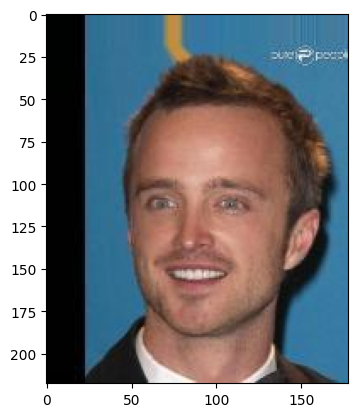

In [72]:
predict("/content/img_align_celeba/img_align_celeba/162774.jpg")